# Requirements/Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install -q imblearn SimpleITK pyradiomics

import os
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans
from skimage import segmentation, color
import matplotlib.pyplot as plt
import joblib

# part 5
import radiomics, threading, time, random, logging, json, pickle

import copy as cp
import pandas as pd
import SimpleITK as sitk

import seaborn as sns

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from radiomics import featureextractor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.utils import resample, shuffle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.over_sampling import KMeansSMOTE
from imblearn.combine import SMOTETomek

from collections import Counter

# part 6
!pip install -q segmentation-models-pytorch albumentations


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install matplotlib-venn
from matplotlib_venn import venn2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 43.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 41.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8

In [ ]:
# Path variable
path = '/content/drive/MyDrive/ECSE 415/'
CACHE_PATH = os.path.join(path, '.cache')

print(os.listdir(path))

SEED = 1
np.random.seed(SEED)
random.seed(SEED)

['mask', 'csv', 'rgb', 'splits', 'gray', 'mask_gray', '.cache', 'data.pkl', 'segmentation_images_masks.pkl', 'dice_avg_3_gray.pkl', 'train_data.pkl', 'val_data.pkl', 'segmentation_hyperparams.pkl', 'dice_avg_3_5.pkl', 'dice_avg_best_k_gray.pkl', 'dice_avg_3_to_10.pkl', 'mean_shift_hyperparams.pkl', '42-data-train.pkl', '42-data.pkl', 'rf_gpu_model.pkl', 'svm_gpu_model.pkl', 'model.pkl', 'model_5.pkl', 'model_5.4.pkl', 'mean_shift_hyperparams_2.pkl', 'dice_avg_mean_shift.pkl']


# 3) Dataset Preparations

## 3.1 Understanding the data and overlaying mask and image

**Introduction**


---

Early and accurate detection of tumors is crucial for effective cancer diagnosis, prognosis, and treatment planning. Manual tumor detection and segmentation from histopathological images is time consuming, prone to human error, and subjective making it challenging to achieve consistent and reproducible results.

The goal of this project is to use computer vision and machine learning techniques to produce an effective and reliable method for tumor detection and segmentation. We explore the use of unsupervised, supervised and deep learning techniques in analyzing medical images, significantly reducing diagnosis time, improving accuracy, and enabling personalized medical interventions.

The provided dataset consists of histopathology images from multiple subjects Each image contains multiple nuclei, some of which are tumor nuclei. Ground truth masks and csv data about the location of different cell types to help with the supervised learning approaches we will use as they require label data.



In [ ]:
# Read the input image and it's corresponding mask
input_image = cv2.imread(path + 'rgb/TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_left-57268_top-29680_bottom-29958_right-57547.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
overlayed_images = input_image.copy()

mask = cv2.imread(path + 'mask/TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_left-57268_top-29680_bottom-29958_right-57547.png')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

print(mask.shape)
print(input_image.shape)

mask_gray = mask[:, :, 0]
print(np.unique(mask_gray))
# Flipping the background to be 255
mask_gray[mask_gray < 1] = 255

(278, 279, 3)
(278, 279, 3)
[  0   1   9  99 253]


**Understanding the data**


---


Let's start by understanding what each mask encodes for example given the mask each channel has a specific meaning. The first channel in each mask image encodes the class labels. The product of the second and third channels encode the unique instance label for each nucleus. The fov area (gray) is included in the first channel of the mask

In [ ]:
print(mask.shape)
print("The values that the pixels might have:", np.unique(mask[:,:, 0]))
print("The number of unique instance IDs:", (np.unique(mask[:,:, 1])))
print("The number of unique instance IDs:", (np.unique(mask[:,:, 2])))
# Here we subtract 2 as the instance label 0 corresponds to the background
# and the instance label 2 corresponds to the fov
print("The number of nuclei:", len(np.unique(mask[:,:, 1]* mask[:,:, 2])) - 2)

(278, 279, 3)
The values that the pixels might have: [  1   9  99 253 255]
The number of unique instance IDs: [0 1]
The number of unique instance IDs: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
The number of nuclei: 38


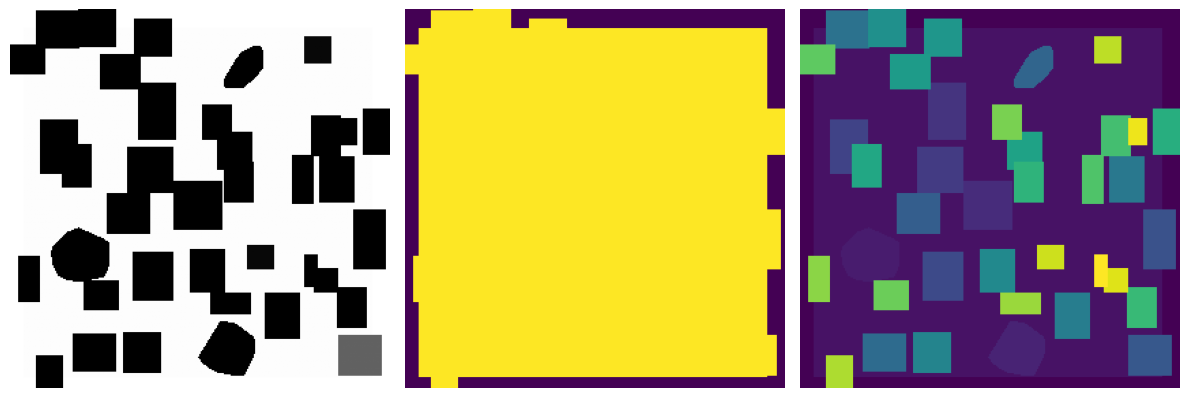

In [ ]:
# Plot all three channels
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(mask[:,:, 0], cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask[:,:, 1])
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(mask[:,:, 2])
plt.axis('off')

plt.tight_layout()

| Channel | Description                                                                 |
|---------|------------------------------------------------------------------------------|
| 0       | **Class label**: indicates what the pixel represents                        |
|         | - `<253` = Nucleus                                                           |
|         | - `255` = Background                                                              |
|         | - `253` = Field of View (FOV) area (gray)                                    |
| 1       | First part of the **instance ID** (used to distinguish individual nuclei)    |
| 2       | Second part of the **instance ID**                                           |
| 1 × 2   | The product of channel 1 and 2 gives a **unique ID for each nucleus**        |

**CSV Data**

---

The provided CSV files contain annotation data corresponding to each histopathology image in the dataset. Each row in the CSV represents the coordinates and labels of nuclei identified within the images. Specifically, these files include information such as nucleus type (tumor, fibroblast), bounding box shape, and precise pixel coordinates. This is best shown by using the example below as our goal is to parse through each file and extract (x,y) coordinates of the mask, the tumor type to validate the accuracy of our segmentation and classification methods


In [ ]:
# Read the csv to get the data on all potential tumors in the patient
with open(path + 'csv/TCGA-S3-AA15-DX1_id-5ea40a6addda5f839898f24a_left-57268_top-29680_bottom-29958_right-57547.csv', 'r') as file:
    bounding_boxes_unprocessed = file.readlines()[1:]

print(bounding_boxes_unprocessed[0])

0,unlabeled,AMBIGUOUS,AMBIGUOUS,rectangle,241,239,273,269,"241,273,273,241","239,239,269,269"



In [ ]:
# We process the data by using the delimeters for guidance
print("X-coordinates:", bounding_boxes_unprocessed[0].split('"')[1])
print("Y-coordinates:", bounding_boxes_unprocessed[0].split('"')[3])

# The shape
print("Shape:", bounding_boxes_unprocessed[0].split(',')[4])

X-coordinates: 241,273,273,241
Y-coordinates: 239,239,269,269
Shape: rectangle


In [ ]:
# Processing bounding_box lines
bounding_boxes = list(map(
    lambda x: (
        x.split(',')[1],  # Type of tumor
        np.array(
            [
                [int(x_), int(y_)] # Get coordinates as list [[x1, y1], [x2,y2]]
                for x_, y_ in zip(
                    x.split('"')[1].split(','),
                    x.split('"')[3].split(',')
                )
            ],
            dtype=np.int32 # Convert into NumPy array
        ).reshape(-1, 1, 2) # Reshape to expected shape for the function
    ),
    bounding_boxes_unprocessed
))

print(bounding_boxes[0])

('unlabeled', array([[[241, 239]],

       [[273, 239]],

       [[273, 269]],

       [[241, 269]]], dtype=int32))


**Bounding Boxes**


---

After processing the CSV data, we extract the coordinates outlining each nucleus, including both rectangular and polygonal shapes. Our goal is to visually represent each annotated nucleus by drawing bounding boxes or polygon boundaries directly onto the histopathological images.

Using the coordinate pairs (x and y values) extracted from the CSV data, we apply the cv2.polylines() function from OpenCV. This  function allows us to accurately draw both rectangular bounding boxes and irregular polygon outlines around each tumor or nucleus region, clearly highlighting their exact location and shape. By overlaying these visual annotations onto the original images, we create visualizations that support our tumor detection and segmentation tasks



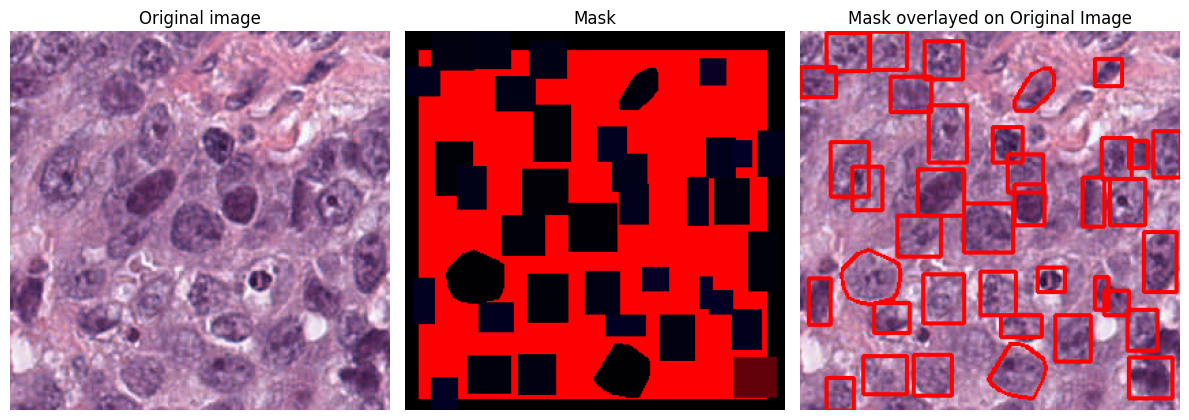

In [ ]:
for bounding_box in bounding_boxes:
  cv2.polylines(overlayed_images, [bounding_box[1]], isClosed=True, color=(255, 0, 0), thickness=2)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(input_image)
plt.title("Original image")
plt.axis('off')

plt.subplot(1,3,2)
original_mask = mask.copy()
original_mask[original_mask == 255] = 0
plt.imshow(original_mask, cmap="gray")
plt.title("Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlayed_images)
plt.title("Mask overlayed on Original Image")
plt.axis('off')

plt.tight_layout()
plt.show()

### Helper Functions

In [ ]:
def read_image_rgb(image_path):
    """
    Reads an image from a given path and converts it to RGB.
    """
    if isinstance(image_path, str):
        image_path = path+"rgb/"+image_path+".png"
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
          raise FileNotFoundError(f"Could not find or open image at {image_path}")
    else:
        img_bgr = image_path


    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    return img_rgb

In [ ]:
def read_mask_gray(mask_path, real_img, threshold=1):
    """
    Reads a mask from a given path, converts it to grayscale, and binarizes it
    (any pixel < threshold is set to 255; typical usage is threshold=1 for 0/1 masks).
    """
    # Check type
    if isinstance(mask_path, str):
        mask_path = path + "mask/" + mask_path + ".png"
        mask_bgr = cv2.imread(mask_path)
        if mask_bgr is None:
            raise FileNotFoundError(f"Could not find or open mask at {mask_path}")
        mask_rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)
    else:
        mask_rgb = mask_path

    # Ensure mask_rgb is a numpy array (in case it's a list)
    if not isinstance(mask_rgb, np.ndarray):
        mask_rgb = np.array(mask_rgb)

    # Convert to grayscale by taking the first channel; assuming it's a 1-channel mask
    mask_gray = mask_rgb[:, :, 0]

    # Take minimum dimensions
    real_img_height, real_img_width = real_img.shape[:2]
    mask_height, mask_width = mask_gray.shape
    min_height = min(real_img_height, mask_height)
    min_width = min(real_img_width, mask_width)

    # Slice masks to match input image size
    mask_gray = mask_gray[:min_height, :min_width]
    actual_img = real_img[:min_height, :min_width]

    # Get the number of nuclei (subtract by two to ignore background and fov)
    nuclei_nums = len(np.unique(mask_rgb[:, :, 1] * mask_rgb[:, :, 2])) - 2

    # Flipping the background to be 255
    mask_gray[mask_gray < threshold] = 255
    return mask_gray, nuclei_nums, actual_img


In [ ]:
def get_binary_mask(mask_gray):
  """
  Function that returns a binary mask with nuclei set to 1
  """
  binary_mask = mask_gray.copy()
  binary_mask = (binary_mask < 253).astype('uint8')

  return binary_mask


In [ ]:
def read_bounding_boxes(csv_path):
    """
    Reads a CSV file that contains bounding box (polygon) information.
    Returns a list of tuples: (shape_type, coordinates), where 'coordinates'
    is a numpy array of shape (N, 1, 2), suitable for cv2.polylines.
    """
    bounding_boxes = []
    if isinstance(csv_path, str):
        csv_path = path+"csv/"+csv_path+".csv"
    try:
        with open(csv_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find or open CSV at {csv_path}")

    # Skip the header line
    bounding_boxes_unprocessed = lines[1:]

    # Process bounding_box lines
    for line in bounding_boxes_unprocessed:
        shape_type = line.split(',')[1]

        x_coords = line.split('"')[1].split(',')
        y_coords = line.split('"')[3].split(',')

        coords = np.array(
            [[int(x_), int(y_)] for x_, y_ in zip(x_coords, y_coords)],
            dtype=np.int32
        ).reshape(-1, 1, 2)

        bounding_boxes.append((shape_type, coords))

    return bounding_boxes

In [ ]:
def overlay_bounding_boxes(image, bounding_boxes, color=(255, 0, 0), thickness=2):
    """
    Overlays bounding boxes (polygons) onto the image in place.
    Returns the updated image copy with drawn polygons.
    """
    overlayed_image = image.copy()
    for _, coords in bounding_boxes:
        cv2.polylines(overlayed_image, [coords], isClosed=True, color=color, thickness=thickness)
    return overlayed_image

In [ ]:
def process_inputs(image_name):
        """
        Processes one image: reads the RGB image, converts to grayscale/mask,
        obtains the bounding boxes, and computes a binary mask.
        """
        img = read_image_rgb(image_name)
        mask, nuclei, img = read_mask_gray(image_name, img)
        bboxes = read_bounding_boxes(image_name)
        binary_mask = get_binary_mask(mask)
        return img, (binary_mask, nuclei), bboxes

In [ ]:
def process_image(image_path, mask_path, csv_path):
    """
    Main pipeline that:
      1. Reads the input image.
      2. Reads and binarizes the mask.
      3. Slices the mask to match the input image size.
      4. Reads bounding box data from CSV.
      5. Overlays bounding boxes on the image.
    """
    # Read the input image
    input_image = read_image_rgb(image_path)

    # Read the mask in gray (and binarize)
    mask_gray, nuclei_nums, input_image = read_mask_gray(mask_path, input_image, threshold=1)

    # Read bounding boxes from CSV
    bounding_boxes = read_bounding_boxes(csv_path)

    # Create overlay of bounding boxes
    overlayed_image = overlay_bounding_boxes(input_image, bounding_boxes)

    return input_image, mask_gray, overlayed_image, nuclei_nums

## 3.2 Training & Validation Split

**Train-Validation Split**


---


To ensure that all patients are evaluated fairly, we structured our 80/20 train-validation split at the patient level rather than at the image level. Our dataset includes multiple images per subject, identifiable by unique patient IDs embedded in the filenames (e.g., TCGA-A1-A0SP-DX1). Without accounting for these identifiers, there is a risk that images from the same patient could appear in both training and testing sets, leading to overfitting and inflated performance metrics. By parsing filenames to isolate unique patient IDs, we ensured that all data associated with a single subject is confined to either the training or testing set.

After extracting the patient IDs, we perform our split and save the train patient ID's in one CSV file and the validation patient ID's in another.

In [ ]:
img_names = os.listdir(path + 'rgb')
print("Number of Images in Dataset:",len(img_names))

Number of Images in Dataset: 1744


In [ ]:
# Detect all the text until ID is detected
patients = list(map(lambda x:x[:16], img_names))

# Check if all patients string end with DX1
unique_patients = list(set(patients))

print("Number of Patients in Study:", len(unique_patients))

Number of Patients in Study: 124


In [ ]:
# Split training and validation set
split_index_80 = int(len(unique_patients) * 0.8)

# Shuffle patient names to avoid overfitting
np.random.seed(42)
np.random.shuffle(unique_patients)

# Split the list
train_subjects = unique_patients[:split_index_80]
validate_subjects = unique_patients[split_index_80:]

# Create the new folder if not already there
os.makedirs(path + 'splits', exist_ok=True)
with open(path + 'splits/train_subjects.csv', 'w') as file:
    file.write('\n'.join(train_subjects))
with open(path + 'splits/validate_subjects.csv', 'w') as file:
    file.write('\n'.join(validate_subjects))

# 4) Segmentation

### Helper Functions

In [ ]:
# Function to compute the DICE coefficient
def dice_coefficient(predicted_mask, ground_truth_mask):
    intersection = np.sum(predicted_mask * ground_truth_mask)
    total_pixels = np.sum(predicted_mask) + np.sum(ground_truth_mask)

    if total_pixels == 0:
        return 1.0  # Perfect match

    return (2.0 * intersection) / total_pixels


def plot_images(images, num_to_plot=10, title = ''):
    plt.figure(figsize=(15, 5))

    for i in range(min(num_to_plot, len(images))):
        plt.subplot(2, 5, i + 1)  # 2 rows x 5 columns
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Function for processing masks
def process_mask(mask, size):
    binary_mask = mask.copy()
    # Morphology Ex
    kernel = np.ones(size,np.uint8)

    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Make it into int
    binary_mask = binary_mask.astype(np.uint8)


    # draw contours and fill them with white
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
      area = cv2.contourArea(contour)
      if area >= 100:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(binary_mask, (x, y), (x + w, y + h), (255, 255, 255), -1)
    return binary_mask

def load_data(subjects, path, subset_name, use_pickle=True, save_pickle=True):
    """
    Loads image data, masks, and bounding boxes for a given list of subjects.
    Optionally uses a thread pool to process images concurrently and pickles the
    result for faster reuse.

    """
    pickle_file = f"{subset_name}_data.pkl"

    # If use_pickle is True and the pickle file exists, load from it.
    if use_pickle and os.path.exists(path + pickle_file):
        with open(path + pickle_file, 'rb') as f:
            return pickle.load(f)

    images = []
    ground_truth_masks = []
    file_names = []
    bounding_boxes = []

    # Assumes that the 'rgb' folder is under the given path.
    rgb_folder = os.path.join(path, 'rgb')

    # Gather all file names matching any subject.
    subject_files = []
    for subject in subjects:
        subject_files.extend([f.split('.')[0] for f in os.listdir(rgb_folder) if subject in f])
    file_names = subject_files.copy()  # Save the file names.


    # Process all images concurrently using a thread pool.
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(process_inputs, subject_files))

    # Unpack results.
    for img, mask, coords in results:
        images.append(img)
        ground_truth_masks.append(mask)
        bounding_boxes.append(coords)

    # Optionally pickle the results for faster future loading.
    if save_pickle:
        with open(pickle_file, 'wb') as f:
            pickle.dump((images, ground_truth_masks, file_names, bounding_boxes), f)

    return images, ground_truth_masks, file_names, bounding_boxes

## 4.0.0 Preprocessing Data

**Preprocessing**



---



In [ ]:
# # Load training data
training_images, ground_truth_masks, file_names, bounding_boxes_train = load_data(
    subjects=train_subjects,
    path=path,
    subset_name='train',
    use_pickle=True,     # Load from pickle if it exists
    save_pickle=False     # Save it after first run
)


In [ ]:
# Load validation data
validation_images, ground_truth_masks_validation, file_names_validate, bounding_boxes_validate = load_data(
    subjects=validate_subjects,
    path=path,
    subset_name='val',
    use_pickle=True,
    save_pickle=False
)

In [ ]:
# Assert both images, mask, file names are same size
print(len(training_images) == len(ground_truth_masks) == len(file_names))

True


In [ ]:
print(len(validation_images), len(ground_truth_masks_validation), len(file_names_validate))

351 351 351


Examining image TCGA-E2-A573-DX1_id-5ea40b40ddda5f839899ac55_left-62223_top-57400_bottom-57712_right-62513
Number of Nuclei: 35


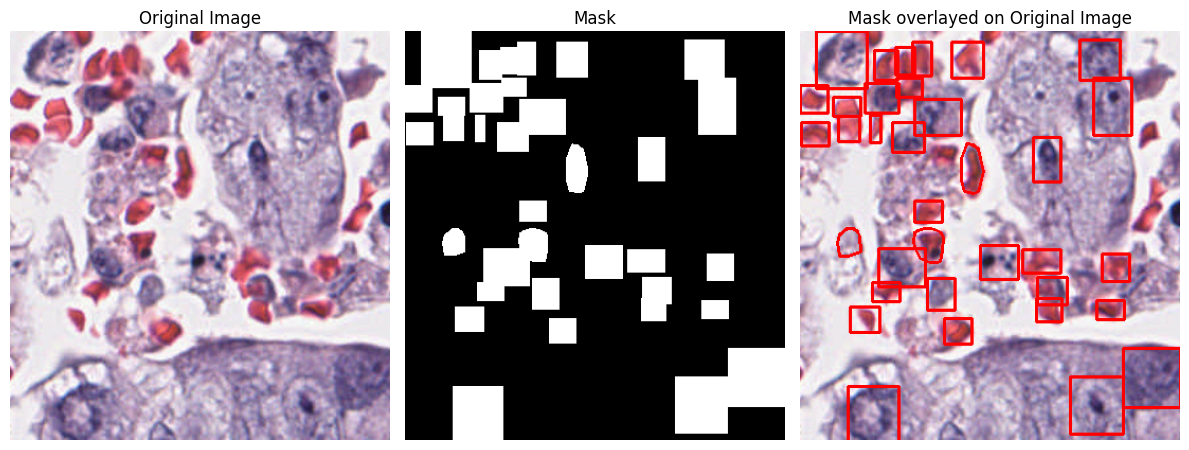

In [ ]:
# Plot a random mask and its image
random_index = np.random.randint(0, len(ground_truth_masks))
img = training_images[random_index]
mask, nuclei = ground_truth_masks[random_index]
file_name = file_names[random_index]

# Get the bounding box
bounding_boxes = read_bounding_boxes(file_name)

# overlay
overlayed_image = overlay_bounding_boxes(img, bounding_boxes)

print(f"Examining image {file_name}")
print(f"Number of Nuclei: {nuclei}")
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlayed_image)
plt.title("Mask overlayed on Original Image")
plt.axis('off')


plt.tight_layout()
plt.show()

## 4.1 Segmentation - Unsupervised

### 4.1.0 Helper Functions

In [ ]:
def find_closest(lst, target):
    return min(lst, key=lambda x: abs(x - target))

# Apply k-means clustering
def segementing_image(image, k, thresh, contouring=True):

  img = image.copy()

  # Median filter
  img = cv2.medianBlur(img, 3)

  flattened_image = img.reshape(-1,1 if len(image.shape) < 3 else image.shape[-1])

  kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(flattened_image)
  labels = kmeans.labels_

  # Reshape the labels to the original image shape
  segmented_image = labels.reshape(img.shape[:2])

  max_label = np.max(segmented_image)

  # Convert segmented_image to uint8
  segmented_image = segmented_image.astype(np.uint8)

  # Generate the binary mask
  areas = []
  for i in range(k):
    areas.append(np.sum((segmented_image == i).astype(np.uint8)))

  sorted_labels = np.argsort(areas)
  numerated_sorted_labels = []
  for i in range(len(sorted_labels)):
    numerated_sorted_labels.append(i/max_label)

  closest_threshold = find_closest(numerated_sorted_labels, thresh)
  binary_mask = np.where(segmented_image == sorted_labels[int(closest_threshold)], 1, 0)

  # Make it into int for the findContours function
  binary_mask = binary_mask.astype(np.uint8)

  # draw contours and fill them with white
  if contouring:
      contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      for contour in contours:
        area = cv2.contourArea(contour)
        if area >= 100 and area < img.shape[0] * img.shape[1] * 1/30:
          x, y, w, h = cv2.boundingRect(contour)
          cv2.rectangle(binary_mask, (x, y), (x + w, y + h), (1, 1, 1), cv2.FILLED)

  return binary_mask

def compute_dice_scores(k, images, ground_masks, thresh=0.1, segmentor = segementing_image):
    dice = 0
    for i in range(len(images)):
        predicted_mask = segmentor(images[i], k, thresh)
        dice += dice_coefficient(predicted_mask, ground_masks[i])

    dice /= len(images)
    return dice

### 4.1.1 Displaying K-Value Results For K=3 & K=5


**K-Mean segmentation**



---

In this section, our goal is to find the best K for our segmentation using K-means. We do so by performing a grid search over a range of K and thresholds.

The segmentation algorithm performs a median filter on the image before segmenting. This helps to smooth out the image, and diminish the noise that might affect the segmentation process. Then, the K-Mean algorithm segments the image, and the labels/segments obtained are ranked by area in number of pixels from smallest to largest. A normalized threshold is then used to determine which segment to select (threshold obtained by hyperparameter selection). And finally bounding boxes are constructed around the pixel patches of the selected segment which helps to mimic the mask which contains many rectangular segmented nuclei.

In [ ]:
reducing_factor = 1
subset_index = len(ground_truth_masks_validation)//reducing_factor
ground_truth_masks_validation_binary = list(map(lambda x: x[0], ground_truth_masks_validation[:subset_index]))
ground_truth_masks_binary = list(map(lambda x: x[0], ground_truth_masks))
training_images_gray = list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), training_images))

**Hyperparameter selection**

---

In order to optimize and justify the K (number of clusters) and normalized threshold parameters used, we perform a grid search of a few discrete values. We calculate the DICE score, over the validation set, for each pair of (k, thresh) value in the grid search, and register the best performing pair.

In [ ]:
# Thresholds hyperparameter selection

if os.path.exists(path + 'segmentation_hyperparams.pkl'):
  # Load the list from the file
  with open(path + 'segmentation_hyperparams.pkl', 'rb') as file:
      loaded_data = pickle.load(file)

  dice_avgs = loaded_data['dice_avgs']
  k_thresh = loaded_data['k_thresh']
else:
  thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

  k_values = [3, 4, 5, 6, 7, 8, 9, 10]

  dice_avgs = []
  k_thresh = []
  for k in k_values:
    best_k_dice_avg = -1
    best_thresh = -1
    for i in range(len(thresholds)):
      thresh = thresholds[i]
      dice_avg = compute_dice_scores(k, validation_images[:subset_index], ground_truth_masks_validation_binary, thresh)
      if dice_avg > best_k_dice_avg:
        best_k_dice_avg = dice_avg
        best_thresh = thresh
    dice_avgs.append(best_k_dice_avg)
    k_thresh.append(best_thresh)


  # Save the training images and masks into file to not recompute everytime
  data = {'dice_avgs': dice_avgs, 'k_thresh': k_thresh}

  # Save the lists to a file
  with open(path + 'segmentation_hyperparams.pkl', 'wb') as file:
      pickle.dump(data, file)

In [ ]:
# Find the average DICE score for several values of K

if os.path.exists(path + 'dice_avg_3_to_10.pkl'):
  # Load the list from the file
  with open(path + 'dice_avg_3_to_10.pkl', 'rb') as file:
      loaded_data = pickle.load(file)

  dice_avg_3 = loaded_data['dice_avg_3']
  dice_avg_4 = loaded_data['dice_avg_4']
  dice_avg_5 = loaded_data['dice_avg_5']
  dice_avg_6 = loaded_data['dice_avg_6']
  dice_avg_7 = loaded_data['dice_avg_7']
  dice_avg_8 = loaded_data['dice_avg_8']
  dice_avg_9 = loaded_data['dice_avg_9']
  dice_avg_10 = loaded_data['dice_avg_10']
else:
  dice_avg_3 = compute_dice_scores(3, training_images, ground_truth_masks_binary, k_thresh[0])
  dice_avg_4 = compute_dice_scores(4, training_images, ground_truth_masks_binary, k_thresh[1])
  dice_avg_5 = compute_dice_scores(5, training_images, ground_truth_masks_binary, k_thresh[2])
  dice_avg_6 = compute_dice_scores(6, training_images, ground_truth_masks_binary, k_thresh[3])
  dice_avg_7 = compute_dice_scores(7, training_images, ground_truth_masks_binary, k_thresh[4])
  dice_avg_8 = compute_dice_scores(8, training_images, ground_truth_masks_binary, k_thresh[5])
  dice_avg_9 = compute_dice_scores(9, training_images, ground_truth_masks_binary, k_thresh[6])
  dice_avg_10 = compute_dice_scores(10, training_images, ground_truth_masks_binary, k_thresh[7])

  data = {'dice_avg_3': dice_avg_3, 'dice_avg_4': dice_avg_4, 'dice_avg_5': dice_avg_5, 'dice_avg_6': dice_avg_6, 'dice_avg_7': dice_avg_7, 'dice_avg_8': dice_avg_8, 'dice_avg_9': dice_avg_9, 'dice_avg_10': dice_avg_10}

  # Save the lists to a file
  with open(path + 'dice_avg_3_to_10.pkl', 'wb') as file:
      pickle.dump(data, file)

training_dice_avgs = [dice_avg_3, dice_avg_4, dice_avg_5, dice_avg_6, dice_avg_7, dice_avg_8, dice_avg_9, dice_avg_10]
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=3: {dice_avg_3}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=4: {dice_avg_4}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=5: {dice_avg_5}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=6: {dice_avg_6}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=7: {dice_avg_7}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=8: {dice_avg_8}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=9: {dice_avg_9}')
print(f'Average dice score for all input images for subjects in train_subjects.csv using K=10: {dice_avg_10}')

Average dice score for all input images for subjects in train_subjects.csv using K=3: 0.4415743024848416
Average dice score for all input images for subjects in train_subjects.csv using K=4: 0.45159379995051757
Average dice score for all input images for subjects in train_subjects.csv using K=5: 0.4422687397589868
Average dice score for all input images for subjects in train_subjects.csv using K=6: 0.41482238836464075
Average dice score for all input images for subjects in train_subjects.csv using K=7: 0.37852072843743106
Average dice score for all input images for subjects in train_subjects.csv using K=8: 0.34563639031768456
Average dice score for all input images for subjects in train_subjects.csv using K=9: 0.3063920673894458
Average dice score for all input images for subjects in train_subjects.csv using K=10: 0.2758290763552296


In [ ]:
best_k = np.argmax(training_dice_avgs) + 3
best_thresh = k_thresh[best_k - 3]

print(f'Optimal value of K found using validation set {best_k}')
print(f'Optimal value for threshold found using validation set {best_thresh}')

Optimal value of K found using validation set 4
Optimal value for threshold found using validation set 0.9


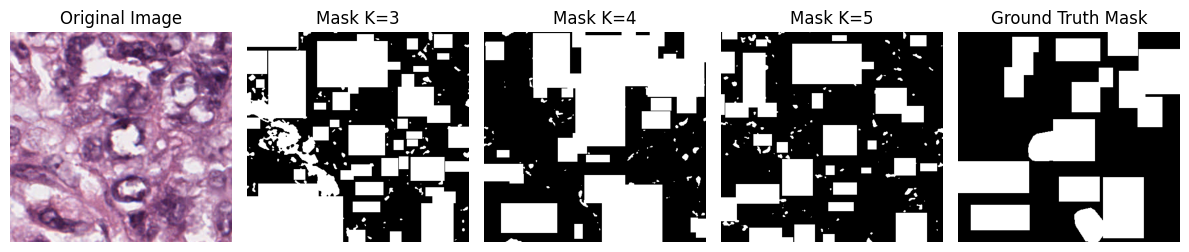

Dice score using K=3 segmentor: 0.366158550589594
Dice score using K=4 segmentor: 0.7194853277586559
Dice score using K=5 segmentor: 0.2800379244957766


In [ ]:
# Segment using k=3, 5, and optimal k

# For binary segmentation
sample_image_idx = 7
mask3 = segementing_image(training_images[sample_image_idx], 3, k_thresh[0])
mask_best_k = segementing_image(training_images[sample_image_idx], best_k, k_thresh[best_k - 3])
mask5 = segementing_image(training_images[sample_image_idx], 5, k_thresh[2])

# Show image and masks
plt.figure(figsize=(12,6))
plt.subplot(1,5,1)
plt.imshow(training_images[sample_image_idx])
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(mask3, cmap="gray")
plt.title("Mask K=3")
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(mask_best_k, cmap="gray")
plt.title("Mask K=4")
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(mask5, cmap="gray")
plt.title("Mask K=5")
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(ground_truth_masks_binary[sample_image_idx], cmap="gray")
plt.title("Ground Truth Mask")
plt.axis('off')


plt.tight_layout()
plt.show()

print(f'Dice score using K=3 segmentor: {dice_coefficient(mask3, ground_truth_masks_binary[sample_image_idx])}')
print(f'Dice score using K={best_k} segmentor: {dice_coefficient(mask_best_k, ground_truth_masks_binary[sample_image_idx])}')
print(f'Dice score using K=5 segmentor: {dice_coefficient(mask5, ground_truth_masks_binary[sample_image_idx])}')

### 4.1.2 Finding Optimal K-Value

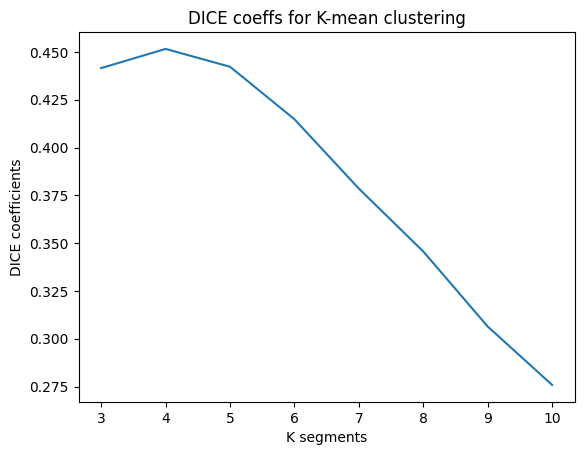

In [ ]:
# Plot dice avgs for different k

plt.plot(list(range(3, 11)), training_dice_avgs)
plt.xlabel('K segments')
plt.ylabel('DICE coefficients')
plt.title('DICE coeffs for K-mean clustering')
plt.show()

**Optimized value of K**



---



* The optimized value of K is found by computing the average DICE score on the validation set for each value of K in the range [3,4,5,6,7,8,9,10].
* In addition to finding the optimized value of K, we also use the validation set to find the best threshold for each of the K values. So we have nested loops for K and threshold hyperparameters in order to perform a grid search of optimal values.
* We obtain the best average DICE score of the subset of validation images for K=4 and threshold=0.9 (the threshold is normalized from the range [0,K-1]).

### 4.1.3 Show optimized value segmentation

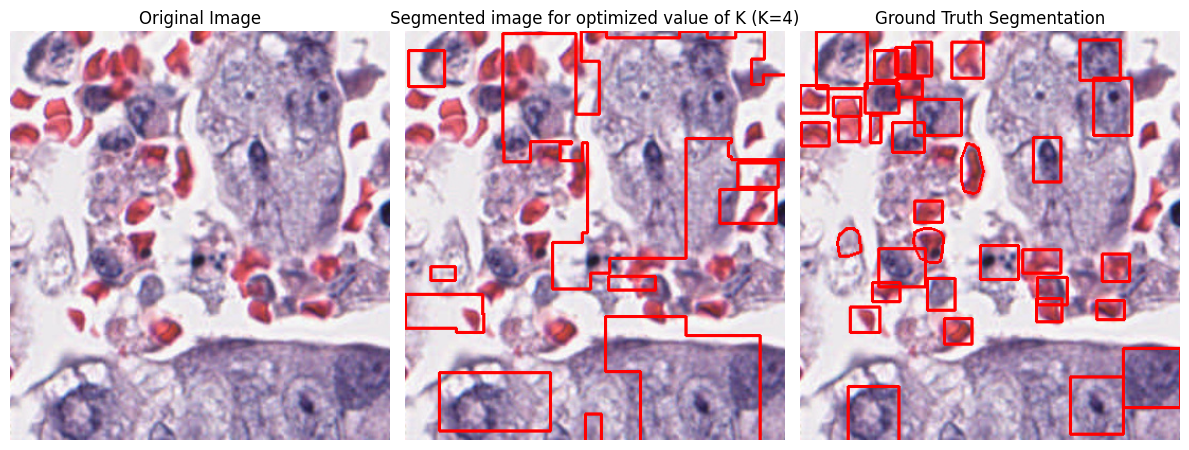

In [ ]:
# Show image and masks
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

overlayed_cntrs_predicted = img.copy()

# Performing erosion and dilation on the predicted mask to avoid small islands
kernel = np.ones((5,5), np.uint8)
eroded = cv2.erode(mask_best_k, kernel, iterations=3)
opened = cv2.dilate(eroded, kernel, iterations=3)

# Overlay mask over original image
contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(overlayed_cntrs_predicted, contours, -1, (255, 0, 0), 2)

plt.subplot(1,3,2)
plt.imshow(overlayed_cntrs_predicted, cmap="gray")
plt.title(f"Segmented image for optimized value of K (K={best_k})")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(overlayed_image, cmap="gray")
plt.title("Ground Truth Segmentation")
plt.axis('off')

plt.tight_layout()
plt.show()

### 4.1.4 Segmenting Using Grayscale

**K-Means with Grayscale preprocessing**

---

In an attempt to increase the avg DICE score for the training dataset, we preprocess the images by converting them to grayscale as this may help the segmentation algorithm focus on texture more than color.

In [ ]:
# Segmentation using grayscale

if os.path.exists(path + 'dice_avg_best_k_gray.pkl'):
  # Load the list from the file
  with open(path + 'dice_avg_best_k_gray.pkl', 'rb') as file:
      loaded_data = pickle.load(file)

  dice_avg_best_k_gray = loaded_data['dice_avg_best_k_gray']
else:
  dice_avg_best_k_gray = compute_dice_scores(best_k, training_images_gray, ground_truth_masks_binary, best_thresh)

  data = {'dice_avg_best_k_gray': dice_avg_best_k_gray}

  # Save the lists to a file
  with open(path + 'dice_avg_best_k_gray.pkl', 'wb') as file:
      pickle.dump(data, file)

print(f'Average dice score for all gray input images for subjects in train_subjects.csv using K={best_k}: {dice_avg_best_k_gray}')
print(f'Average dice score for all rgb input images for subjects in train_subjects.csv using K={best_k}: {dice_avg_4}')

Average dice score for all gray input images for subjects in train_subjects.csv using K=4: 0.44894037852568824
Average dice score for all rgb input images for subjects in train_subjects.csv using K=4: 0.45159379995051757


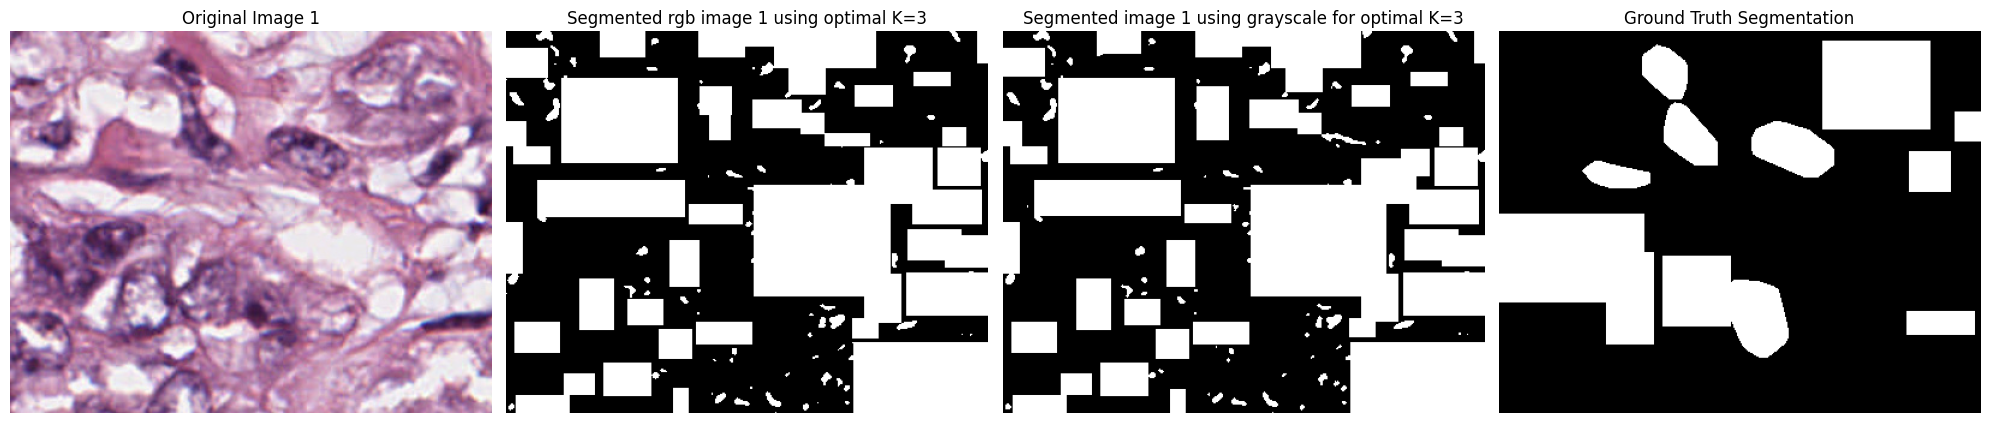

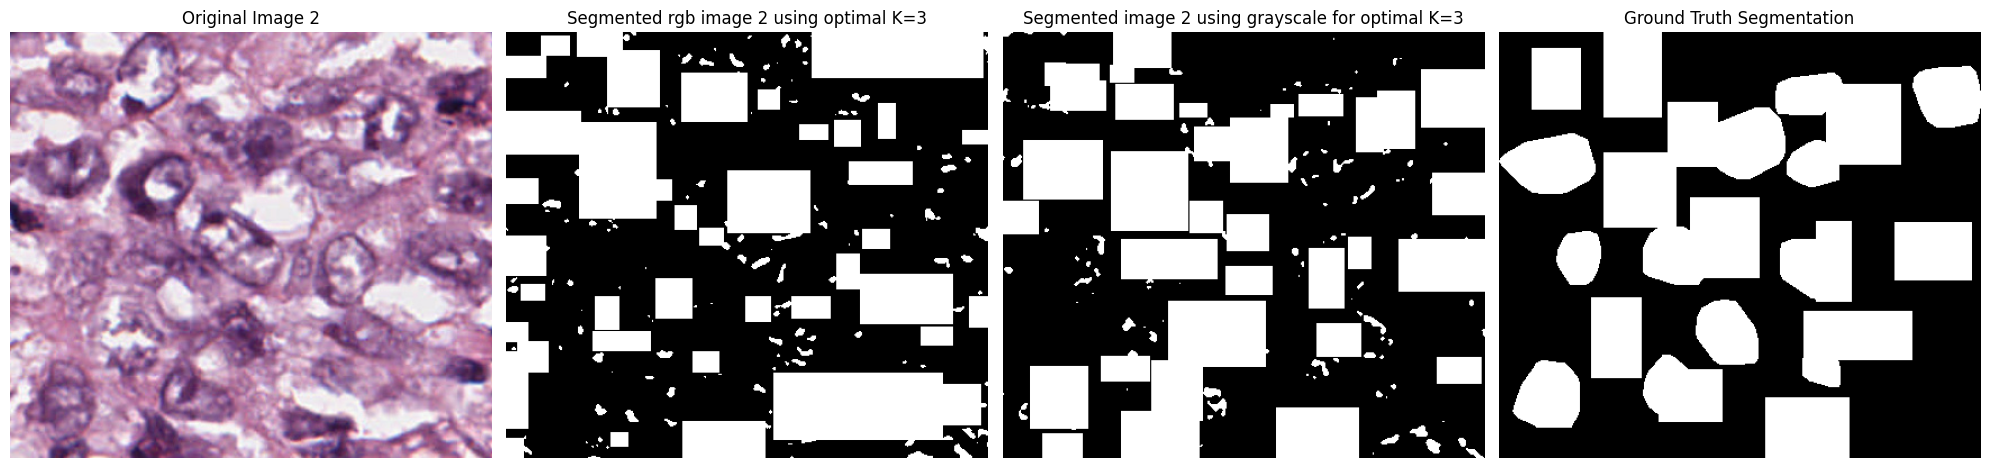

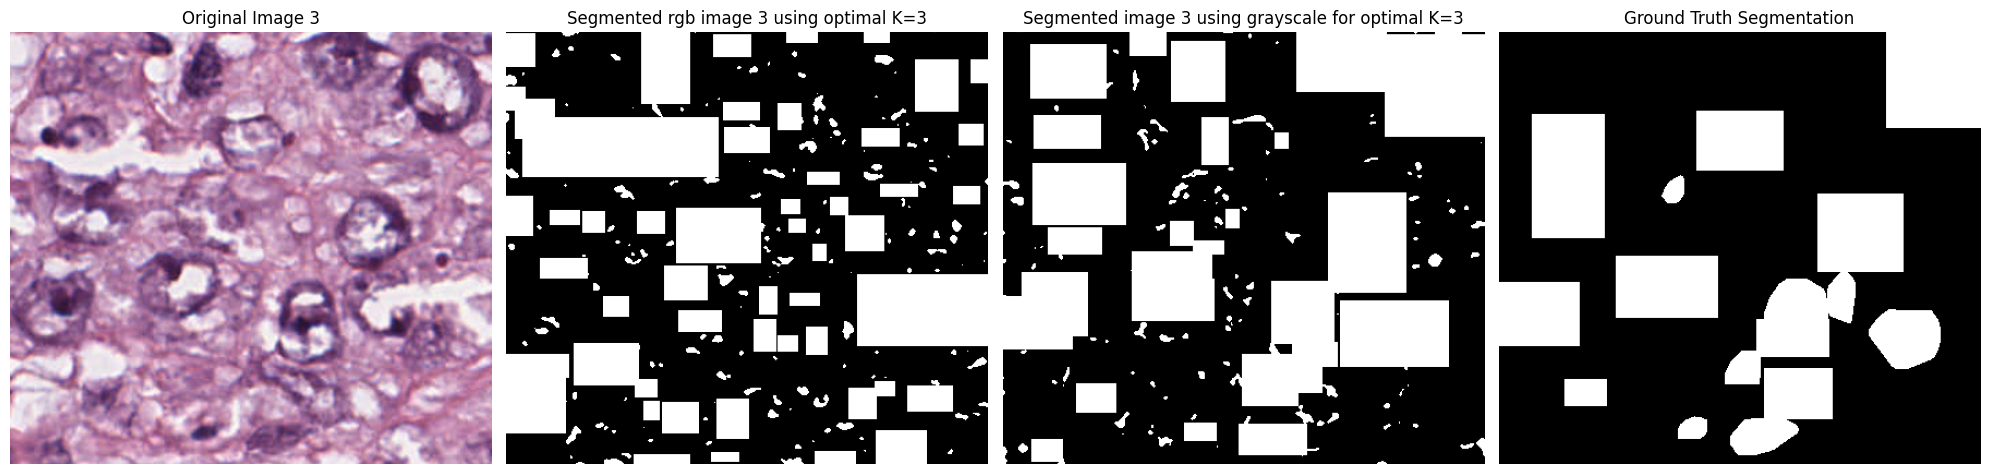

Dice score using K=3 segmentor for rgb image 1: 0.167400502588114
Dice score using K=3 segmentor for grayscale image 1: 0.16182305043991474
Dice score using K=3 segmentor for rgb image 2: 0.30260499238397215
Dice score using K=3 segmentor for grayscale image 2: 0.6805435985733612
Dice score using K=3 segmentor for rgb image 3: 0.3126040007080899
Dice score using K=3 segmentor for grayscale image 3: 0.690910324473769


In [ ]:
# 3 examples to support answer

# Show image and masks
list_dice_coeffs_rgb_gray = []
start_idx = 0
for i in range(start_idx, start_idx + 3):
  plt.figure(figsize=(20,15))
  image_rgb = training_images[i]
  image_gray = training_images_gray[i]
  ground_truth = ground_truth_masks_binary[i]
  predicted_mask_rgb = segementing_image(image_rgb, best_k, best_thresh)
  predicted_mask_gray = segementing_image(image_gray, best_k, best_thresh)

  i = i-start_idx

  plt.subplot(3,4,i * 4 + 1)
  plt.imshow(image_rgb)
  plt.title(f"Original Image {i+1}")
  plt.axis('off')

  plt.subplot(3,4,i * 4 + 2)
  plt.imshow(predicted_mask_rgb, cmap="gray")
  plt.title(f"Segmented rgb image {i+1} using optimal K=3")
  plt.axis('off')

  plt.subplot(3,4,i * 4 + 3)
  plt.imshow(predicted_mask_gray, cmap="gray")
  plt.title(f"Segmented image {i+1} using grayscale for optimal K=3")
  plt.axis('off')

  plt.subplot(3,4,i * 4 + 4)
  plt.imshow(ground_truth, cmap="gray")
  plt.title("Ground Truth Segmentation")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

  list_dice_coeffs_rgb_gray.append((dice_coefficient(predicted_mask_rgb, ground_truth), dice_coefficient(predicted_mask_gray, ground_truth)))

for i in range(3):
  print(f'Dice score using K=3 segmentor for rgb image {i+1}: {list_dice_coeffs_rgb_gray[i][0]}')
  print(f'Dice score using K=3 segmentor for grayscale image {i+1}: {list_dice_coeffs_rgb_gray[i][1]}')

**Grayscale for K-mean clustering segmentation**



---



*   The average DICE score improves slightly when preprocessing images in grayscale (from 0.446 to 0.449 average DICE score for training images).
*   This slight increase in DICE score average is reflected in the 3 examples in the cell above. The second and third images have a noticeable increase in DICE score (0.30 to 0.68, and 0.31 to 0.69 respectively) while the first image has a slight decrease (0.17 to 0.16).
*    So the grayscale preprocessing doesn't consistently improve the segmentation process for all the images, but it does in average raise the DICE score up for most image segmentations.

### 4.1.5 Other Unsupervised Segmentation

**Mean Shift**

---

The mean shift algorithm is an algorithm seen in class that does not require a number of clusters hyperparameter and uses modes of a non-parametric density instead. In our algorithm we preprocess the images by converting them to the LAB format (3-channel 2D pixel image with the L channel indicating the light intensity of the pixel, the A channel indicating the Red to Green color spectrum, and the B channel indicating the Blue to Yellow color spectrum of the pixel). After executing the mean shift segmentation, we perform similar postprocessing as in the K-mean method (segment sorting by area in sum of pixels, and threshold selection) except for the bounding boxes generation. The hyperparameters we are using are the normalized threshold (similar to the threshold in K-means method), and a 'ratio' parameter which dictates the number of segments considered as nuclei.

In [ ]:
from skimage.segmentation import quickshift

def mean_shift_segmentation(image, thresh, ratio):
    img = image.copy()
    image_lab = color.rgb2lab(img)
    segmented_image = quickshift(image_lab, kernel_size=10, max_dist=100, ratio=0.7)
    max_label = len(list(np.unique(segmented_image)))
    distance = int(max_label * ratio)

    # Computing segment areas
    areas = []
    for i in range(max_label):
      areas.append(np.sum((segmented_image == i).astype(np.uint8)))

    # Sorting segment areas
    sorted_labels = np.argsort(areas)
    numerated_sorted_labels = []
    for i in range(len(sorted_labels)):
      numerated_sorted_labels.append(i/max_label)

    closest_threshold = find_closest(numerated_sorted_labels, thresh)

    # Compute binary mask
    binary_mask = np.zeros_like(segmented_image)
    for i in range(distance):
      binary_mask[segmented_image == sorted_labels[int(closest_threshold) - distance//2 + i]] = 1

    binary_mask = binary_mask.astype(np.uint8)

    return binary_mask

**Mean Shift Hyperparameter selection**

---

We perform a 2D grid search to find the (threshold, ratio) pair maximizing performance. This is done in a nested loop going over every combination and computing validation accuracy on a subset of the validation set (around 11 samples) as the mean shift algorithm takes a long time to execute.

In [ ]:
# Thresholds hyperparameter selection for threshold and ratio parameters

reducing_factor = 30
subset_index = len(ground_truth_masks_validation)//reducing_factor

if os.path.exists(path + 'mean_shift_hyperparams_2.pkl'):
  # Load the list from the file
  with open(path + 'mean_shift_hyperparams_2.pkl', 'rb') as file:
      loaded_data = pickle.load(file)

  best_ratio = loaded_data['best_ratio']
  best_thresh = loaded_data['best_thresh']
  best_dice_avg = loaded_data['best_dice_avg']
else:
  # Values array to chose from
  thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
  ratios = [0.125, 0.1, 0.075, 0.05, 0.025]

  best_thresh = -1
  best_ratio = -1
  best_dice_avg = -1
  # Computing DICE scores and keeping the values rendering the best performance
  for thresh in thresholds:
    for ratio in ratios:
      dice_avg = compute_dice_scores(thresh, validation_images[:subset_index], ground_truth_masks_validation_binary, ratio, mean_shift_segmentation)
      if dice_avg > best_dice_avg:
        best_dice_avg = dice_avg
        best_thresh = thresh
        best_ratio = ratio

  # Save the results into file to not recompute everytime
  data = {'best_thresh': best_thresh, 'best_ratio': best_ratio, 'best_dice_avg': best_dice_avg}

  with open(path + 'mean_shift_hyperparams_2.pkl', 'wb') as file:
      pickle.dump(data, file)

print(f'Optimal value of threshold param found using validation set {best_thresh}')
print(f'Optimal value for ratio param found using validation set {best_ratio}')
print(f'DICE avg with best parameters {best_dice_avg}')

Optimal value of threshold param found using validation set 0.2
Optimal value for ratio param found using validation set 0.125
DICE avg with best parameters 0.35601737108748677


In [ ]:
# Segmentation using mean shift over trainining dataset

if os.path.exists(path + 'dice_avg_mean_shift.pkl'):
  # Load the list from the file
  with open(path + 'dice_avg_mean_shift.pkl', 'rb') as file:
      loaded_data = pickle.load(file)

  dice_avg_mean_shift = loaded_data['dice_avg_mean_shift']
else:
  # Computing the average DICE score over the training set for mean shift
  dice_avg_mean_shift = compute_dice_scores(best_thresh, training_images, ground_truth_masks_binary, best_ratio, mean_shift_segmentation)

  # Save the training images and masks into file to not recompute everytime
  data = {'dice_avg_mean_shift': dice_avg_mean_shift}

  # Save the lists to a file
  with open(path + 'dice_avg_mean_shift.pkl', 'wb') as file:
      pickle.dump(data, file)

print(f'Average dice score for all rgb input images for subjects in train_subjects.csv using Mean shift: {dice_avg_mean_shift}')
print(f'Average dice score for all grayscale input images for subjects in train_subjects.csv using K={best_k}: {dice_avg_best_k_gray}')

Average dice score for all rgb input images for subjects in train_subjects.csv using Mean shift: 0.30137607683055456
Average dice score for all grayscale input images for subjects in train_subjects.csv using K=4: 0.44894037852568824


**Mean shift and K-mean method comparison**

* The average DICE score for mean shift is lower by more than 10% than the average DICE score using the K-mean method, with grayscale conversion, over the training dataset (0.30 < 0.45).
* This may be explained by the great number of segments generated using the mean shift algorithm which makes it difficult to determine what combination of segments corresponds to the nuclei.
* Additionally, the complex texture of nuclei makes it harder to not be over-segment using the modes of a non-parametric density.

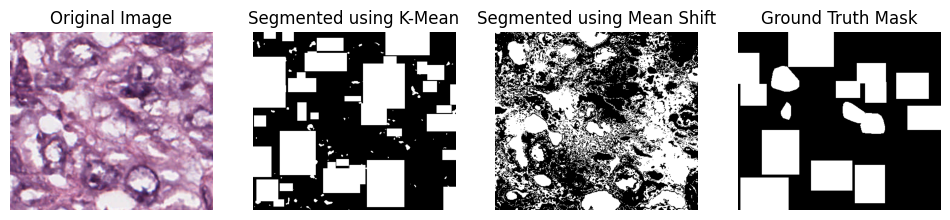

Dice score using mean shift segmentor: 0.33669577278315416
Dice score using K-mean segmentor: 0.6802963456255723


In [ ]:
# Show example of segmented image sample

sample_index = 4
image = training_images[sample_index]
ground_mask = ground_truth_masks_binary[sample_index]

# Apply K mean segmentation
predicted_mask_k_mean = segementing_image(image, best_k, best_thresh)

# Apply mean shift segmentation
predicted_mask_mean_shift = mean_shift_segmentation(image, best_thresh, best_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(predicted_mask_mean_shift, cmap='gray')
plt.title("Segmented using Mean Shift")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(predicted_mask_k_mean, cmap='gray')
plt.title("Segmented using K-Mean")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(ground_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.show()

print(f'Dice score using mean shift segmentor: {dice_coefficient(predicted_mask_mean_shift, ground_mask)}')
print(f'Dice score using K-mean segmentor: {dice_coefficient(predicted_mask_k_mean, ground_mask)}')

## 4.2 Supervised Segmentation

### 4.2.0 Helper Functions

In [ ]:
# Function to construct our mask
def construct_mask(tumor_map, bounding_boxes, image_shapes, flatten):
    new_masks = []
    for i in range(len(bounding_boxes)):
        mask = np.zeros(image_shapes[i], dtype=np.uint8)
        # Draw each region into the mask
        for label, coords in bounding_boxes[i]:
            tumor = tumor_map.get(label, 14)  # Default to 5 if label not found
            coords = coords.reshape(-1, 1, 2)   # ensure correct shape for cv2
            cv2.fillPoly(mask, [coords], color=tumor) # cv2 clips if outside image
        if flatten:
            mask = mask.reshape(-1)
        new_masks.append(mask)
    return new_masks

In [ ]:
# Function to extract LBP (texture)
from skimage.feature import local_binary_pattern

def extract_feature_for_image(image, patch=8, radius=1):
    # 1 LBP feature
    lbp = local_binary_pattern(image, int(patch), int(radius), method='uniform')
    return lbp

# Function to extract gradient features
def extract_gradient_features(image):
  # Compute gradients using Sobel operator
  grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
  grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y-direction

  # Gradient magnitude
  gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

  return  gradient_magnitude

# Test function
# x = extract_feature_for_image(X_train_images[0])
# print(x.shape)


In [ ]:
# Extract x-feature space and y values
def extract_img_features_labels(img, mask):

    # Get the mask
    binary_mask = (mask > 0).astype(np.uint8)

    lbp = extract_feature_for_image(img)
    gradient_magnitude_features = extract_gradient_features(img)  # Call function, store results

    # Use gradient_magnitude_features in column_stack
    features = np.column_stack([lbp.reshape(-1), img.reshape(-1), gradient_magnitude_features.reshape(-1)])

    # Extract y_train
    y_train = binary_mask.reshape(-1)

    return features, y_train

# Helper wrapper function for threading
def process_image(args):
    image, mask = args
    return extract_img_features_labels(image, mask)


In [ ]:
def postprocess_masks(Y_pred_masks, dilate_indices=None, erode_indices=None, kernel_size=(5, 5), iterations=1):

    if dilate_indices is None:
        dilate_indices = []
    if erode_indices is None:
        erode_indices = []

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)

    processed_masks = []

    for i, pred_mask in enumerate(Y_pred_masks):
        mask_uint8 = pred_mask.astype(np.uint8)

        if i in dilate_indices:
            mask_uint8 = cv2.dilate(mask_uint8, kernel, iterations=iterations)
        elif i in erode_indices:
            mask_uint8 = cv2.erode(mask_uint8, kernel, iterations=iterations)

        processed_masks.append(mask_uint8)

    return processed_masks

In [ ]:
def get_masked_tumor_predictions(gt_mask, pred_mask, tumor_map):

    intensity_to_label = {v: k for k, v in tumor_map.items()}

    # Get tumor intensities present in GT mask
    tumor_intensities = np.unique(gt_mask)
    tumor_intensities = [val for val in tumor_intensities if val in intensity_to_label]

    tumor_names = []
    gt_masks = []
    colored_preds = []

    for intensity in tumor_intensities:
        tumor_name = intensity_to_label[intensity]
        tumor_names.append(tumor_name)

        # GT binary mask for this tumor type
        single_gt_mask = (gt_mask == intensity).astype(np.uint8)
        gt_masks.append(single_gt_mask)

        # Predicted area where model thinks tumor exists AND GT says it's this tumor
        overlap_mask = np.logical_and(pred_mask == 1, gt_mask == intensity)

        # Create colored prediction for this tumor class
        colored_pred = np.zeros_like(pred_mask, dtype=np.uint8)
        colored_pred[overlap_mask] = intensity

        # Turn colored_pred binary
        colored_pred = (colored_pred > 0).astype(np.uint8)


        colored_preds.append(colored_pred)

    # Compute dice scores for each tumor type
    dice_scores = [dice_coefficient(gt_mask, pred_mask) for gt_mask, pred_mask in zip(gt_masks, colored_preds)]

    # Prepare string for printing
    dice_s = "\n".join([f"{name}: {dice:.4f}" for name, dice in zip(tumor_names, dice_scores)])

    return tumor_names, gt_masks, colored_preds, dice_s

### 4.2.1 Describing the Approach

**Our Approach**

---
We loaded images and their corresponding mask tumor coordinates. For each pixel, we used its intensity as a feature and flattened the image, and converted the CSV mask values through a mapping into a mask that can identify different tumors through our helper function. The mask has different values corresponding to where the tumor is. However, since our problem is a segmentation task rather than a detection of tumors problem, we converted our mask to binary to detect whether it’s a tumor or not.

Using the raw pixel values at first as features to train our classifier did not provide promising results, so we instead chose to extract features based on both local texture and intensity distribution. We used Local Binary Patterns (LBP) to capture texture and intensity histograms to represent grayscale intensity information. This combination allowed us to describe both the structural and visual characteristics of tumor regions, which as we observed differ from the nuclei of healthy cells.

We use LBP because it captures local texture variations. Tumors often exhibit distinct textural patterns from normal cells, and LBP computes the relationship between a pixel and its neighbors, making it a widely used and computationally efficient texture descriptor.

To further enhance boundary awareness, we incorporated Sobel gradients to capture intensity changes in horizontal and vertical directions. Sobel operators are useful for identifying edges—areas where pixel values change rapidly—which often correspond to tumor boundaries or transitions between tissue types. Including the gradient magnitude as a feature allows the model to better distinguish edges of tumor regions, improving localization and segmentation accuracy.

By combining LBP, pixel brightness, and gradient information, we create a feature space that reflects not only how a region appears (intensity) and how it is textured (LBP) but also how sharply it transitions (Sobel gradients). We do this using the helper functions provided in Section 4.2.0.

Finally, since this is a supervised taks we need labels to identify where the mask coordinates are. At first our initial idea was to provide the coordinates only as points of classification. However that proved challenging so what we instead did we used the contours, filled them and made every pixel inside the contour a mask. This way allowed us to have a more equal representation of masks rather than have a training dataset that is very biased towards the background.

In [ ]:
# Flattened list of all labels using lambda
tumor_types = set([tumor for coords in bounding_boxes_train for tumor in map(lambda x: x[0], coords)])

print(tumor_types)

{'mitotic_figure', 'apoptotic_body', 'macrophage', 'tumor', 'unlabeled', 'neutrophil', 'vascular_endothelium', 'myoepithelium', 'eosinophil', 'fibroblast', 'ductal_epithelium', 'lymphocyte', 'plasma_cell'}


In [ ]:
# Define mapping from label name to find the
tumor_map = {
'unlabeled': 20,
'tumor': 40,
'fibroblast': 60,
'lymphocyte': 80,
'plasma_cell': 100,
'macrophage': 120,
'neutrophil': 140,
'eosinophil': 160,
'apoptotic_body': 180,
'mitotic_figure': 195,
'vascular_endothelium': 210,
'ductal_epithelium': 215,
'myoepithelium': 230
}

**Training Data**



---


In our segmentation task, it’s critical that our training dataset includes all the tumor classes we expect to detect in our case, exactly 13 tumors. Since our training images are randomly sampled, there’s a chance that some batches might not contain examples of every tumor type. This would result in an imbalanced training set. Additionally, to evaluate the accuracy of our segmentating task, we would need to see which tumor types are not being segmented accurately so we construct the ground truth masks using our helper function to help us evaluate the accuracy of our supervised approach.

In [ ]:
training_size = 100
save = False

# Initialize lists
X_train_images = []
X_train_img_shape = []
X_train_coords = []
Y_train_masks = []
Y_train_reshaped_masks = []

if save:
  while True:
      # Take 50 images from the training set (or adjust size as needed)
      random_indices = np.random.choice(len(training_images), size=training_size, replace=False)
      # Convert to greyscale each image
      X_train_images = [cv2.cvtColor(training_images[i], cv2.COLOR_RGB2GRAY) for
                        i in random_indices]

      X_train_coords = [bounding_boxes_train[i] for i in random_indices]
      X_train_img_shape = [img.shape for img in X_train_images]  # Extract the shapes of each image

      # Construct the segmentation masks
      Y_train_masks = construct_mask(tumor_map, X_train_coords, X_train_img_shape)

      # Reshape the masks
      Y_train_reshaped_masks = [mask.reshape(img.shape[:2]) for mask, img in zip(Y_train_masks, X_train_images)]

      # Check if there are exactly 10 unique tumors in the train_masks
      if len(set(np.concat(Y_train_masks))) == 13:
          with open(path+"42-data.pkl", "wb") as f:
            pickle.dump((X_train_images, X_train_coords, X_train_img_shape,
                        Y_train_masks, Y_train_reshaped_masks), f)
          break
else:
  # Load from pickle
  with open(path + "42-data.pkl", "rb") as f:
      (
          X_train_images,
          X_train_coords,
          X_train_img_shape,
          Y_train_masks,
          Y_train_reshaped_masks
      ) = pickle.load(f)


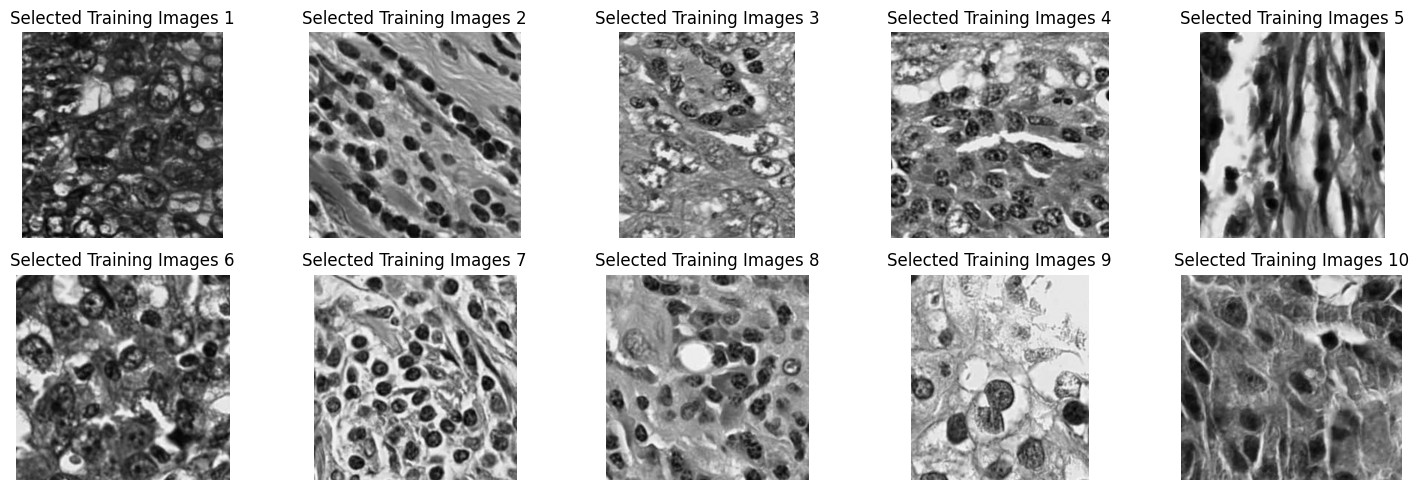

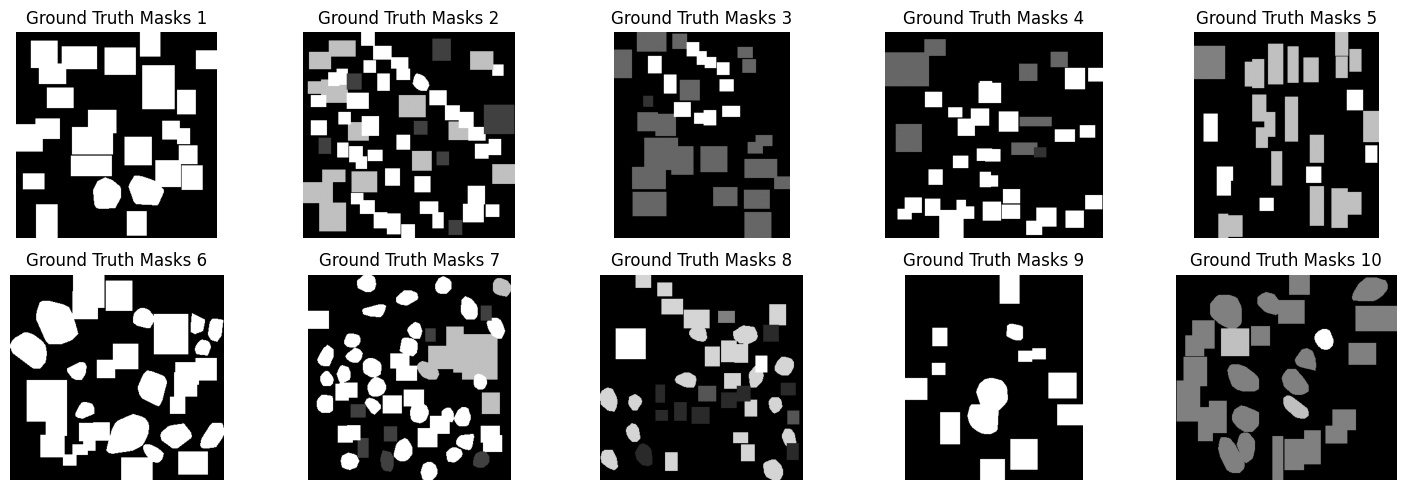

In [ ]:
# Use our plotting function to plot some images
plot_images(X_train_images[:10], title="Selected Training Images")

plot_images(Y_train_reshaped_masks[:10], title="Ground Truth Masks")

**Feature Space**


---


We built our **feature space** using texture and edge-based descriptors extracted with the `extract_img_features_labels()` function. This function combines:

- **Local Binary Patterns (LBP)**: captures local texture around each pixel
- **Image Gradients** (e.g., Sobel or Scharr): highlights edges and directional intensity change
- **Raw Pixel Intensity**: retains base grayscale signal and structural shape

This approach allows the model to not only detect where structures are located, but also understand how they look in terms of surface texture and boundary sharpness.


In [ ]:
# Prepare inputs for threading
image_mask_pairs = list(zip(X_train_images, Y_train_reshaped_masks))

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    results = list(executor.map(process_image, image_mask_pairs))

X_train = []
Y_train = []

# Collect and flatten results
for X_feature, Y_data in results:
    X_train.append(X_feature)
    Y_train += list(Y_data)

# Reshape X_train to 2D
X_train = np.vstack(X_train)
Y_train = np.array(Y_train)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (12872069, 3)
Y_train shape: (12872069,)


In [ ]:
if save:
  with open(path+"42-data-train.pkl", "wb") as f:
    pickle.dump((X_train, Y_train), f)
else:
  with open(path+"42-data-train.pkl", "rb") as f:
    X_train, Y_train = pickle.load(f)


In [ ]:
# Check type of X_train, Y_train
print(type(X_train))
print(type(Y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


**Model Selection: Linear SVM and Random Forest**


---


After constructing our feature space, which includes over a million samples combining **LBP texture**, **image gradients**, and **raw pixel intensities**. To efficiently handle large-scale classification, we use **GPU-accelerated Linear SVM and Random Forest models** from the `cuML` library, part of NVIDIA’s RAPIDS ecosystem.

We use **Linear SVMs** because they are good classifiers for large feature spaces like ours, as the tumor features that we have are linearly seperable and with our features (LBP, gradients, intensities), the SVM is capable of inferring an accurate decision boundary between pixel types.


We also use **Random Forests** as they are non-linear ensemble models so see if a non linaer model can better seperate the tumors since the feature relationships are complex or non-linear (gradients) and since our model needs to handle irregular shapes of nuclei

Using both models enables us to explore different segmentation behaviors and choose the one that best fits our tumor morphology and feature distribution.

### 4.2.2 Training Set Segmentation

**Supervised Segmentation**



---


As previously discussed, we use cuML’s GPU-accelerated SVM & RFs to perform pixel-wise classification for image segmentation.

We train the SVM using a linear kernel, suitable for separating classes in our engineered feature space (LBP, gradients, and intensity). For evaluation, we compute both accuracy and the Dice coefficient as it measures overlap between predicted and ground truth masks.

After training, the flat pixel-level predictions are reshaped back into 2D mask format, allowing for direct visual comparison with the ground truth masks


In [ ]:
import cuml
from cuml.svm import LinearSVC
from cuml.ensemble import RandomForestClassifier
import cudf


# Load if we saved the model
if not save:
    best_svm_model = joblib.load(path + 'svm_gpu_model.pkl')
    best_rf_model = joblib.load(path + 'rf_gpu_model.pkl')

# Train and Save Models
else:
    # C optimization
    C_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
    best_svm_score = -1
    best_svm_model = None
    best_C = None

    for C in C_values:
        print(f"[SVM] Training LinearSVC with C={C}")
        clf = LinearSVC(C=C)
        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_train)

        score = dice_coefficient(Y_train, Y_pred)
        print(f"[SVM] Dice Score: {score:.4f}")

        if score > best_svm_score:
            best_svm_score = score
            best_svm_model = clf
            best_C = C

    print(f"[SVM] Best C: {best_C}")
    print(f"[SVM] Best Dice Score: {best_svm_score:.4f}")
    joblib.dump(best_svm_model, path + 'svm_gpu_model.pkl')

    # RF Grid
    n_estimators_values = [50, 100, 200]
    max_depth_values = [5, 10, 20]
    best_rf_score = -1
    best_rf_model = None
    best_rf_params = {}

    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:
            print(f"[RF] Training RandomForest with n_estimators={n_estimators}, max_depth={max_depth}")

            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42
            )
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_train)

            score = dice_coefficient(Y_train, Y_pred)
            print(f"[RF] Dice Score: {score:.4f}")

            if score > best_rf_score:
                best_rf_score = score
                best_rf_model = clf
                best_rf_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth
                }

    print(f"[RF] Best Params: {best_rf_params}")
    print(f"[RF] Best Dice Score: {best_rf_score:.4f}")
    joblib.dump(best_rf_model, path + 'rf_gpu_model.pkl')

**Initial Results**


---

We began by tuning a **LinearSVC** across a range of regularization values (`C` from 0.0001 to 10). The Dice scores remained nearly constant, clustering between **0.5435 and 0.5436**, with no significant performance variation. The best score, **0.5436**, was achieved at multiple values of C, with `C=0.0001` selected as the final parameter.

We then trained a **Random Forest** model, using different combinations of `n_estimators` and `max_depth`. This approach yielded better results overall, with the highest Dice score of **0.5670** observed at `n_estimators=50`, `max_depth=5`.

In summary, the **Random Forest model outperformed the LinearSVC**, with an improvement in Dice score—from **0.5436 to 0.5670**.

In [ ]:
# Accuracy score
Y_pred = best_rf_model.predict(X_train)
accuracy_train = np.mean(Y_pred == Y_train)
print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.76107539510548


In [ ]:
# Reshape each mask into it's original size
Y_pred_masks = []
Y_truth_masks = []

counter = 0
scores = []
for shape in X_train_img_shape:
    # Convert 2D shape into 1D
    shape_1D = shape[0] * shape[1]
    Y_pred = best_rf_model.predict(X_train[counter:counter+shape_1D])
    Y_pred_masks.append(Y_pred.reshape(shape[0], shape[1]))
    Y_truth_masks.append(Y_train[counter:counter+shape_1D].reshape(shape[0], shape[1]))
    score = dice_coefficient(Y_pred_masks[-1], Y_truth_masks[-1])
    scores.append(score)
    counter += shape_1D

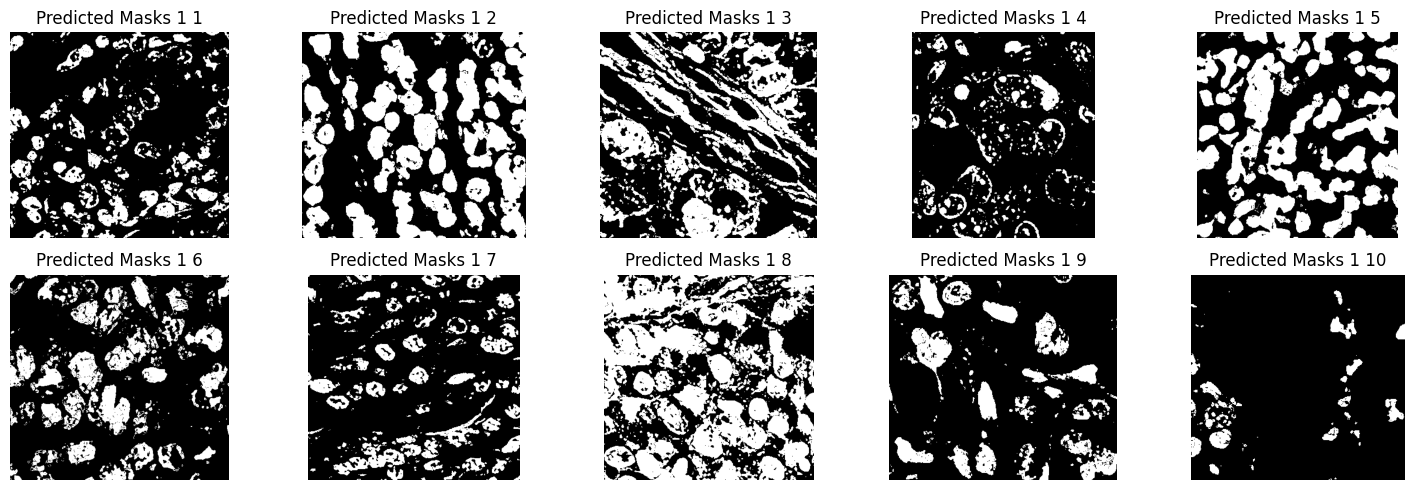

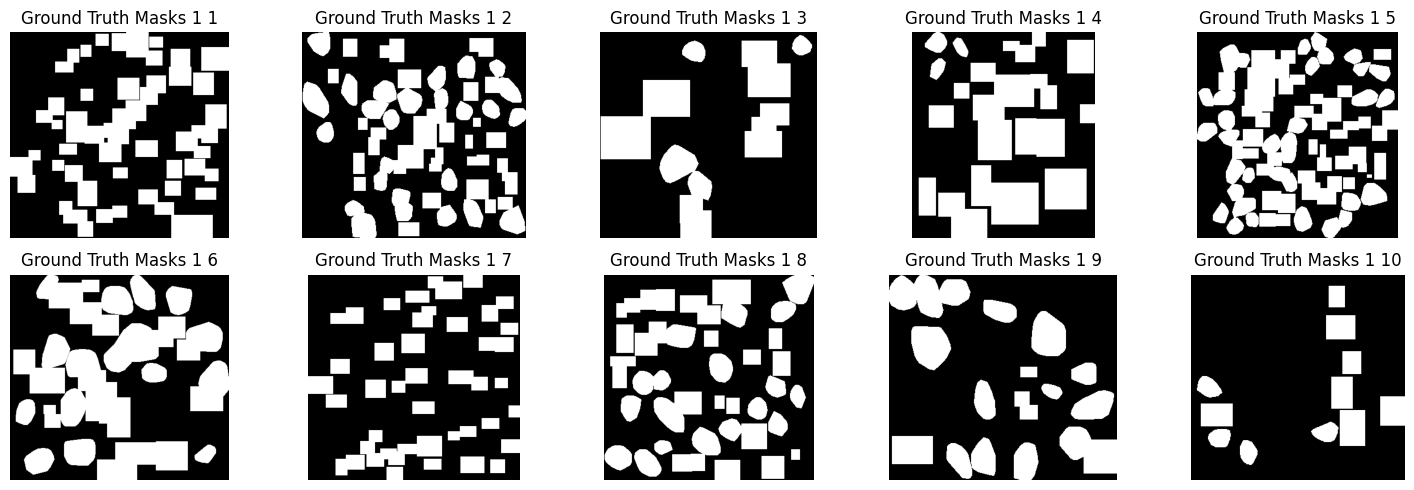

In [ ]:
# plot_images(Y_pred_masks[:10], title="Predicted Masks")
plot_images(Y_pred_masks[10:], title="Predicted Masks 1")

# Ground Masks
# plot_images(Y_truth_masks[:10], title="Ground Truth Masks")
plot_images(Y_truth_masks[10:], title="Ground Truth Masks 1")

In [ ]:
# Calculate avg,  max and min dice score
print(f"Average Dice Score: {np.mean(scores)}")
print(f"Max Dice Score: {max(scores)}")
print(f"Min Dice Score: {min(scores)}")

Average Dice Score: 0.5287771514957779
Max Dice Score: 0.7999159282135423
Min Dice Score: 0.047544097693351425


**Results For Optimized RF Classifier on Train Data**


---

Our final run with the optimized RF classifier produced an **average Dice coefficient of 52.9%**, with scores ranging from a **high of 79.99%** to a **low of just 4.75%**. This broad range suggests that while the model performs well on some images, it struggles significantly on others.

In **Section 4.2.4**, we will explore these inconsistencies further to identify what factors contribute to performance variability across images. We will also evaluate the model on the **validation set** to assess potential overfitting.


### 4.2.3 Validation Set Performance

**Validation Set Performance**


---

Performance on the validation set yielded an **average Dice score of 54.9%**, with a **maximum of 74.5%** and a **minimum of 33.0%**. These results are consistent with those from the training set, suggesting that the model is **not overfitting** and is generalizing well to unseen data.

A Dice score above 50% is a strong starting point for segmentation tasks. Visual inspection of the predicted masks supports this, as the model successfully captures key tumor regions in many cases.

In [ ]:
# Setting up validation set

# Take 50 images from the training set (or adjust size as needed)
random_indices = np.random.choice(len(validation_images), size=5, replace=False)

# Convert to greyscale each image
X_val_images = [cv2.cvtColor(validation_images[i], cv2.COLOR_RGB2GRAY) for
                  i in random_indices]

X_val_coords = [bounding_boxes_validate[i] for i in random_indices]
X_val_img_shape = [img.shape for img in X_val_images]  # Extract the shapes of each image

# Construct the segmentation masks
Y_val_masks = construct_mask(tumor_map, X_val_coords, X_val_img_shape, flatten=True)

# Reshape the masks
Y_val_reshaped_masks = [mask.reshape(img.shape[:2]) for mask, img in zip(Y_val_masks, X_val_images)]

# Prepare inputs for threading
image_mask_pairs = list(zip(X_val_images, Y_val_reshaped_masks))

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    results = list(executor.map(process_image, image_mask_pairs))

X_val = []
Y_val = []

# Collect and flatten results
for X_feature, Y_data in results:
    X_val.append(X_feature)
    Y_val += list(Y_data)

# Reshape X_train to 2D
X_val = np.vstack(X_val)
Y_val = np.array(Y_val)

print("X_train shape:", X_val.shape)
print("Y_train shape:", Y_val.shape)

X_train shape: (575583, 3)
Y_train shape: (575583,)


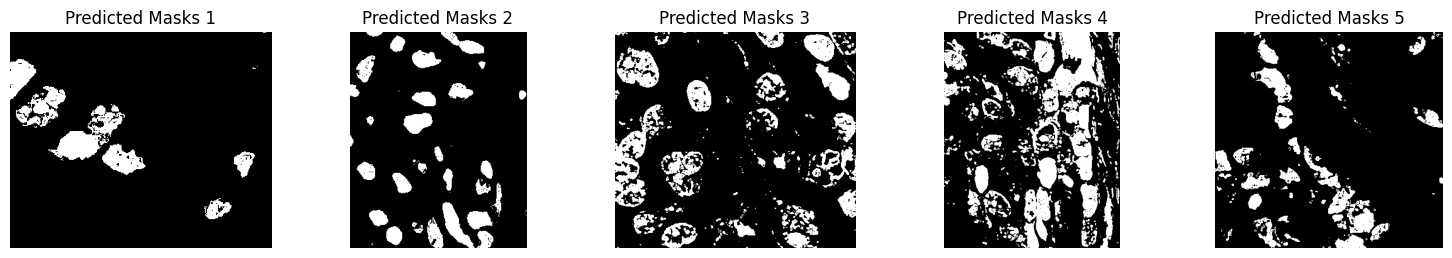

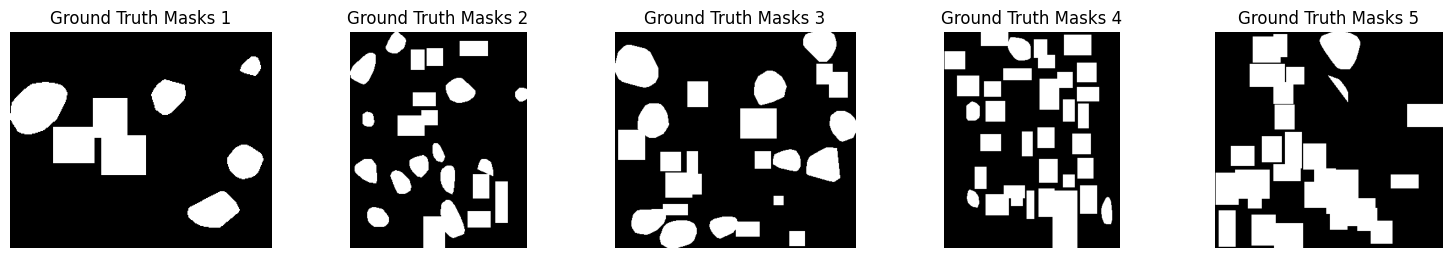

In [ ]:
# Reshape each mask into it's original size
Y_pred_val_masks = []
Y_truth_val_masks = []

counter = 0
scores = []
for shape in X_val_img_shape:
    # Convert 2D shape into 1D
    shape_1D = shape[0] * shape[1]
    Y_truth_val_masks.append(Y_val[counter:counter+shape_1D].reshape(shape[0], shape[1]))
    Y_pred_val_masks.append(best_rf_model.predict(X_val[counter:counter+shape_1D]).reshape(shape[0], shape[1]))
    counter += shape_1D

    # Calculate Dice Score
    score = dice_coefficient(Y_truth_val_masks[-1], Y_pred_val_masks[-1])
    scores.append(score)

# Visualize the images
plot_images(Y_pred_val_masks[:10], title="Predicted Masks")
plot_images(Y_truth_val_masks[:10], title="Ground Truth Masks")

In [ ]:
# Calculate avg,  max and min dice score
print(f"Average Dice Score: {np.mean(scores)}")
print(f"Max Dice Score: {max(scores)}")
print(f"Min Dice Score: {min(scores)}")

Average Dice Score: 0.5474656526066364
Max Dice Score: 0.6412142945468036
Min Dice Score: 0.4292789153875874


### 4.2.4 Performance of Supervised vs Unsupervised

**Supervised vs Unsupervised Segmentation**


---

In this section, we perform a **comparative analysis** between **supervised segmentation using Random Forests** and **unsupervised segmentation using K-means clustering**. We selected **three validation images** and evaluated the performance of each method against the ground truth masks.

- For the **supervised approach**, we used the **hypertuned Random Forest classifier** from Section 4.2.2 with the option of postprocessing by identifying rectangular contours and filling them in to better match the original ground truth

- For the **unsupervised approach**, we used the **optimized K-means setup** from Section 4.1, with **K=4** and a **confidence threshold of 0.9**.

This comparison allows us to assess how well each technique captures meaningful tumor structures and where one approach may outperform the other in terms of visual accuracy and Dice score overlap with the ground truth.



**Stastical Analysis**


---

In [ ]:
# Grab 5 images from validation set
random_indices = np.random.choice(len(X_val_images), size=5, replace=False)

# Grab 5 predicted masks and images from the previoys section
X_observe_images = [X_val_images[i] for i in random_indices]

# Ground truth masks
Y_truth_mask = [Y_val_reshaped_masks[i] for i in random_indices]
Y_truth_mask_binary= [Y_truth_val_masks[i] for i in random_indices]

# Random forest produced masks
Y_pred_supervised_masks = [Y_pred_val_masks[i] for i in random_indices]
Y_pred_supervised_dice = [scores[i] for i in random_indices]


# Perform K-means segmentation using helper function and record DICE
Y_pred_kmeans_masks = []
Y_pred_kmeans_contour = []

Y_pred_kmeans_dice = []
Y_pred_kmeans_contour_dice = []
for i, img in enumerate(X_observe_images):
    Y_pred_kmeans_masks.append(segementing_image(img, 4, 0.9, contouring=False))
    Y_pred_kmeans_contour.append(segementing_image(img, 4, 0.9, contouring=True))
    # plot the two masks
    Y_pred_kmeans_dice.append(dice_coefficient(Y_pred_kmeans_masks[-1], Y_truth_mask_binary[i]))
    Y_pred_kmeans_contour_dice.append(dice_coefficient(Y_pred_kmeans_contour[-1], Y_truth_mask_binary[i]))

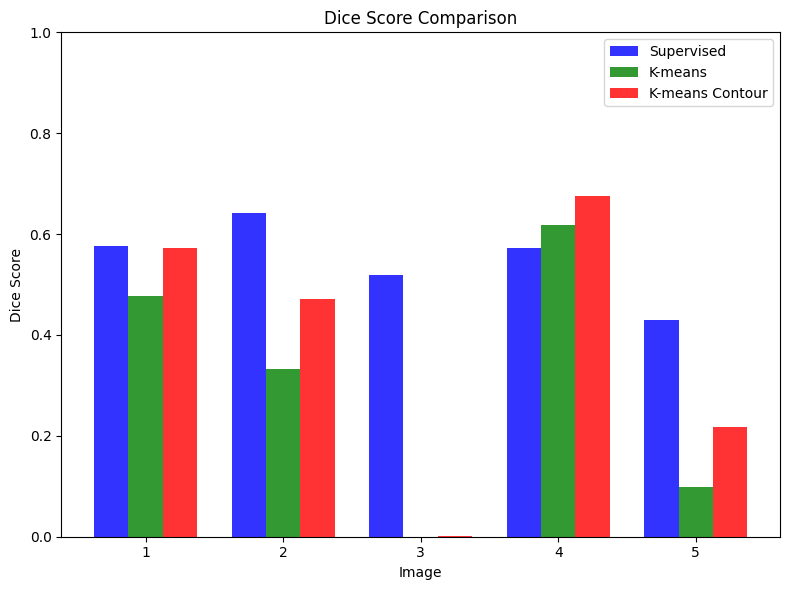

In [ ]:
# Bar chart
fig, ax = plt.subplots(figsize=(8, 6))
index = np.arange(len(Y_pred_supervised_dice))
bar_width = 0.25
opacity = 0.8

# Bar groups
rects1 = ax.bar(index, Y_pred_supervised_dice, bar_width,
                alpha=opacity, color='b', label='Supervised')
rects2 = ax.bar(index + bar_width, Y_pred_kmeans_dice, bar_width,
                alpha=opacity, color='g', label='K-means')
rects3 = ax.bar(index + 2 * bar_width, Y_pred_kmeans_contour_dice, bar_width,
                alpha=opacity, color='r', label='K-means Contour')

# Labels and title
ax.set_xlabel('Image')
ax.set_ylabel('Dice Score')
ax.set_title('Dice Score Comparison')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([f'{i + 1}' for i in range(len(Y_pred_supervised_dice))])
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Print average
print(f"Average Supervised Dice Score: {np.mean(Y_pred_supervised_dice)}")
print(f"Average K-means Dice Score: {np.mean(Y_pred_kmeans_dice)}")
print(f"Average K-means Contour Dice Score: {np.mean(Y_pred_kmeans_contour_dice)}")

Average Supervised Dice Score: 0.5474656526066364
Average K-means Dice Score: 0.3052402520065983
Average K-means Contour Dice Score: 0.3881486643823721


**Statistical Results**


---

The supervised Random Forest model outperformed both K-means and K-means with contours in three out of five test cases, achieving an average Dice score of 0.57. In comparison, K-means scored 0.3-0.4 on average, while K-means Contour achieved an average of 0.54.

The supervised approach showed greater stability, with Dice scores consistently ranging from 0.45 to 0.67, while K-means exhibited high variability, including scores near 0 on image 3. The Contour-enhanced version of K-means showed improved performance on images 2 and 4, even briefly outperforming the supervised method, but still lacked consistency.

**Visual Analysis**


---



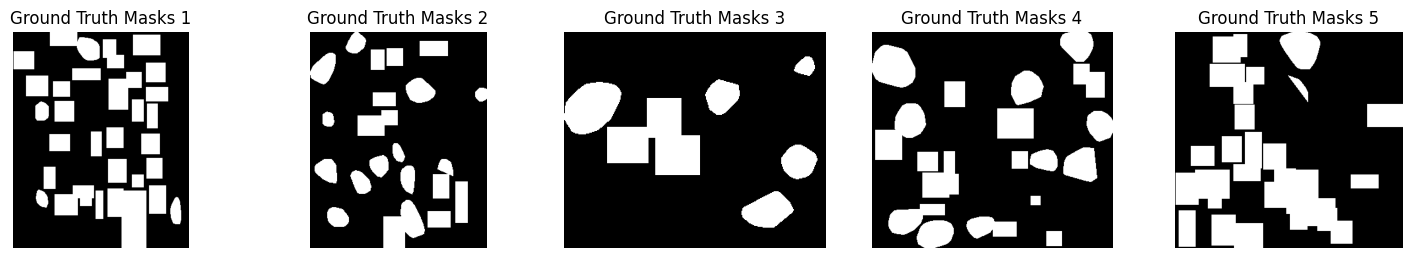

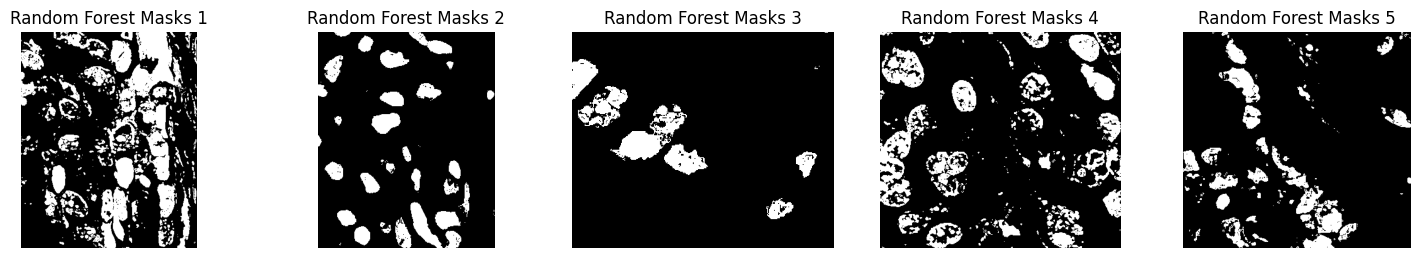

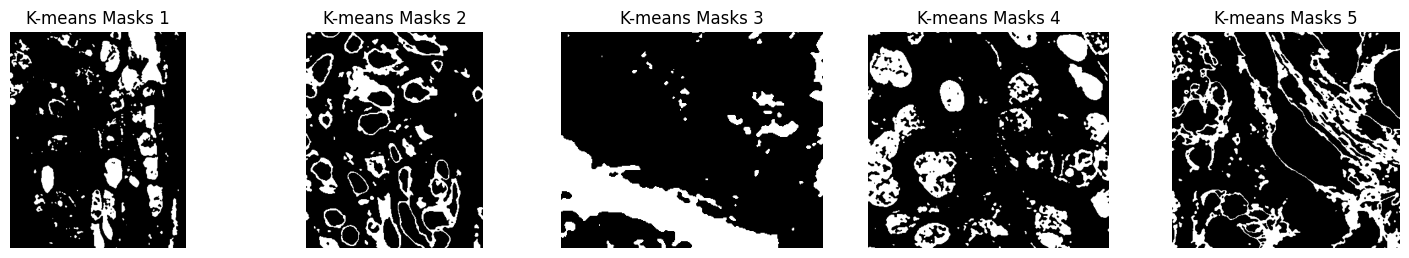

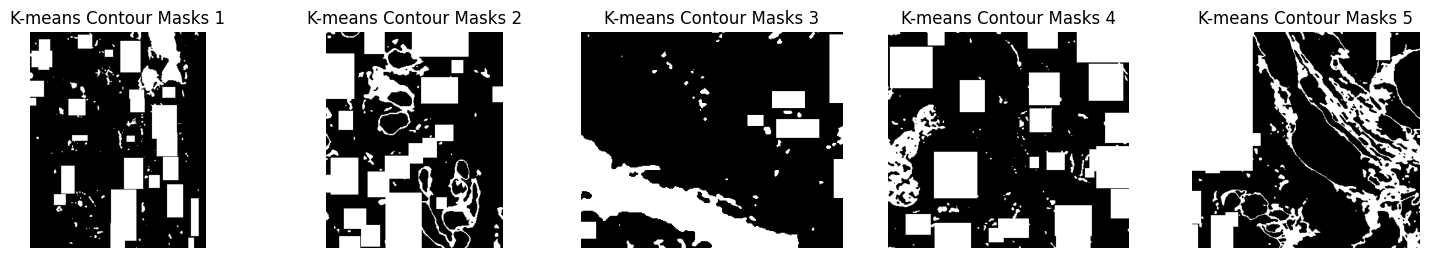

In [ ]:
# Plot the masks
plot_images(Y_truth_mask_binary, title="Ground Truth Masks")
plot_images(Y_pred_supervised_masks, title="Random Forest Masks")
plot_images(Y_pred_kmeans_masks, title="K-means Masks")
plot_images(Y_pred_kmeans_contour, title="K-means Contour Masks")

**Visual Results**


---

Our statistical results shows that the supervised Random Forest model achieved an average Dice score of 0.57 outperforming the K-means approach (0.36) and the custom K-means Contour (0.54). When analyzing the visual results we see that our statistical results are in compliance as when we visualized the segmentation masks, the supervised model produced clear, well-defined boundaries that closely match the ground truth. In contrast, both K-means methods yielded masks with noticeable inconsistencies: the raw K-means often resulted in patchy outputs, while the contour version still failed to capture the precise edges, leading to over or under segmentation in several cases.

The visual clarity and higher statistical result of the random forest confirms that its can produce accurate masks for tumor segmentation which is critical in biomedical applications.


### 4.2.5 Performance Metrics & Discussion

**Nuclei Segmentation Results**


---

Based on combined **Dice score analysis** and **visual inspection** across multiple test images, the following tumor types consistently show strong segmentation performance:

1. **Lymphocyte**
   - Highest Dice scores (e.g., 0.90+ in Image 6)
   - Visually clean and well-localized
   - Distinct round shapes make them easier to learn and detect

2. **Plasma Cell**
   - Dice scores range of 0.75–0.80
   - Well-detected with good overlap and shape preservation

3. **Unlabeled**
   - Consistently achieves Dice scores around 0.77
   - Reliable segmentation despite not being a biologically defined class

4. **Tumor**
   - Often segmented with high confidence (e.g., Dice ~0.85)
   - Visually prominent with strong contrast

5. **Apoptotic Body**
   - Limited presence in some images, but performs well when detected (Dice ~0.81)
   - Simple, small structures are segmented with surprising accuracy

6. **Vascular Endothelium**
   - Moderate-to-strong scores (Dice ~0.64)
   - Visually coarse but generally present in predictions

In [ ]:
# Observations made on [41 64 10 67 25 84 20 76 53 92] if run again use this
while True:
    # Take 6 images from the training set (or adjust size as needed)
    random_indices = np.random.choice(training_size, size=10, replace=False)
    random_indices = [41, 64, 10, 67, 25, 84, 20, 76, 53, 92]
    # Convert to greyscale each image

    X_observe_images = [X_train_images[i] for i in random_indices]
    X_observe_coords = [X_train_coords[i] for i in random_indices]
    X_observe_img_shape = [X_train_img_shape[i] for i in random_indices]

    Y_observe_mask = [Y_train_masks[i] for i in random_indices]
    Y_observe_mask_reshaped = [Y_train_reshaped_masks[i] for i in random_indices]

    Y_observe_pred = [Y_pred_masks[i] for i in random_indices]

    # Check if there are exactly 13 unique tumors in the train_masks
    if len(set(np.concat(Y_observe_mask))) == 12:
        break

In [ ]:
# Reverse the tumor_map to map intensity to label name
intensity_to_label = {v: k for k, v in tumor_map.items()}


# Loop through images and check what tumors are in each image
for i in range(len(Y_observe_mask_reshaped)):
    tumors = np.unique(Y_observe_mask_reshaped[i])
    # Get label names from pixel intensities
    tumor_keys = [intensity_to_label[tumor] for tumor in tumors if tumor in intensity_to_label]
    print(f"Image {i}: Tumor Labels - {tumor_keys}")



Image 0: Tumor Labels - ['unlabeled', 'fibroblast', 'lymphocyte']
Image 1: Tumor Labels - ['unlabeled', 'tumor', 'fibroblast', 'plasma_cell', 'mitotic_figure']
Image 2: Tumor Labels - ['fibroblast', 'lymphocyte', 'plasma_cell', 'ductal_epithelium']
Image 3: Tumor Labels - ['tumor', 'fibroblast', 'apoptotic_body']
Image 4: Tumor Labels - ['unlabeled', 'plasma_cell']
Image 5: Tumor Labels - ['tumor']
Image 6: Tumor Labels - ['unlabeled', 'fibroblast', 'lymphocyte', 'plasma_cell', 'vascular_endothelium', 'myoepithelium']
Image 7: Tumor Labels - ['unlabeled', 'fibroblast', 'plasma_cell']
Image 8: Tumor Labels - ['tumor', 'fibroblast', 'plasma_cell', 'macrophage']
Image 9: Tumor Labels - ['unlabeled', 'tumor']


**Nuclei Segmentation Analysis – Image 0**

We used a helper function to isolate each nuclei type from the ground truth mask and compare it with the predicted binary mask. This allows us to visually inspect what nuclei types were successfully segmented and which ones were missed.

**Nuclei Labels (Ground Truth):**  
For Image 0, the ground truth contains the following nuclei types:
'unlabeled', 'fibroblast', 'lymphocyte'


In [ ]:
tumors, gt_masks, p_masks, dice_s = get_masked_tumor_predictions(Y_observe_mask_reshaped[0], Y_observe_pred[0], tumor_map)


Each row in the mask grid corresponds to one nuclei type:
- **Mask 1** → Ground truth for unlabeled regions  
- **Masks 2–3** → Ground truth for fibroblast and lymphocyte

**Visual observations**:
- **Unlabeled regions (Mask 1)** are largely missed in the prediction, with minimal or no overlap, indicating poor detection.
- **Lymphocytes (Mask 3)** are captured more accurately. The predicted regions align closely with the ground truth blobs, showing strong localization and shape consistency.

**Statistical Observations:**
Higher Dice scores for **lymphocytes (~80%)** confirm that this class is segmented with greater reliability compared to others. This supports our visual assessment and highlights the model's consistent performance on this nuclei type.

In [ ]:
print(dice_s)

unlabeled: 0.1887
fibroblast: 0.3819
lymphocyte: 0.7979


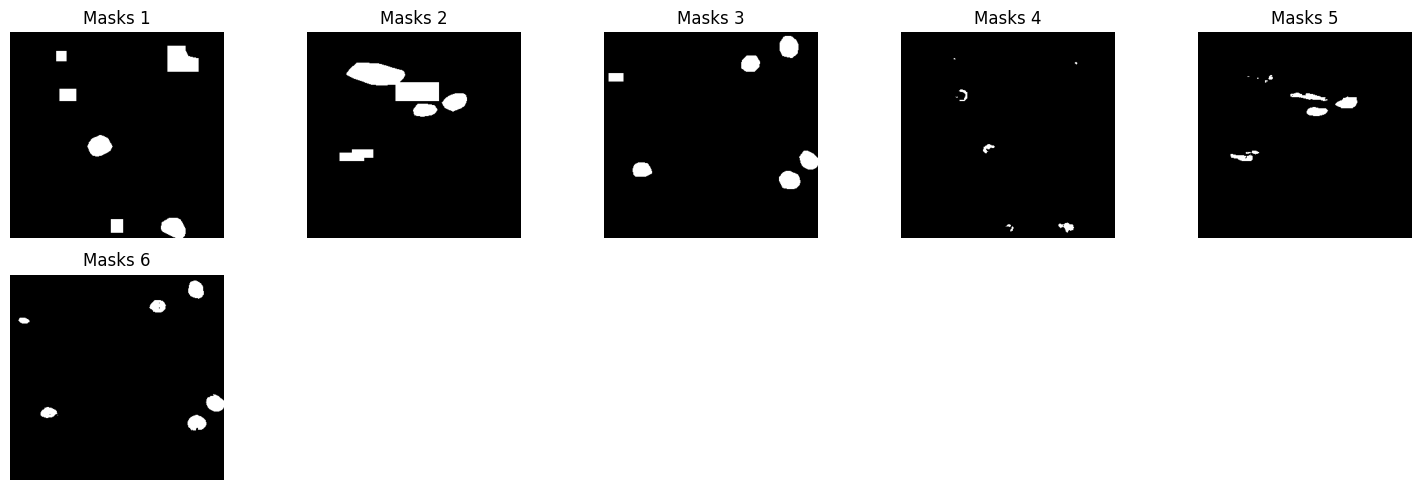

In [ ]:
plot_images(np.vstack([gt_masks, p_masks]), title="Masks")

**Nuclei Segmentation Analysis – Image 3**

After running our helper function to isolate per-class masks, only the following tumor types were detected in both the ground truth and prediction:

**Nuclei Labels (Ground Truth):**  
`['tumor', 'fibroblast', 'apoptotic_body']`


In [ ]:
tumors, gt_masks, p_masks, d_score = get_masked_tumor_predictions(Y_observe_mask_reshaped[3], Y_observe_pred[3], tumor_map)

**Visual Observations:**
- **Mask 1 (tumor):** Shows strong overlap between predicted and ground truth regions. Nuclei shapes are distinct and mostly preserved.
- **Mask 2 (fibroblast):** Predictions are partially aligned but show noticeable gaps. Some fibroblast regions are also missed.
- **Mask 3 (apoptotic_body):** Very sparse presence, but the one detected region matches the ground truth location.

**Dice Scores:**

In [ ]:
print(d_score)

tumor: 0.8556
fibroblast: 0.5338
apoptotic_body: 0.8148


These metrics validate what we observe visually:
- **Tumor segmentation is highly accurate** with 86% Dice Coefficeint.
- **Apoptotic body**, Limited in frequency, is segmented surprisingly well.
- **Fibroblast detection is moderate**, with missed and partial segments pulling down performance.



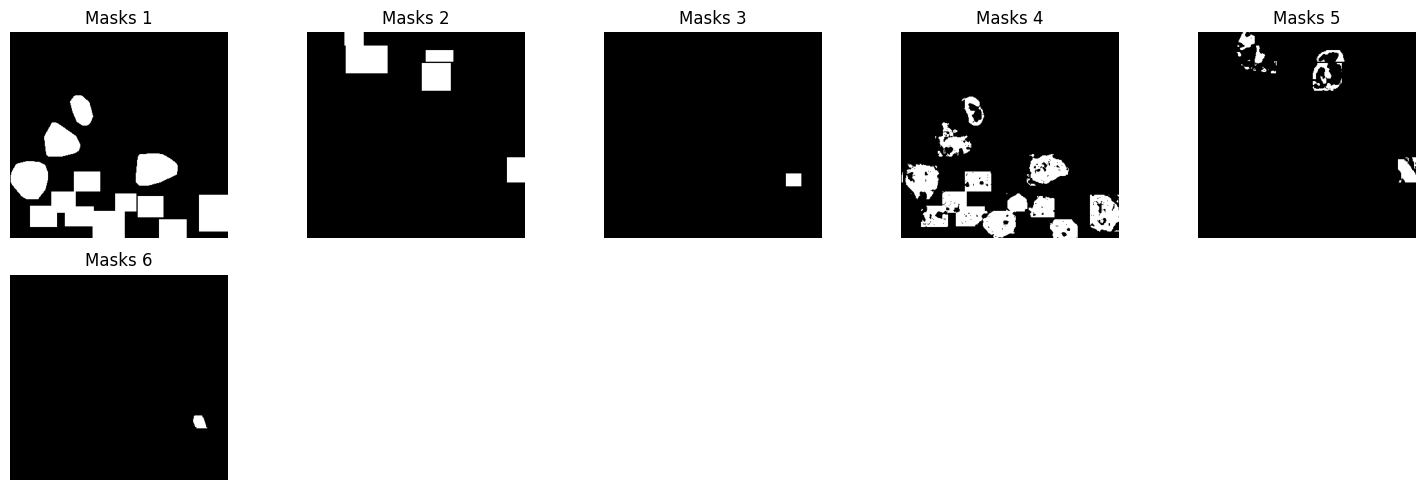

In [ ]:
plot_images(np.vstack([gt_masks, p_masks]), title="Masks")

**Nuclei Segmentation Analysis – Image 6**

**Nuclei Labels (Ground Truth):**  
`['unlabeled', 'fibroblast', 'lymphocyte', 'plasma_cell', 'vascular_endothelium', 'myoepithelium']`


In [ ]:
tumors, gt_masks, p_masks, dice_s = get_masked_tumor_predictions(Y_observe_mask_reshaped[6], Y_observe_pred[6], tumor_map)

- **Lymphocytes** achieved the highest Dice score (**~91%**), tracking with good performance seen in Image 0.
- **Plasma cells** and **unlabeled regions** also performed well, with Dice scores above **0.75**.
- **Fibroblasts** and **myoepithelium** showed lower accuracy (**~51–57%**), suggesting difficulty in segmenting irregular or fine-grained regions.
- **Vascular endothelium** sits mid-range, with room for improvement in structure preservation.

In [ ]:
print(dice_s)

unlabeled: 0.7777
fibroblast: 0.5189
lymphocyte: 0.9074
plasma_cell: 0.7674
vascular_endothelium: 0.6436
myoepithelium: 0.5776


**Visual Observations:**
- **Unlabeled:** Shows a few discrete structures that were generally well captured. Predicted regions align closely with the ground truth.
- **Fibroblast:** More complex and spatially spread. The prediction captures only a portion, missing some fine details and smaller shapes.
- **Lymphocyte:** Clean, round blobs are predicted accurately with very high overlap.
- **Plasma_cell:** Simple and well-localized shape, showing good agreement.
- **Vascular_endothelium:** Predicted regions seem coarsely aligned but suffer from some shape distortion and fragmentation.
- **Myoepithelium:** Sparse and partially matched; predicted mask misses part of the shape.

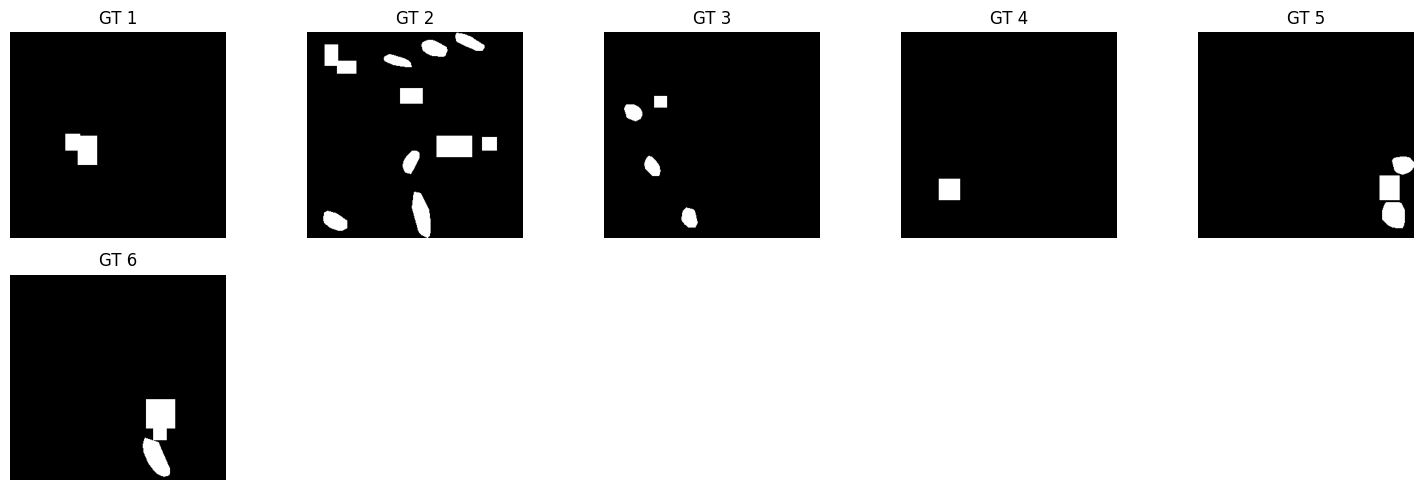

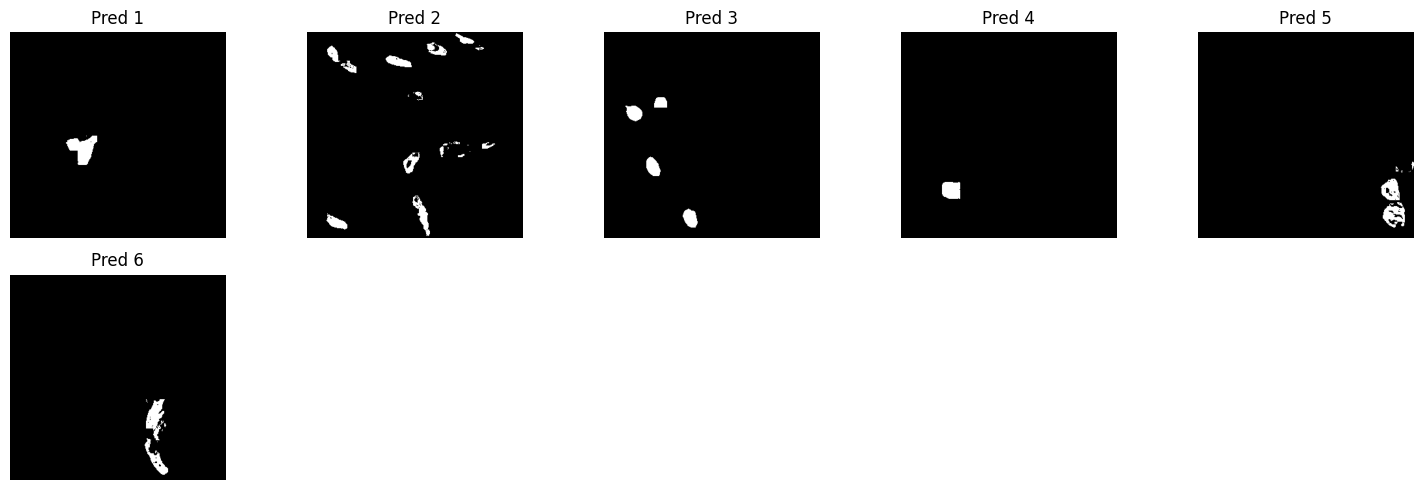

In [ ]:
plot_images(gt_masks, title="GT")
plot_images(p_masks, title="Pred")

### 4.2.6 Overall Discussion

**Why These Tumors Were Segmented Well**

The tumor types that achieved the best segmentation performance share several common traits that make them easier for the model to detect and learn. Below is a breakdown of the key reasons for their success:

1. **Lymphocyte**
- **Shape**: Small, round, and consistent across samples
- **Contrast**: High contrast with the background and other tissue types
- **Distribution**: Often well-distributed, avoiding crowding or overlap
- **Model Advantage**: Easy for the model to localize and differentiate due to distinct morphology

2. **Plasma Cell**
- **Structure**: Regular, oval-shaped with clear boundaries
- **Visual Distinction**: Separated spatially from similar cells
- **Reinforcement in Training**: Frequently seen in the dataset, likely giving the model more examples to learn from

3. **Unlabeled**
- **Representation**: Broadly includes background or undefined classes, often forming large blocks
- **Visual Simplicity**: Easy to segment due to uniform shapes and low intra-class variation
- **Dice Boost**: Large surface area leads to higher overlap scores when predicted correctly

4. **Tumor**
- **Salience**: Visually prominent with strong contrast from surrounding tissue
- **Size**: Larger than other cells, offering more learning signal
- **Distinctiveness**: Unique structure helps the model distinguish them easily

# 5) Detecting and Counting Tumors

## 5.1 Preparing the data

---

Here, we want to prepare the data for our detection task. We split these parts into 4 major parts, preprocessing, feature extraction, hypertuning, and training.

Firstly, preprocessing is done by firstly converting the images in the dataset and their masks to graysscale, and resizing them to the same size (the min width and height of the pair of images). As there are over 1700 images, this will take a long time, so we use multiprocessing to speed up the process to convert the images in parallel. Next, to avoid extra computation every time we want to train, we cached the images and masks using pickle. This allows us to load the images and masks from the cache instead of having to convert them every time we want to train.

Next, once the images are standardized, we will extract the features using radiomics, which is the process of extracting large amounts of quantitative features from medical related images. We decided to use this method of feature extraction over other methods such as HOG or SIFT because radiomics captures a wider range of meaningful features, including intensity, shape, and texture, that are especially suited for tumour detection. It provides a more comprehensive and clinically relevant representation of each region of interest.

Next, we are told to train a SVM classifier. We decided to use a rbf kernel for our SVM classifier because it is a non-linear kernel that can capture complex relationships in the data. The RBF kernel is particularly effective for high dimensional data, which is the case here with radiomics features. It allows the SVM to create a decision boundary that can adapt to the underlying structure of the data, making it suitable for our task of detecting and classifying tumours. To select the best parameters for our SVM classifier, we used a grid search to find the best parameters for our model. We used a grid search because it is a simple and effective way to find the best parameters for our model. It works by training the model with all combinations of the parameters in the grid and selecting the best one based on the performance of the model.

Finally, we trained our SVM classifier using the best parameters found in the grid search. To do so, we first normalize our data to ensure that no feature dominates the others. We also noticed heavy class imbalance, and in order to soften the imbalance, used KMeansSMOTE to oversample the minority classes. This method works by using KMeans to cluster the data and then oversampling the minority classes based on the clusters. This allows us to create synthetic samples that are similar to the minority classes, which helps to balance the dataset and improve the performance of our model.

### 5.0.1 Setup Grayscale Processing Structure

---

Firstly, images are converted to grayscale to simplify processing and to allow the feature extraction to focus on the shape, intensity, and texture of pathological structures like tumors. Radiomics features are primarily based on pixel intensity distributions and spatial patterns, rather than color information. Converting to grayscale helps remove variability introduced by staining and color artifacts in histopathology images, making the features extracted more consistent.

#### Setup Variables

In [ ]:
FORCE = False
lock = threading.Lock()
pool = ThreadPoolExecutor()

# create output directories if they don't exist
os.makedirs(os.path.join(path, 'gray'), exist_ok=True)
os.makedirs(os.path.join(path, 'mask_gray'), exist_ok=True)

gray = os.listdir(path + 'gray')
mask_gray = os.listdir(path + 'mask_gray')

# reuse paths, file lists, and vars from previous cells
rgb = os.listdir(path + 'rgb')
mask = os.listdir(path + 'mask')
splits = os.listdir(path + 'splits')
csv = os.listdir(path + 'csv')

train_file = os.path.join(path, 'splits', 'train_subjects.csv')
validate_file = os.path.join(path, 'splits', 'validate_subjects.csv')

data = {
    'train': open(train_file, 'r').read().split("\n"),
    'validate': open(validate_file, 'r').read().split("\n")
}

# image_mask_no_bg: is the resultant image after removing the background
keys = ['image', 'mask', 'image_mask', 'image_mask_no_bg']
grayscaled = {base_img: {key: [] for key in keys} for base_img in data['train'] + data['validate']}

#### Setup Functions

In [ ]:
def load_grayscale(image_path):
    return cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

def apply_mask(image, mask):
    return mask * image

def remove_background(image, mask):
    """
    red (76 after grayscale) is the unwanted background

    but it gets set to 1, so we invert [0, 1] -> [1, 0]
    """
    binary_mask = (mask == 76).astype('uint8')
    return (1 - binary_mask) * image

def get_image_type(image_path, grayscale_image):
    return {
        'path': image_path,
        'img': grayscale_image
    }

def process_image(file_name, index, total):
    # get the paths of the image and mask
    rgb_path = os.path.join(path, 'rgb', file_name)
    mask_path = rgb_path.replace('rgb', 'mask')

    # convert the images to grayscale
    img = load_grayscale(rgb_path)
    mask_img = load_grayscale(mask_path)

    if img is None or mask_img is None:
        with lock:
            print(f"Failed to read image or mask for {file_name}. Skipping.")
        return

    # resize to smallest image size
    min_h = min(img.shape[0], mask_img.shape[0])
    min_w = min(img.shape[1], mask_img.shape[1])
    img = img[:min_h, :min_w]
    mask_img = mask_img[:min_h, :min_w]

    # get the relative path of the image and mask
    out_img_path = os.path.join('gray', file_name)
    out_mask_path = os.path.join('mask_gray', file_name)

    # as its threaded, we use a lock to append the images and mask in the same order
    with lock:
        base_img = file_name.split('_')[0]
        grayscaled[base_img]['image'].append(get_image_type(out_img_path, img))
        grayscaled[base_img]['mask'].append(get_image_type(out_mask_path, mask_img))

    # write the images and masks to disk
    cv2.imwrite(out_img_path, img)
    cv2.imwrite(out_mask_path, mask_img)

    if (index + 1) % 100 == 0:
        print(f"Completed image {index + 1}/{total}")

**Load Grayscaled Images**

---

To reduce image loading time, we cached the grayscale images using a pickle file. This allowed us to compute the grayscale versions only once and quickly load them from the cache in future runs.

In [ ]:
# if grayscale pickle file exists, load it
GRAYSCALED_PICKLE = os.path.join(CACHE_PATH, 'grayscaled.pkl')
if FORCE or not os.path.exists(GRAYSCALED_PICKLE):
    print(f"Grayscaled images not found. Processing images...")
    total_files = len(rgb)
    with ThreadPoolExecutor() as executor:
        futures = []
        for idx, file in enumerate(rgb):
            futures.append(executor.submit(process_image, file, idx, total_files))

        for future in futures:
            future.result()

    # store grayscaled images to cache
    with open(GRAYSCALED_PICKLE, 'wb') as f:
        pickle.dump(grayscaled, f)
else:
    print(f"Loading grayscaled images from cache...")
    with open(GRAYSCALED_PICKLE, 'rb') as f:
        grayscaled = pickle.load(f)

Loading grayscaled images from cache...


### **5.1.1–5.1.3 Preprocessing: Grayscale Conversion, ROI Extraction, and Noise Removal**

---

Next, we compute the grayscale images and extract their regions of interest (ROIs) by applying the corresponding masks. This isolates the relevant areas where feature extraction is performed.

In [ ]:
start_time = time.time()
for base_img in grayscaled.keys():
    for i in range(len(grayscaled[base_img]['image'])):
        img = grayscaled[base_img]['image'][i]['img']
        mask = grayscaled[base_img]['mask'][i]['img']

        img_path = grayscaled[base_img]['image'][i]['path']

        img_mask = apply_mask(img, mask)
        grayscaled[base_img]['image_mask'].append(get_image_type(img_path, img_mask))
        grayscaled[base_img]['image_mask_no_bg'].append(get_image_type(img_path, remove_background(img_mask, mask)))
print(f"completed image conversion in time: {time.time() - start_time} seconds")

completed image conversion in time: 0.975837230682373 seconds


#### Example Usage

subject name TCGA-LL-A73Y-DX1 and index 0
gray/TCGA-LL-A73Y-DX1_id-5ea40b1cddda5f8398998a1e_left-68619_top-49680_bottom-49967_right-68902.png
mask_gray/TCGA-LL-A73Y-DX1_id-5ea40b1cddda5f8398998a1e_left-68619_top-49680_bottom-49967_right-68902.png


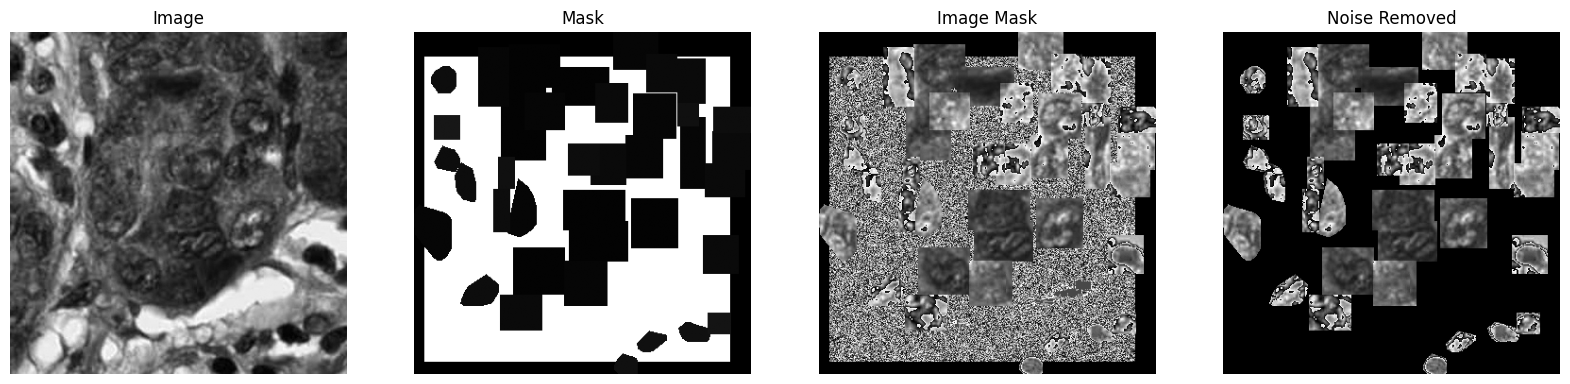

In [ ]:
subject_name = random.choice(list(grayscaled.keys()))
img_index = 0

print(f"subject name {subject_name} and index {img_index}")

print(grayscaled[subject_name]['image'][img_index]['path'])
print(grayscaled[subject_name]['mask'][img_index]['path'])

# retrieve the images
img = grayscaled[subject_name]['image'][img_index]['img']
mask = grayscaled[subject_name]['mask'][img_index]['img']
img_mask = grayscaled[subject_name]['image_mask'][img_index]['img']
noise_removed = grayscaled[subject_name]['image_mask_no_bg'][img_index]['img']

# Plot image, mask, image_mask, noise_removed
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Image')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(img_mask, cmap='gray')
ax[2].set_title('Image Mask')
ax[2].axis('off')

ax[3].imshow(noise_removed, cmap='gray')
ax[3].set_title('Noise Removed')
ax[3].axis('off')

plt.show()

###  5.1.4 + 5.1.6–5.1.7 Tumor Blob Analysis & Label Mapping

**Feature Extraction Parameters**

---

Radiomics is the process of extracting large amounts of quantitative features from medical images, turning visual patterns into numerical data that can help detect and classify diseases like tumors. These features are grouped into categories based on what they measure. Overall, each ROI has a total of 93 features, which are divided into the following categories:

First order features describe the overall intensity distribution of the pixels in the region of interest. They include statistics like mean, variance, entropy, skewness, and kurtosis. These features give insight into how bright, uniform, or varied a region is, which helps differentiate tissue types.

GLCM (Gray Level Co-occurrence Matrix) features capture how often pairs of pixel intensities occur together, revealing local texture patterns like smoothness or roughness. Features such as contrast, correlation, and homogeneity help characterize the internal texture of a region, which is especially useful for identifying subtle structural differences in tumors.

GLRLM (Gray Level Run Length Matrix) features describe the lengths of consecutive runs of pixels with the same intensity. Metrics like long run emphasis or short run emphasis reveal whether textures are coarse or fine, helping distinguish dense tumor tissue from surrounding structures.

GLSZM (Gray Level Size Zone Matrix) features measure the size of connected zones with the same gray level. They provide information on the size distribution of texture zones, helping detect large, uniform tumor areas versus more fragmented regions.

GLDM (Gray Level Dependence Matrix) features look at how many neighboring pixels depend on a central pixel’s intensity. This reflects local texture strength and complexity, adding another layer of detail to differentiate between tumor and non-tumor areas.

NGTDM (Neighborhood Gray Tone Difference Matrix) features quantify the difference between a pixel and the average of its neighborhood. Though most of these values are zero here as the images are grayscale, features like coarseness and complexity typically reflect broader texture patterns and granularity in tissues.

#### Variable Setup

In [ ]:
class_mappings = {
    'tumor': 0,
    'unlabeled': 1,
    'apoptotic_body': 2,
    'plasma_cell': 3,
    'fibroblast': 4,
    'mitotic_figure': 5,
    'lymphocyte': 6,
    'ductal_epithelium': 7,
    'macrophage': 8,
    'vascular_endothelium': 9,
    'eosinophil': 10,
    'neutrophil': 11,
    'myoepithelium': 12,
}

# disable logging
logger = radiomics.logger
logger.setLevel(logging.ERROR)

lock_XY = threading.Lock()
lock_grayscaled = threading.Lock()

In [ ]:
params = {
    "binWidth": 5,
    "normalize": True,
    "normalizeScale": 1,
    "resampledPixelSpacing": [0.2, 0.2],
    "interpolator": "sitkBSpline",
    "preCrop": True,
    "force2D": True,
    "force2Ddimension": 0,
    "padDistance": 3,
    "resegmentRange": [0, 255],
    "voxelArrayShift": 0,
}

**Feature Extraction Functions**

---

Now we extract the features from each window of interest, we loop through each image in the dataset, load its corresponding grayscale image with the background removed, and retrieve the annotation CSV file that contains coordinates for each labeled region (e.g., tumor, plasma cell). For each region, we check if it forms a valid closed shape and has a sufficient area (at least 5 pixels). We then create a binary mask for the region. Using PyRadiomics with the predefined parameters, we extract radiomics features from each region of interest. These features are stored in `X`, their corresponding class labels (e.g., tumor vs non-tumor) in `Y`, and the image names in `labels`. We also keep track of how many valid tumor regions are found per image to use later for evaluating RMSE. The process is parallelized using a thread pool to speed up extraction across all images in the training or validation set.

In [ ]:
def read_csv(csv_path):
    return pd.read_csv(csv_path, index_col="Unnamed: 0")

def extract_features(idx, total_idx, subject_name, img_index):
    X = []
    Y = []
    labels = [] # stores the image name to compare with the count

    extractor = featureextractor.RadiomicsFeatureExtractor(**params)

    csv_loc = os.path.join(path, grayscaled[subject_name]['image'][img_index]['path'])
    csv_loc = csv_loc.replace(".png", ".csv").replace("/gray", "/csv")

    # print(grayscaled[subject_name]['image_mask_no_bg'])
    img = cp.deepcopy(grayscaled[subject_name]['image_mask_no_bg'][img_index]['img'])
    img_sitk = sitk.GetImageFromArray(img)

    csv = read_csv(csv_loc)

    invalids = 0

    for row in csv.iterrows():
        row = row[1]

        # collect x and y coordinates
        x = list(map(int, row.coords_x.split(",")))
        y = list(map(int, row.coords_y.split(",")))

        # ensure outline is closed off
        if x[0] != x[-1] or y[0] != y[-1]:
            x.append(x[0])
            y.append(y[0])

        # group x, y into (x, y) tuples
        coords = list(zip(x, y))

        # if area is less than 5, skip
        # FIX FOR: https://mycourses2.mcgill.ca/d2l/le/757998/discussions/threads/1612165/ViewPostInContext?postId=3002783#post3002783
        area = cv2.contourArea(np.array(coords))
        if area < 5:
            print(f"Invalid of type {row.type} with area {area} found at {subject_name}-{img_index}, skipping...")

            if row.raw_classification == 'tumor': invalids += 1
            continue

        # create a binary mask
        mask = np.zeros_like(img)
        cv2.fillPoly(mask, [np.array(coords)], 1)

        mask_sitk = None
        features = None
        if np.count_nonzero(mask):
            mask_sitk = sitk.GetImageFromArray(mask, sitk.sitkUInt8)
            features = extractor.execute(img_sitk, mask_sitk)   # extract features

        with lock_XY:
            feature = []
            # save the extracted features
            for key, value in features.items():
                if "diagnostics_" in key:
                    continue
                feature.append(value)

            X.append(feature)
            Y.append(class_mappings[row.raw_classification])
            labels.append(os.path.basename(csv_loc).replace(".csv", ""))

    with lock_grayscaled:
        classes = np.unique(csv.raw_classification, return_counts=True)
        counts = dict(zip(classes[0], classes[1]))

        # count the number of tumor classes minus the invalids
        grayscaled[subject_name]['count'] = counts['tumor'] - invalids if 'tumor' in counts else 0

    print(f"Completed image {idx + 1}/{total_idx}")

    return X, Y, labels

def get_features_and_labels(subset):
    start_time = time.time()

    futures = []
    n = len(subset)
    for i, subject_name in enumerate(subset):
        num_images = len(grayscaled[subject_name]['image'])
        for img_index in range(num_images):
            future = pool.submit(extract_features, i, n, subject_name, img_index)
            futures.append(future)

    X_final = []
    Y_final = []
    labels_final = []
    for future in as_completed(futures):
        try:
            X, Y, L = future.result()
            X_final.extend(X)
            Y_final.extend(Y)
            labels_final.extend(L)
        except Exception as e:
            print(f"Error in future: {e}")

    print(f"Completed feature extraction in {time.time() - start_time:.2f} seconds.")

    return X_final, Y_final, labels_final


# example usage
subject = random.choice(list(grayscaled.keys())) #"TCGA-AR-A0U4-DX1"
print(subject)
X, Y, labels = extract_features(0, 0, subject, 0)
print(labels)

count = grayscaled[subject]['count']
print(f"count: {count}")

TCGA-E2-A1L7-DX1
Completed image 1/0
['TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5ea40ae5ddda5f8398995967_left-52300_top-18743_bottom-19007_right-52589', 'TCGA-E2-A1L7-DX1_id-5

### 5.1.8 Peform Previous Functions on All Train & Validation Subjects

In [ ]:
sets = list(grayscaled.keys())

train_file = path + 'splits/train_subjects.csv'
validate_file = path + 'splits/validate_subjects.csv'

print(f"train file: {train_file}")
print(f"validate file: {validate_file}")

CACHE_X_TRAIN = os.path.join(CACHE_PATH, 'X_train.pkl')
CACHE_Y_TRAIN = os.path.join(CACHE_PATH, 'Y_train.pkl')
CACHE_LABELS_TRAIN = os.path.join(CACHE_PATH, 'labels_train.pkl')

if FORCE or not os.path.exists(CACHE_X_TRAIN) or not os.path.exists(CACHE_Y_TRAIN) or not os.path.exists(CACHE_LABELS_TRAIN):
    print(f"Features not found. Extracting features...")
    train_base_imgs = pd.read_csv(train_file, header=None)[0].tolist()[:]
    X_tr, Y_tr, labels_tr = get_features_and_labels(train_base_imgs)

    with open(CACHE_X_TRAIN, 'wb') as f:        pickle.dump(X_tr, f)
    with open(CACHE_Y_TRAIN, 'wb') as f:        pickle.dump(Y_tr, f)
    with open(CACHE_LABELS_TRAIN, 'wb') as f:   pickle.dump(labels_tr, f)
else:
    print(f"Loading features from cache...")
    with open(CACHE_X_TRAIN, 'rb') as f:        X_tr = pickle.load(f)
    with open(CACHE_Y_TRAIN, 'rb') as f:        Y_tr = pickle.load(f)
    with open(CACHE_LABELS_TRAIN, 'rb') as f:   labels_tr = pickle.load(f)

train file: /content/drive/MyDrive/ECSE 415/splits/train_subjects.csv
validate file: /content/drive/MyDrive/ECSE 415/splits/validate_subjects.csv
Loading features from cache...


**Repeat the steps mentioned above, to loop over all the images for the subjects in `validate_subjects.csv`**

In [ ]:
CACHE_X_VAL = os.path.join(CACHE_PATH, 'X_val.pkl')
CACHE_Y_VAL = os.path.join(CACHE_PATH, 'Y_val.pkl')
CACHE_LABELS_VAL = os.path.join(CACHE_PATH, 'labels_val.pkl')

if FORCE or not os.path.exists(CACHE_X_VAL) or not os.path.exists(CACHE_Y_VAL) or not os.path.exists(CACHE_LABELS_VAL):
    val_base_imgs = pd.read_csv(validate_file, header=None)[0].tolist()[:]
    X_val, Y_val, labels_val = get_features_and_labels(val_base_imgs)

    with open(CACHE_X_VAL, 'wb') as f:        pickle.dump(X_val, f)
    with open(CACHE_Y_VAL, 'wb') as f:        pickle.dump(Y_val, f)
    with open(CACHE_LABELS_VAL, 'wb') as f:   pickle.dump(labels_val, f)
else:
    with open(CACHE_X_VAL, 'rb') as f:        X_val = pickle.load(f)
    with open(CACHE_Y_VAL, 'rb') as f:        Y_val = pickle.load(f)
    with open(CACHE_LABELS_VAL, 'rb') as f:   labels_val = pickle.load(f)

### 5.1.5 Build Binary Tumor Classifier

**Setup Training and Validation Data & Variables**

---

Next, we prepare the training data for classification by handling class imbalance using SMOTE (Synthetic Minority Oversampling Technique).

First, it defines a minimum sample threshold as 20% of the average number of samples per class. It then builds a sampling strategy, only classes that meet this threshold and are not the majority class are selected for oversampling. For those selected classes, their sample count is increased (up to the maximum class size) using synthetic examples. This helps balance the training data so that minority classes aren’t underrepresented during model training.

In [ ]:
X_train = np.array(cp.deepcopy(X_tr))
Y_train = np.array(cp.deepcopy(Y_tr))
X_validate = np.array(cp.deepcopy(X_val))
Y_validate = np.array(cp.deepcopy(Y_val))

# only use 10k training samples
# X_train, Y_train = resample(X_train, Y_train, n_samples=10000, random_state=SEED, stratify=Y_train)

# choose classes with >=20% of the avg number of samples
min_samples = int(0.2 * np.mean(list(Counter(Y_train).values())))
class_counts = Counter(Y_train)
max_samples = max(class_counts.values())

sampling_strategy = {
    label: count for label, count in class_counts.items()
    if count >= min_samples and count != max(class_counts.values())  # skip majority class
}

# take the 1.2 * original or half of max the sameples.
for k in sampling_strategy:
    sampling_strategy[k] = int(min(1.5 * sampling_strategy[k], max(0.5 * max_samples, sampling_strategy[k])))

print(f"min_samples: {min_samples}")
print(f"max_samples: {max_samples}")
print("Applying SMOTE to:", sampling_strategy)

min_samples: 715
max_samples: 17170
Applying SMOTE to: {np.int64(1): 8541, np.int64(4): 8585, np.int64(6): 10351, np.int64(8): 1641, np.int64(3): 6462}


**Class Distributions**

---

The decision to apply partial oversampling, as shown in the graph comparing class distributions before and after sampling, is driven by the need to balance representational fairness with data quality. Fully balancing all classes by oversampling would risk overfitting to synthetic data, especially in the case of extremely rare classes like myoepithelium or neutrophil, where synthetic samples may not capture true biological variability.

Moreover, generating a large number of synthetic examples for underrepresented classes can lead to unreliable or noisy data, degrading model performance. Partial oversampling instead brings minority classes closer to the majority distribution (e.g., increasing fibroblast and plasma_cell counts), while keeping dominant classes like tumor and lymphocyte mostly untouched. This approach preserves the natural skew found in the original data, preventing artificial distortion of class frequencies and maintaining biological plausibility, while still addressing imbalance enough to improve model learning.

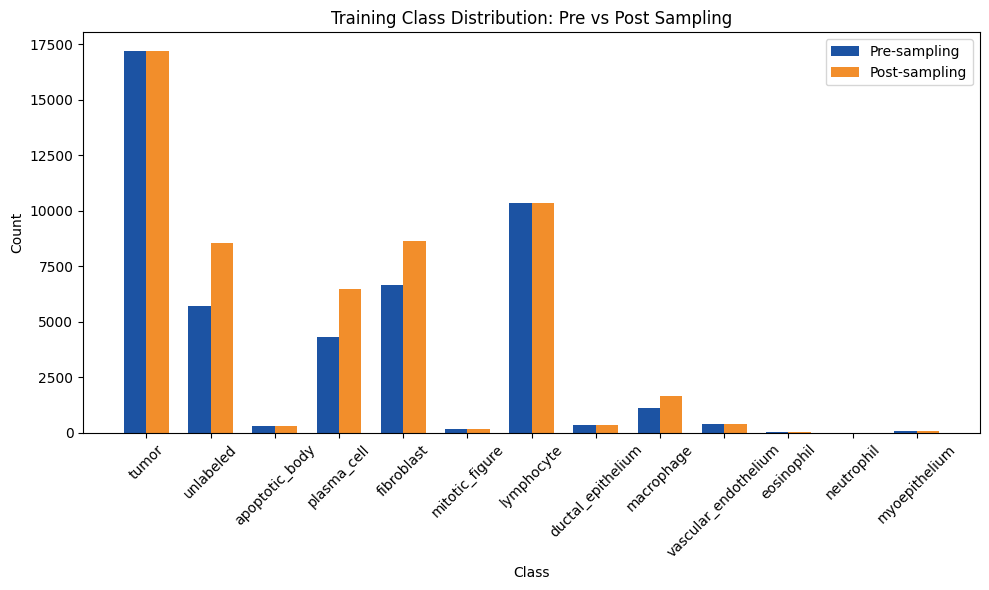

In [ ]:
# SMOTE and then plot the distribution
ksmote = KMeansSMOTE(
    sampling_strategy=sampling_strategy,
    random_state=SEED,
    k_neighbors=25,
    cluster_balance_threshold=0.05,
    kmeans_estimator=36
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_resampled, Y_train_resampled = ksmote.fit_resample(X_train_scaled, Y_train)

# compute class counts from the original training labels
all_labels = np.unique(np.concatenate((Y_validate, Y_train)))
label_mapping = {v: k for k, v in class_mappings.items()}
target_names = [label_mapping[label] for label in all_labels]

train_counts_original = Counter(Y_train)
sorted_classes_original = sorted(train_counts_original.keys())
sorted_counts_original = [train_counts_original[k] for k in sorted_classes_original]
class_names_original = [label_mapping[k] for k in sorted_classes_original]

# compute class counts from the resampled training labels
train_counts_resampled = Counter(Y_train_resampled)
sorted_classes_resampled = sorted(train_counts_resampled.keys())
sorted_counts_resampled = [train_counts_resampled[k] for k in sorted_classes_resampled]
class_names_resampled = [label_mapping[k] for k in sorted_classes_resampled]

labels = class_names_original  # assuming same class order for both distributions
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, sorted_counts_original, width, label='Pre-sampling', color='#1c53a3')
ax.bar(x + width/2, sorted_counts_resampled, width, label='Post-sampling', color='#f28e2b')

ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Training Class Distribution: Pre vs Post Sampling")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


**Training Class Weights**

---

We next set the class weights, which adjust the importance of each class during model training to handle class imbalance. A higher class weight means the model will pay more attention to that class, helping prevent it from being ignored due to fewer samples. Conversely, a lower weight means the class has plenty of samples and needs less emphasis.

As well, by setting the tumor class weight to 1.2, we deliberately prioritize detecting tumors, even if it increases the number of false positives. Ethically, this is justified because a false negative, failing to detect a tumor, could lead to a missed diagnosis and delayed treatment, which is far more harmful than a false alarm that can be followed up with additional testing. In medical applications, it's often safer to err on the side of caution to avoid life threatening oversights.

In [ ]:
class_weights = {
    0: 1.2,  # tumor
    1: 1.0,  # unlabeled
    2: 1.0,  # apoptotic_body
    3: 1.0,  # plasma_cell
    4: 1.0,  # fibroblast
    5: 1.0,  # mitotic_figure
    6: 0.8,  # lymphocyte
    7: 1.0,  # ductal_epithelium
    8: 1.0,  # macrophage
    9: 1.0,  # vascular_endothelium
    10: 1.0, # eosinophil
    11: 1.0, # neutrophil
    12: 1.0  # myoepithelium
}

Grid Search

---

Grid search was initially used to find the best combination of hyperparameters for a machine learning model. It works by exhaustively trying all possible combinations of specified parameter values and evaluating the model's performance using cross-validation for each combination. In this case, the model's performance is assessed across different values of `C` (regularization strength) and `gamma` (kernel coefficient) to identify which settings yield the best accuracy. The best performing combination is then selected and used to train the final model.

In [ ]:
#""" GRID SEARCH
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

svc = SVC(
    class_weight=class_weights,
    probability=True,
    verbose=True,
    cache_size=1000
)

X_train_GS, Y_train_GS = resample(X_train, Y_train, n_samples=1000, random_state=SEED, stratify=Y_train)

# standardize the data
scaler = StandardScaler()
X_train_GS = scaler.fit_transform(X_train_GS)

# print the class distribution
print(f"X_train shape: {X_train_GS.shape}")
print(f"Y_train shape: {Y_train_GS.shape}")
print(f"Class distribution: {Counter(Y_train_GS)}")

grid_search = GridSearchCV(svc, param_grid, cv=3, verbose=5, refit=True)
grid_search.fit(X_train_GS, Y_train_GS)

# print the best parameters
best_parameters = grid_search.best_params_
print(f"Best parameters: {best_parameters}")
print(f"Best score: {grid_search.best_score_}")
#"""

X_train shape: (1000, 93)
Y_train shape: (1000,)
Class distribution: Counter({np.int64(0): 369, np.int64(6): 223, np.int64(4): 143, np.int64(1): 122, np.int64(3): 93, np.int64(8): 24, np.int64(9): 8, np.int64(2): 7, np.int64(7): 7, np.int64(5): 3, np.int64(12): 1})
Fitting 3 folds for each of 56 candidates, totalling 168 fits
[LibSVM]

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 1/3] END ..C=0.001, gamma=scale, kernel=rbf;, score=0.368 total time=   0.3s
[LibSVM][CV 2/3] END ..C=0.001, gamma=scale, kernel=rbf;, score=0.369 total time=   0.4s
[LibSVM][CV 3/3] END ..C=0.001, gamma=scale, kernel=rbf;, score=0.369 total time=   0.4s
[LibSVM][CV 1/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.368 total time=   0.4s
[LibSVM][CV 2/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.369 total time=   0.3s
[LibSVM][CV 3/3] END ...C=0.001, gamma=auto, kernel=rbf;, score=0.369 total time=   0.4s
[LibSVM][CV 1/3] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.368 total time=   0.3s
[LibSVM][CV 2/3] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.369 total time=   0.3s
[LibSVM][CV 3/3] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.369 total time=   0.4s
[LibSVM][CV 1/3] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.368 total time=   0.4s
[LibSVM][CV 2/3] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.369 total time=   0.3s
[LibSVM][CV 3/3] END ..C=0.00

**Training Pipeline**

---

The training pipeline for the SVM classifier is designed to preprocess the data and handle class imbalance before training the model.

The first step in the pipeline is `StandardScaler()`, which standardizes the features by removing the mean and scaling to unit variance. This is important for SVMs, as they are sensitive to the scale of input features; scaling ensures that all features contribute equally to the decision boundary.

Next, `KMeansSMOTE` is applied to address class imbalance in the training data. Unlike regular SMOTE, which generates synthetic samples based on nearest neighbors, KMeansSMOTE clusters the data first and then applies SMOTE within each cluster. This approach better preserves the underlying data structure and ensures more balanced and realistic synthetic samples, especially for minority classes. The parameters set for KMeansSMOTE, such as the sampling strategy and cluster balance threshold, help fine tune the oversampling process to avoid overwhelming the majority class.

We also tried using a feature selector (`SelectKBest`), but it did not improve performance, likely because it removed features that, while weak individually, contributed meaningful information when combined with others. Instead, we opted to keep all features for the final model.

Finally, the processed data is passed to the `SVC` classifier with an RBF kernel. The classifier uses the best hyperparameters (`C=1`, `gamma='auto'`) previously found through grid search, and class weights are applied to further account for any remaining imbalance. This combination of scaling, oversampling, and balanced classification ensures the model is trained fairly across all classes and is better equipped to generalize to unseen data.

In [ ]:
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', KMeansSMOTE(
        sampling_strategy=sampling_strategy,
        random_state=SEED,
        k_neighbors=25,
        cluster_balance_threshold=0.05,
        kmeans_estimator=36
    )),
    # ('select', SelectKBest(score_func=f_classif, k=10)),
    ('clf', SVC(
        kernel=best_parameters['kernel'],
        C=best_parameters['C'],
        gamma=best_parameters['gamma'],
        class_weight=class_weights
    ))
])

# save the model
model_name = 'model.pkl'
model_path = os.path.join(CACHE_PATH, model_name)

if not os.path.exists(model_path):
  svc.fit(X_train, Y_train)

  with open(model_path, 'wb') as f:
      pickle.dump(svc, f)

## 5.2 Classification Framework




### 5.2.1: Report performance metrics of the detection model for both training and validation images.

**Multi-class Model**

---

The multi-class classification results reveal significant performance variability across different cell types. The model achieves moderate overall accuracy (64.8% on training, 60.1% on validation), with performance heavily skewed toward certain classes. Tumor detection maintains strong results with 87% recall in training and 79% in validation, consistent with the binary classification results. Similarly, unlabeled regions and lymphocytes show reasonably robust performance. However, the model struggles significantly with rare classes like apoptotic bodies, mitotic figures, and ductal epithelium, achieving near-zero recall. This class imbalance problem is reflected in the dramatic difference between accuracy (60.1% validation) and macro-averaged metrics (22% precision, 23% recall). The performance drop from training to validation suggests some overfitting to the dominant classes. These results highlight the challenges of multi-class tissue classification in medical imaging, where certain cell types appear infrequently yet require accurate identification. For clinical applications focusing specifically on tumor detection, the model's strong performance on the tumor class remains encouraging despite limitations with other cell types.


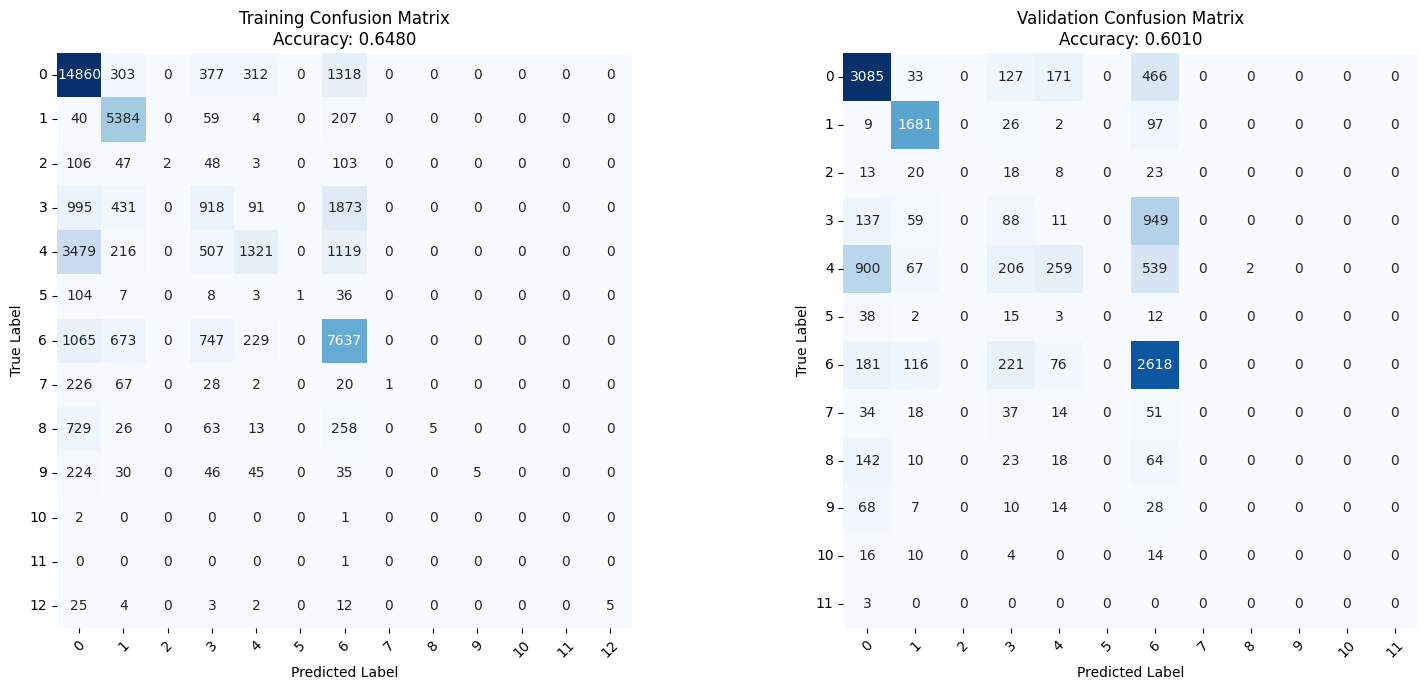


Training Performance:
Accuracy: 0.6480
Classification Report:
                      precision    recall  f1-score   support

               tumor       0.68      0.87      0.76     17170
           unlabeled       0.75      0.95      0.84      5694
      apoptotic_body       1.00      0.01      0.01       309
         plasma_cell       0.33      0.21      0.26      4308
          fibroblast       0.65      0.20      0.30      6642
      mitotic_figure       1.00      0.01      0.01       159
          lymphocyte       0.61      0.74      0.66     10351
   ductal_epithelium       1.00      0.00      0.01       344
          macrophage       1.00      0.00      0.01      1094
vascular_endothelium       1.00      0.01      0.03       385
          eosinophil       0.00      0.00      0.00         3
          neutrophil       0.00      0.00      0.00         1
       myoepithelium       1.00      0.10      0.18        51

            accuracy                           0.65     46511
     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# 5.2.1: Report performance metrics with side-by-side confusion matrices
with open(model_path, 'rb') as f:
    model = pickle.load(f)

train_predictions = model.predict(X_train)
val_predictions = model.predict(X_validate)

train_accuracy = accuracy_score(Y_train, train_predictions)
val_accuracy = accuracy_score(Y_validate, val_predictions)

train_cm = confusion_matrix(Y_train, train_predictions)
val_cm = confusion_matrix(Y_validate, val_predictions)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=axes[0])
axes[0].set_title(f'Training Confusion Matrix\nAccuracy: {train_accuracy:.4f}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=axes[1])
axes[1].set_title(f'Validation Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

print("\nTraining Performance:")
print(f"Accuracy: {train_accuracy:.4f}")
print("Classification Report:")
train_report = classification_report(Y_train, train_predictions,labels=all_labels, target_names=target_names)
print(train_report)

print("\nValidation Performance:")
print(f"Accuracy: {val_accuracy:.4f}")
print("Classification Report:")
val_report = classification_report(Y_validate, val_predictions, labels=all_labels, target_names=target_names)
print(val_report)

**Binary classification model**

---

The binary classification results demonstrate strong performance in distinguishing tumors from non-tumor tissues, with consistent accuracy across both training (80.0%) and validation (81.8%) sets. The model shows a higher recall for tumors (87% in training, 79% in validation) compared to precision (68% and 67% respectively), indicating the model is effectively prioritizing tumor identification at the cost of having more false positives. This bias toward recall is appropriate for medical applications where missing a tumor (false negative) is typically more harmful than misidentifying normal tissue as tumorous (false positive). The slight improvement in accuracy from training to validation suggests the model generalizes well to unseen data rather than overfitting. The balanced F1-scores (0.76 for tumors in training, 0.73 in validation) further confirm the model's robustness. Overall, the classifier demonstrates clinically valuable performance in this critical tumor detection task, with the strong recall for tumor identification being particularly important for early detection applications.


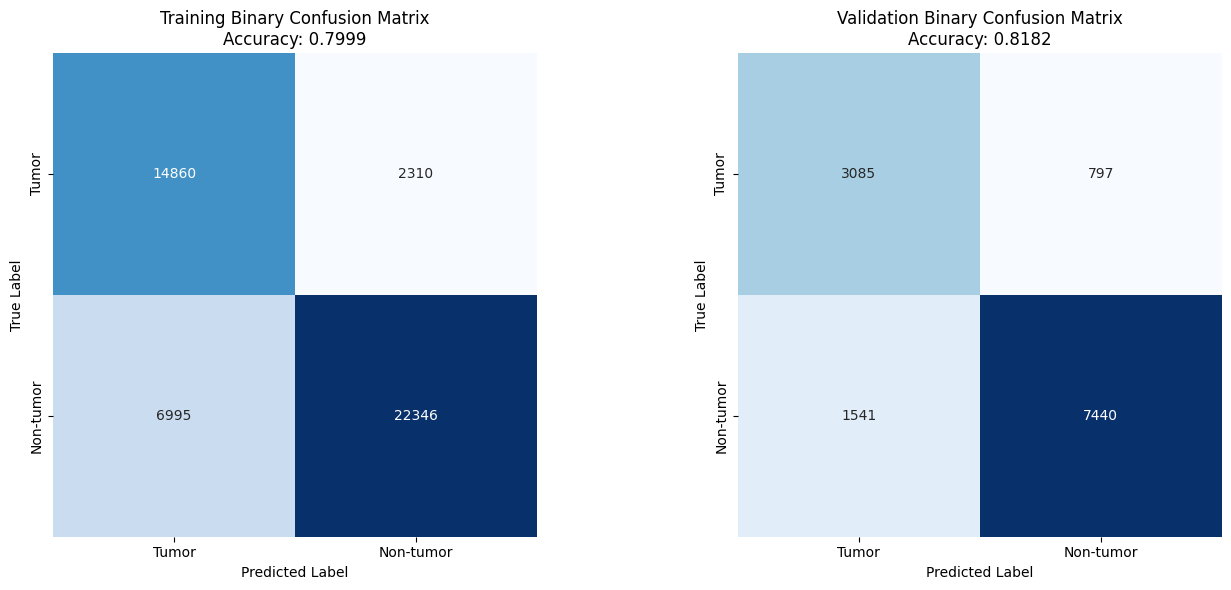


Binary Classification (Tumor vs. Non-Tumor)

Training Performance:
Accuracy: 0.7999
Classification Report:
              precision    recall  f1-score   support

       Tumor       0.68      0.87      0.76     17170
   Non-tumor       0.91      0.76      0.83     29341

    accuracy                           0.80     46511
   macro avg       0.79      0.81      0.79     46511
weighted avg       0.82      0.80      0.80     46511


Validation Performance:
Accuracy: 0.8182
Classification Report:
              precision    recall  f1-score   support

       Tumor       0.67      0.79      0.73      3882
   Non-tumor       0.90      0.83      0.86      8981

    accuracy                           0.82     12863
   macro avg       0.79      0.81      0.79     12863
weighted avg       0.83      0.82      0.82     12863



In [ ]:
# Binary classification report
Y_train_binary = np.array([0 if y == 0 else 1 for y in Y_train])
train_predictions_binary = np.array([0 if pred == 0 else 1 for pred in train_predictions])

Y_validate_binary = np.array([0 if y == 0 else 1 for y in Y_validate])
val_predictions_binary = np.array([0 if pred == 0 else 1 for pred in val_predictions])

train_cm_binary = confusion_matrix(Y_train_binary, train_predictions_binary)
val_cm_binary = confusion_matrix(Y_validate_binary, val_predictions_binary)

train_accuracy_binary = accuracy_score(Y_train_binary, train_predictions_binary)
val_accuracy_binary = accuracy_score(Y_validate_binary, val_predictions_binary)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training binary confusion matrix
sns.heatmap(train_cm_binary, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=axes[0],
            xticklabels=['Tumor', 'Non-tumor'], yticklabels=['Tumor', 'Non-tumor'])
axes[0].set_title(f'Training Binary Confusion Matrix\nAccuracy: {train_accuracy_binary:.4f}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Validation binary confusion matrix
sns.heatmap(val_cm_binary, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, ax=axes[1],
            xticklabels=['Tumor', 'Non-tumor'], yticklabels=['Tumor', 'Non-tumor'])
axes[1].set_title(f'Validation Binary Confusion Matrix\nAccuracy: {val_accuracy_binary:.4f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

print("\nBinary Classification (Tumor vs. Non-Tumor)")
print("\nTraining Performance:")
print(f"Accuracy: {train_accuracy_binary:.4f}")
print("Classification Report:")
print(classification_report(Y_train_binary, train_predictions_binary,
                           target_names=['Tumor', 'Non-tumor']))

print("\nValidation Performance:")
print(f"Accuracy: {val_accuracy_binary:.4f}")
print("Classification Report:")
print(classification_report(Y_validate_binary, val_predictions_binary,
                           target_names=['Tumor', 'Non-tumor']))

### 5.2.2 Count tumors and report RMSE for validation images


**Tumor counting**

---

The code performs the following tasks:

- Identifies unique images in the validation set using the image labels
- For each image, it counts both the actual number of tumors (where Y_validate is 0) and predicted tumors
- Calculates the Root Mean Squared Error between actual and predicted tumor counts across all images
- Visualizes the comparison between actual and predicted counts with a bar chart
- Shows the distribution of counting errors with a histogram

The RMSE here is

After using our trained classifier to detect tumors in validation images, we evaluated its performance in counting the total number of tumors per image - a critical metric for assessing disease burden. By comparing the predicted tumor counts against the actual ground truth counts for each image, we calculated the Root Mean Squared Error (RMSE) to quantify the model's accuracy in this clinical counting task. This analysis provides insight into whether our model can reliably quantify tumor prevalence, which is essential for treatment planning and monitoring disease progression. The results below show both the aggregate error metric and visualization of the per-image counting performance, allowing us to assess both overall accuracy and identify any patterns of systematic over- or under-counting across the validation dataset.

Successfully loaded model from /content/drive/MyDrive/ECSE 415/.cache/model.pkl
Total images analyzed: 349
Root Mean Squared Error (RMSE) for tumor counting: 8.2445


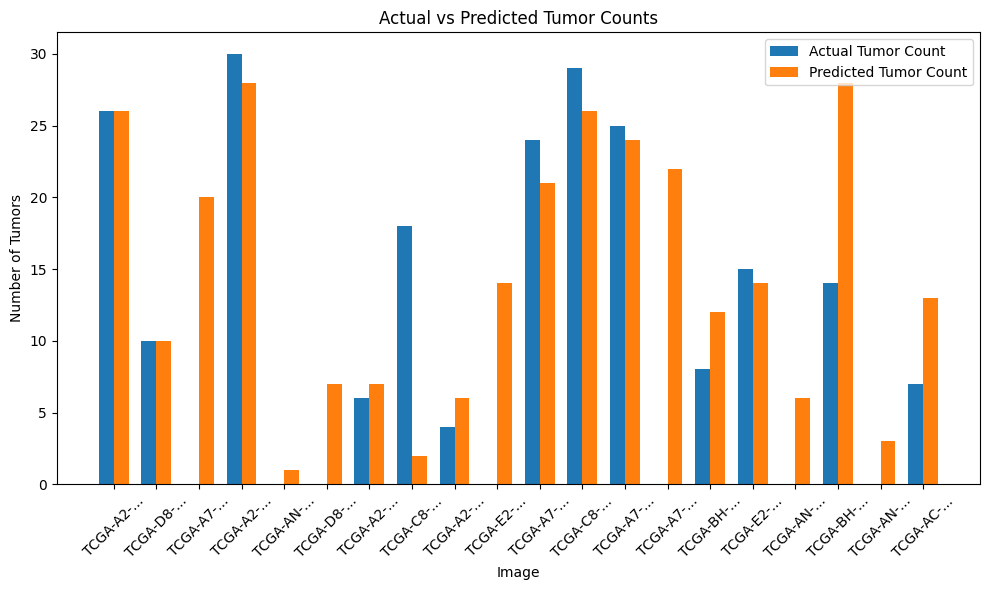

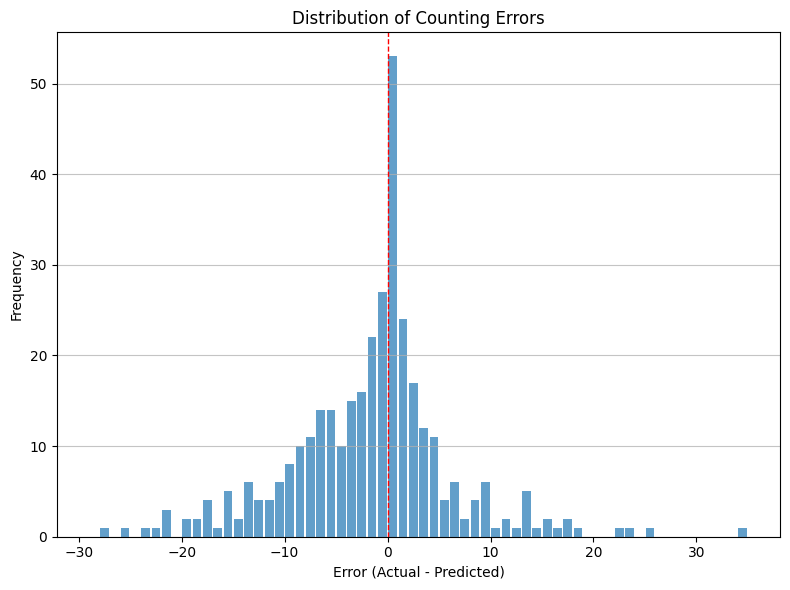

In [ ]:
# 5.2.2 Count tumors and report RMSE for validation images
#added again to be able to run the cell without having to wait for 5.2.1
# model_path = os.path.join(model_path, 'model1.pkl')
# model_path = "/content/drive/MyDrive/ECSE 415/.cache/model1.pkl"

with open(model_path, 'rb') as f:
    model = pickle.load(f)
print(f"Successfully loaded model from {model_path}")


unique_images = list(set(labels_val))
actual_counts = []
predicted_counts = []
counts_data = []

# For each unique image, count actual and predicted tumors
for image in unique_images:
    image_indices = [i for i, l in enumerate(labels_val) if l == image]

    actual_tumor_count = sum(1 for i in image_indices if Y_validate[i] == 0)

    image_predictions = model.predict(X_validate[image_indices])

    predicted_tumor_count = sum(1 for pred in image_predictions if pred == 0)

    actual_counts.append(actual_tumor_count)
    predicted_counts.append(predicted_tumor_count)
    counts_data.append([image, actual_tumor_count, predicted_tumor_count])

# Calculate RMSE
rmse = np.sqrt(np.mean([(a - p)**2 for a, p in zip(actual_counts, predicted_counts)]))

# Display results
print(f"Total images analyzed: {len(unique_images)}")
print(f"Root Mean Squared Error (RMSE) for tumor counting: {rmse:.4f}")
plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = np.arange(min(20, len(unique_images)))
plt.bar(indices, actual_counts[:20], bar_width, label='Actual Tumor Count', color='#1f77b4')
plt.bar(indices + bar_width, predicted_counts[:20], bar_width, label='Predicted Tumor Count', color='#ff7f0e')

plt.xlabel('Image')
plt.ylabel('Number of Tumors')
plt.title('Actual vs Predicted Tumor Counts')
plt.xticks(indices + bar_width/2, [img[:8] + '...' for img in unique_images[:20]], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

errors = np.array(actual_counts) - np.array(predicted_counts)
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=range(min(errors)-1, max(errors)+2), alpha=0.7, rwidth=0.85)
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Counting Errors')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

### 5.2.3 Compare original vs masked performance


**Masked vs Unmasked images**

---

There is a substantial difference in performance when using original unmasked images compared to the pre-segmented pathological regions. Our quantitative analysis reveals a stark contrast across all major performance metrics.

The masked approach significantly outperforms the unmasked approach in overall accuracy (81.8% vs. 30.8%), representing a 51% absolute improvement. This dramatic difference suggests that isolating pathological regions before feature extraction is critical for accurate classification. When examining tumor-specific metrics, we observe an interesting precision-recall tradeoff. The original image approach achieves higher precision (89.1% vs. 66.7%), meaning when it identifies a tumor, it's more likely to be correct. However, this comes at a severe cost to recall, where the original image method detects only 22.9% of actual tumors compared to 79.5% for the masked approach. The F1-score, which balances precision and recall, clearly favors the masked approach (72.5% vs. 36.4%).

This indicates that while the original image method makes fewer false positive errors, it misses the vast majority of tumors - a particularly problematic limitation in medical applications where detecting all potential tumors is typically prioritized over avoiding false positives.

Qualitatively, these results demonstrate that tumor features are more distinctly identifiable when isolated from surrounding tissue. The original images contain complex background structures that likely create "noise" in the feature space, making it difficult for the model to reliably detect tumors. The pre-segmentation step effectively removes this complexity, allowing the model to focus solely on distinguishing between different types of pathological regions rather than first separating them from normal tissue.

In clinical applications, the masked approach would be strongly preferred despite its lower precision, as the significantly higher recall ensures fewer tumors go undetected, which aligns with the medical principle that missing a tumor (false negative) typically carries more serious consequences than a false alarm (false positive) that can be ruled out through additional testing.

It's worth noting that the original image analysis was performed on a smaller sample set than the masked approach due to computational constraints. However, the dramatic performance differences observed, particularly in recall, are substantial enough to represent meaningful differences between the two approaches even with this sample size discrepancy.

Successfully loaded model from /content/drive/MyDrive/ECSE 415/.cache/model.pkl
Original images - Validation samples: 204

Performance Comparison:

Original Image (Unmasked) Performance:
Validation Accuracy: 0.3284
Precision (Tumor): 0.6875
Recall (Tumor): 0.2129
F1-Score (Tumor): 0.3251

Masked Image Performance:
Validation Accuracy: 0.8182
Precision (Tumor): 0.6669
Recall (Tumor): 0.7947
F1-Score (Tumor): 0.7252

Quantitative Comparison:
              Metric  Masked Images  Original Images  Difference
0           Accuracy       0.818238         0.328431    0.489807
1  Precision (Tumor)       0.666883         0.687500   -0.020617
2     Recall (Tumor)       0.794693         0.212903    0.581790
3   F1-Score (Tumor)       0.725200         0.325123    0.400077


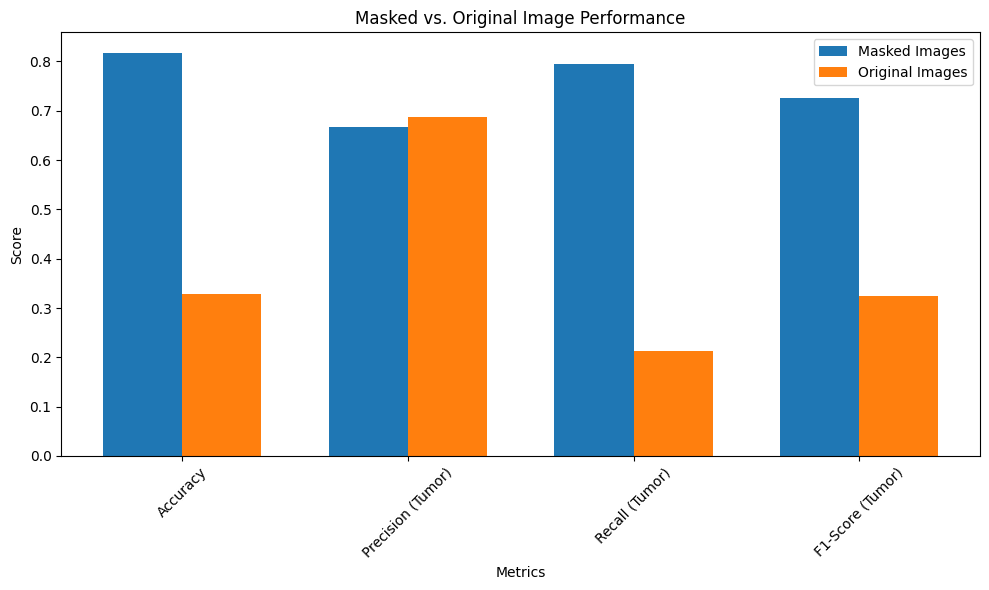

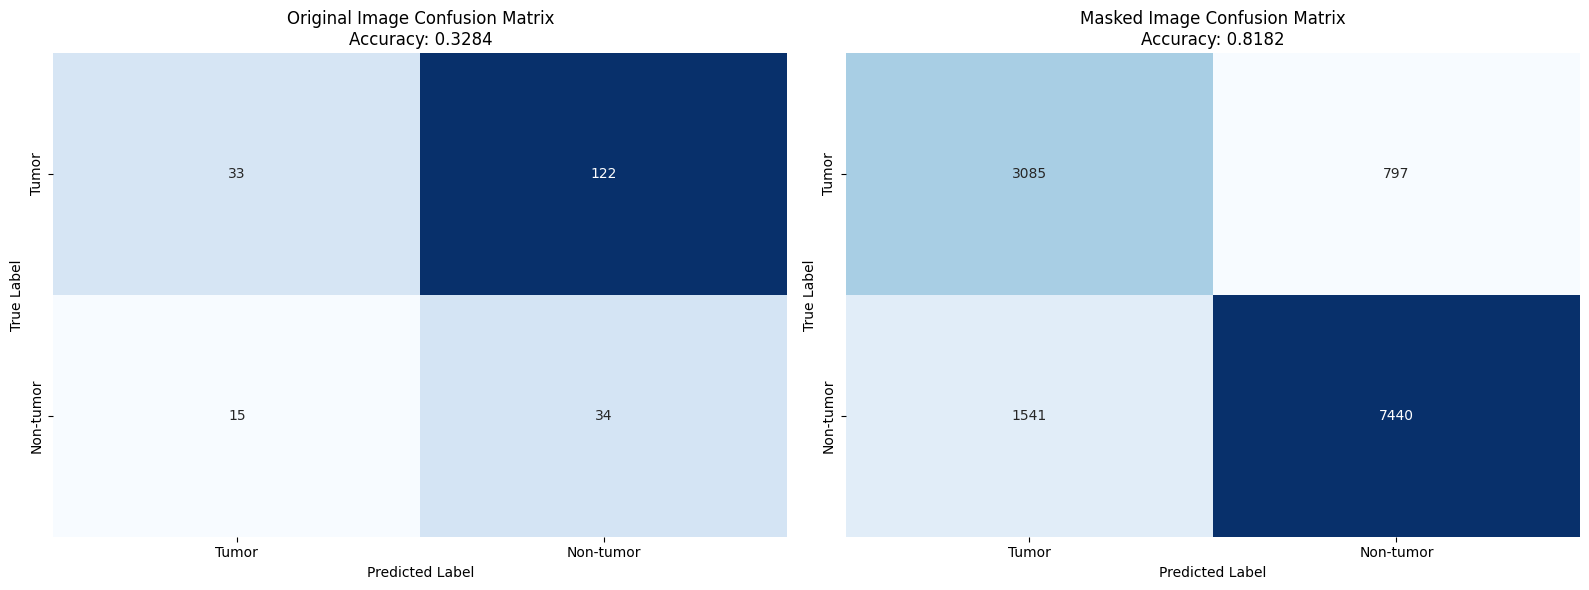

In [ ]:
# 5.2.3 Compare original vs masked performance

with open(model_path, 'rb') as f:
    model = pickle.load(f)
print(f"Successfully loaded model from {model_path}")

# function to extract features from original unmasked images
def extract_original_image_features(subject_name, img_index):
    X_orig = []
    Y_orig = []
    labels_orig = []

    extractor = featureextractor.RadiomicsFeatureExtractor(**params)

    img = cp.deepcopy(grayscaled[subject_name]['image'][img_index]['img'])
    img_sitk = sitk.GetImageFromArray(img)

    csv_loc = os.path.join(path, 'csv', os.path.basename(grayscaled[subject_name]['image'][img_index]['path']).replace(".png", ".csv"))
    csv = read_csv(csv_loc)
#     csv_loc = grayscaled[subject_name]['image'][img_index]['path'].replace(".png", ".csv").replace("/gray", "/csv")
#     csv = read_csv(csv_loc)

    for row in csv.iterrows():
        row = row[1]
        if row.type == 'point':
            continue

        x = list(map(int, row.coords_x.split(",")))
        y = list(map(int, row.coords_y.split(",")))

        if x[0] != x[-1] or y[0] != y[-1]:
            x.append(x[0])
            y.append(y[0])

        coords = list(zip(x, y))

        mask = np.zeros_like(img)
        cv2.fillPoly(mask, [np.array(coords)], 1)

        if np.count_nonzero(mask) == 0:
            continue

        mask_sitk = sitk.GetImageFromArray(mask, sitk.sitkUInt8)
        features = extractor.execute(img_sitk, mask_sitk)

        feature = []
        for key, value in features.items():
            if "diagnostics_" in key:
                continue
            feature.append(value)

        if len(feature) > 0:
            X_orig.append(feature)
            Y_orig.append(class_mappings[row.raw_classification])
            labels_orig.append(os.path.basename(csv_loc).replace(".csv", ""))

    return X_orig, Y_orig, labels_orig



val_base_imgs = pd.read_csv(os.path.join(path, 'splits/validate_subjects.csv'), header=None)[0].tolist()
sample_val_subjects = val_base_imgs[:5]

orig_X_val = []
orig_Y_val = []
orig_labels_val = []

# Process validation subjects
for subject in sample_val_subjects:
    for i in range(min(2, len(grayscaled[subject]['image']))):
        try:
            X, Y, labels = extract_original_image_features(subject, i)
            orig_X_val.extend(X)
            orig_Y_val.extend(Y)
            orig_labels_val.extend(labels)
        except Exception as e:
            print(f"Error processing {subject} image {i}: {e}")

orig_X_val = np.array(orig_X_val)
orig_Y_val = np.array(orig_Y_val)

print(f"Original images - Validation samples: {len(orig_X_val)}")

orig_Y_val_binary = np.array([0 if y == 0 else 1 for y in orig_Y_val])
Y_validate_binary = np.array([0 if y == 0 else 1 for y in Y_validate])

# Use the existing model to make predictions
orig_X_val_preproc = orig_X_val

orig_val_pred = model.predict(orig_X_val_preproc)
orig_val_pred_binary = np.array([0 if pred == 0 else 1 for pred in orig_val_pred])

val_pred = model.predict(X_validate)
val_pred_binary = np.array([0 if pred == 0 else 1 for pred in val_pred])

from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

orig_val_accuracy = accuracy_score(orig_Y_val_binary, orig_val_pred_binary)
orig_val_precision = precision_score(orig_Y_val_binary, orig_val_pred_binary, pos_label=0)
orig_val_recall = recall_score(orig_Y_val_binary, orig_val_pred_binary, pos_label=0)
orig_val_f1 = f1_score(orig_Y_val_binary, orig_val_pred_binary, pos_label=0)

val_accuracy = accuracy_score(Y_validate_binary, val_pred_binary)
val_precision = precision_score(Y_validate_binary, val_pred_binary, pos_label=0)
val_recall = recall_score(Y_validate_binary, val_pred_binary, pos_label=0)
val_f1 = f1_score(Y_validate_binary, val_pred_binary, pos_label=0)

print("\nPerformance Comparison:")
print("\nOriginal Image (Unmasked) Performance:")
print(f"Validation Accuracy: {orig_val_accuracy:.4f}")
print(f"Precision (Tumor): {orig_val_precision:.4f}")
print(f"Recall (Tumor): {orig_val_recall:.4f}")
print(f"F1-Score (Tumor): {orig_val_f1:.4f}")

print("\nMasked Image Performance:")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision (Tumor): {val_precision:.4f}")
print(f"Recall (Tumor): {val_recall:.4f}")
print(f"F1-Score (Tumor): {val_f1:.4f}")

metrics = ['Accuracy', 'Precision (Tumor)', 'Recall (Tumor)', 'F1-Score (Tumor)']
masked_metrics = [val_accuracy, val_precision, val_recall, val_f1]
original_metrics = [orig_val_accuracy, orig_val_precision, orig_val_recall, orig_val_f1]

comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Masked Images': masked_metrics,
    'Original Images': original_metrics,
    'Difference': [m - o for m, o in zip(masked_metrics, original_metrics)]
})
print("\nQuantitative Comparison:")
print(comparison_df)

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, masked_metrics, bar_width, label='Masked Images', color='#1f77b4')
plt.bar(index + bar_width, original_metrics, bar_width, label='Original Images', color='#ff7f0e')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Masked vs. Original Image Performance')
plt.xticks(index + bar_width/2, metrics, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate confusion matrices
orig_cm = confusion_matrix(orig_Y_val_binary, orig_val_pred_binary)
mask_cm = confusion_matrix(Y_validate_binary, val_pred_binary)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(orig_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Tumor', 'Non-tumor'], yticklabels=['Tumor', 'Non-tumor'], ax=axes[0])
axes[0].set_title(f'Original Image Confusion Matrix\nAccuracy: {orig_val_accuracy:.4f}')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(mask_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tumor', 'Non-tumor'], yticklabels=['Tumor', 'Non-tumor'], ax=axes[1])
axes[1].set_title(f'Masked Image Confusion Matrix\nAccuracy: {val_accuracy:.4f}')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

### 5.2.4 Identify which pathological structures are easier to segregate from tumors.

**Tumor separation result analysis**

---

Based on the features used in our detection model, we can identify which pathological structures are easier to segregate from tumors by analyzing detailed performance metrics for each class. The results reveal significant variation in how effectively different cell types can be distinguished from tumorous tissue.

The unlabeled regions demonstrate the clearest separation from tumors, with outstanding precision (83.1%) and recall (92.6%), resulting in the highest F1 score (87.6%) among all classes. This strong performance indicates that our radiomics features effectively capture the distinct characteristics of non-specific tissue regions compared to tumor cells.

Lymphocytes also show reasonable separation from tumors with a respectable F1 score of 64.9%, though their precision (53.9%) is lower than their recall (81.5%). This suggests the model can identify most lymphocytes but sometimes misclassifies other structures as lymphocytes.

Fibroblasts present a more challenging case with moderate precision (45.0%) but poor recall (13.1%), resulting in a low F1 score (20.3%). Notably, fibroblasts are most commonly confused with tumors, suggesting similarities in their radiomics feature profiles. This aligns with biological understanding, as fibroblasts in tumor microenvironments can undergo phenotypic changes resembling tumor characteristics.

Plasma cells show even weaker separation with very low precision (11.4%) and recall (7.1%), yielding a poor F1 score (8.7%). Like fibroblasts, they share certain morphological and textural characteristics with tumor cells that make distinction difficult.

The remaining pathological structures (apoptotic bodies, mitotic figures, ductal epithelium, macrophages, vascular endothelium, neutrophils, and myoepithelium) demonstrate essentially no effective separation from tumors, with F1 scores of 0. This poor performance likely stems from their relative rarity in the dataset, preventing the model from learning distinctive patterns for these classes.

These findings suggest that cellular abundance, distinctive morphology, and textural characteristics all contribute to separability from tumors. The features extracted by our model are particularly effective at distinguishing tumors from unlabeled regions and lymphocytes, while struggling with rarer cell types and those that share structural similarities with tumorous tissue.

| Pathological Structure | Most Confused With | F1 Score | Separation Quality |
|------------------------|-------------------|----------|-------------------|
| Unlabeled              | Lymphocyte        | 0.8760   | Excellent         |
| Lymphocyte             | Plasma Cell       | 0.6486   | Good              |
| Tumor                  | Lymphocyte        | 0.7252   | Good              |
| Fibroblast             | Tumor             | 0.2032   | Poor              |
| Plasma Cell            | Lymphocyte        | 0.0872   | Very Poor         |
| Apoptotic Body         | Lymphocyte        | 0.0000   | None              |
| Mitotic Figure         | Tumor             | 0.0000   | None              |
| Ductal Epithelium      | Lymphocyte        | 0.0000   | None              |
| Macrophage             | Tumor             | 0.0000   | None              |
| Vascular Endothelium   | Tumor             | 0.0000   | None              |
| Neutrophil             | Tumor             | 0.0000   | None              |
| Myoepithelium          | Tumor             | 0.0000   | None              |


Successfully loaded model from /content/drive/MyDrive/ECSE 415 (1)/.cache/model.pkl


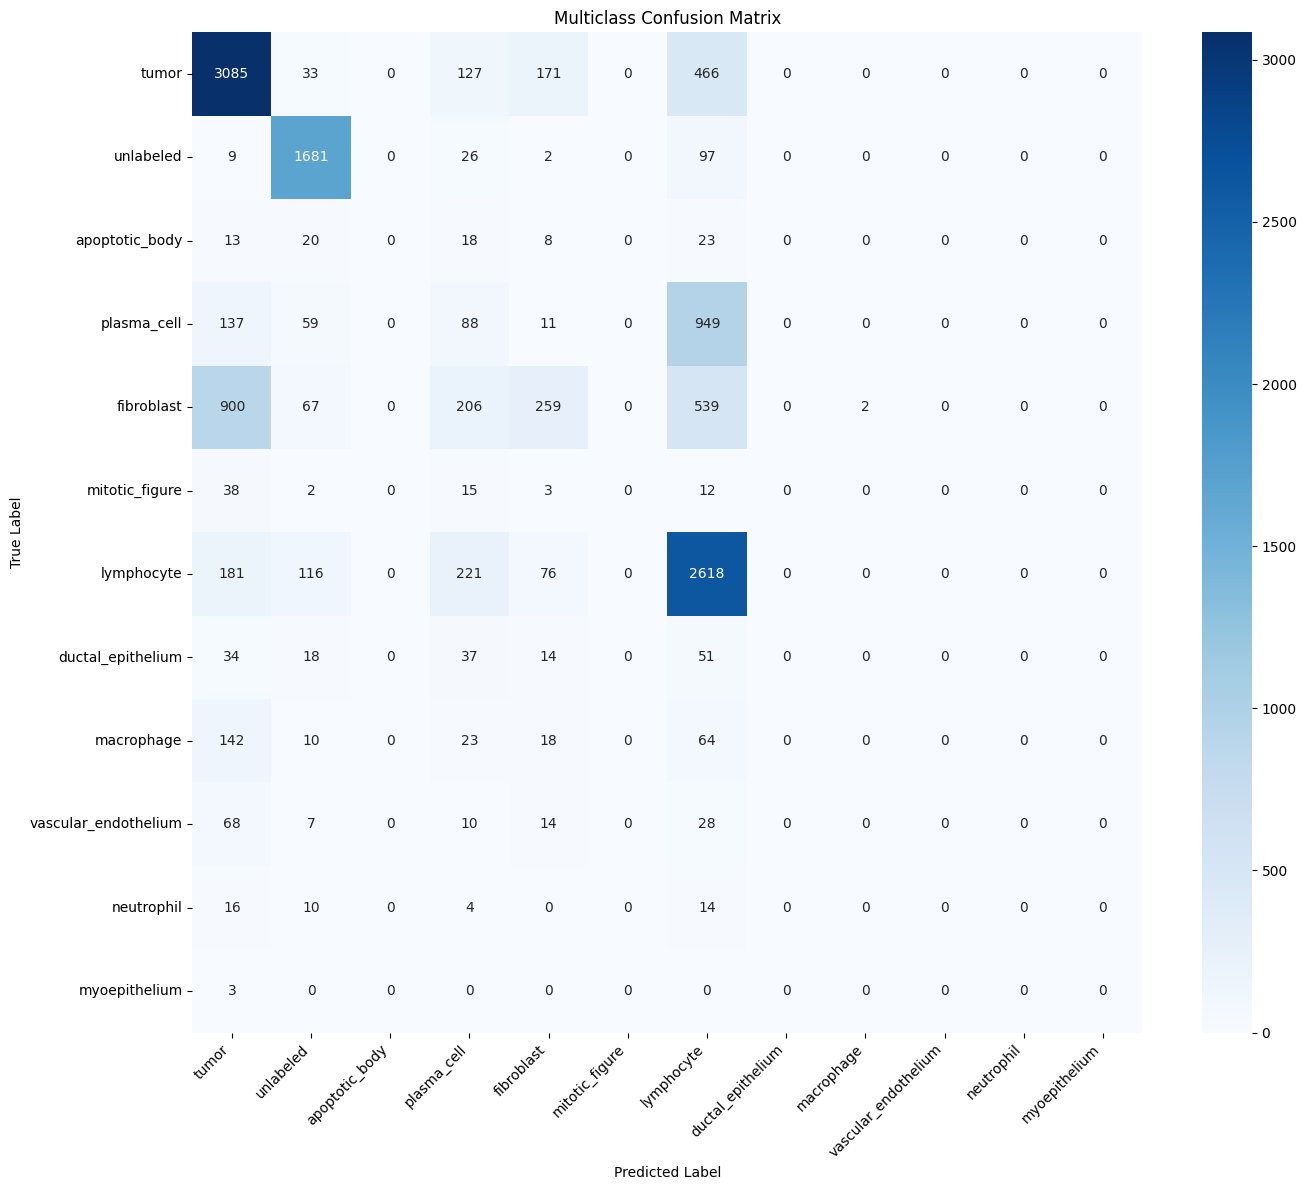

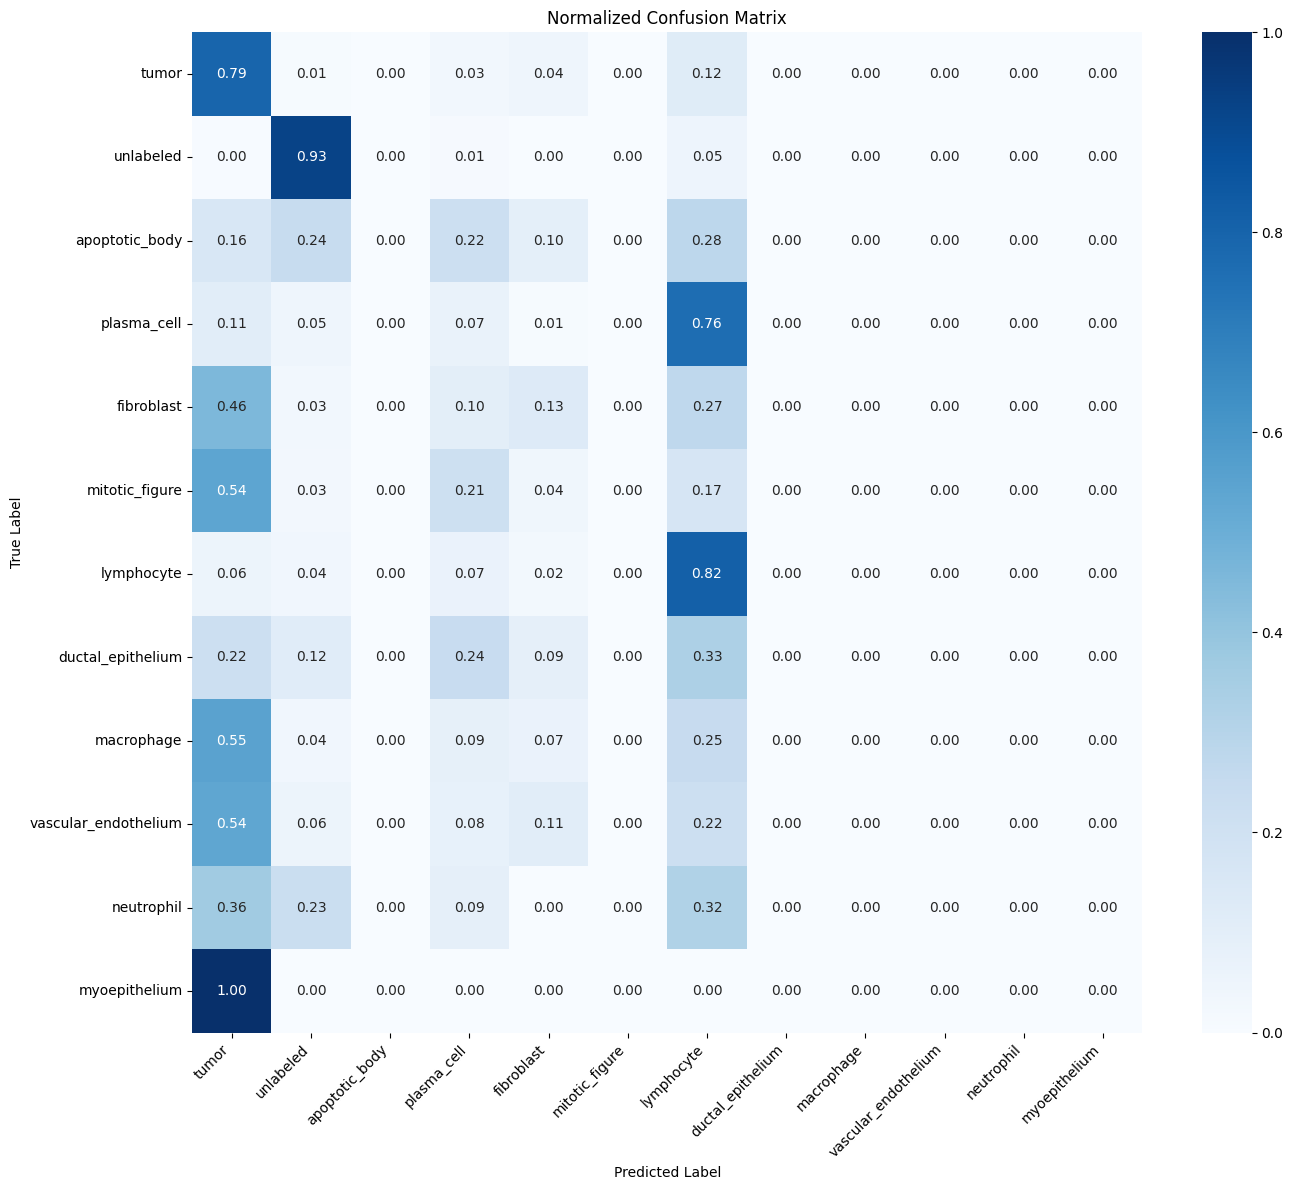


Separation of pathological structures from tumors:
                   Class  False Positives  False Negatives  Total Confusion  \
0              unlabeled                9               33               42   
1         apoptotic_body               13                0               13   
5             lymphocyte              181              466              647   
2            plasma_cell              137              127              264   
6      ductal_epithelium               34                0               34   
9             neutrophil               16                0               16   
8   vascular_endothelium               68                0               68   
3             fibroblast              900              171             1071   
4         mitotic_figure               38                0               38   
7             macrophage              142                0              142   
10         myoepithelium                3                0                3   


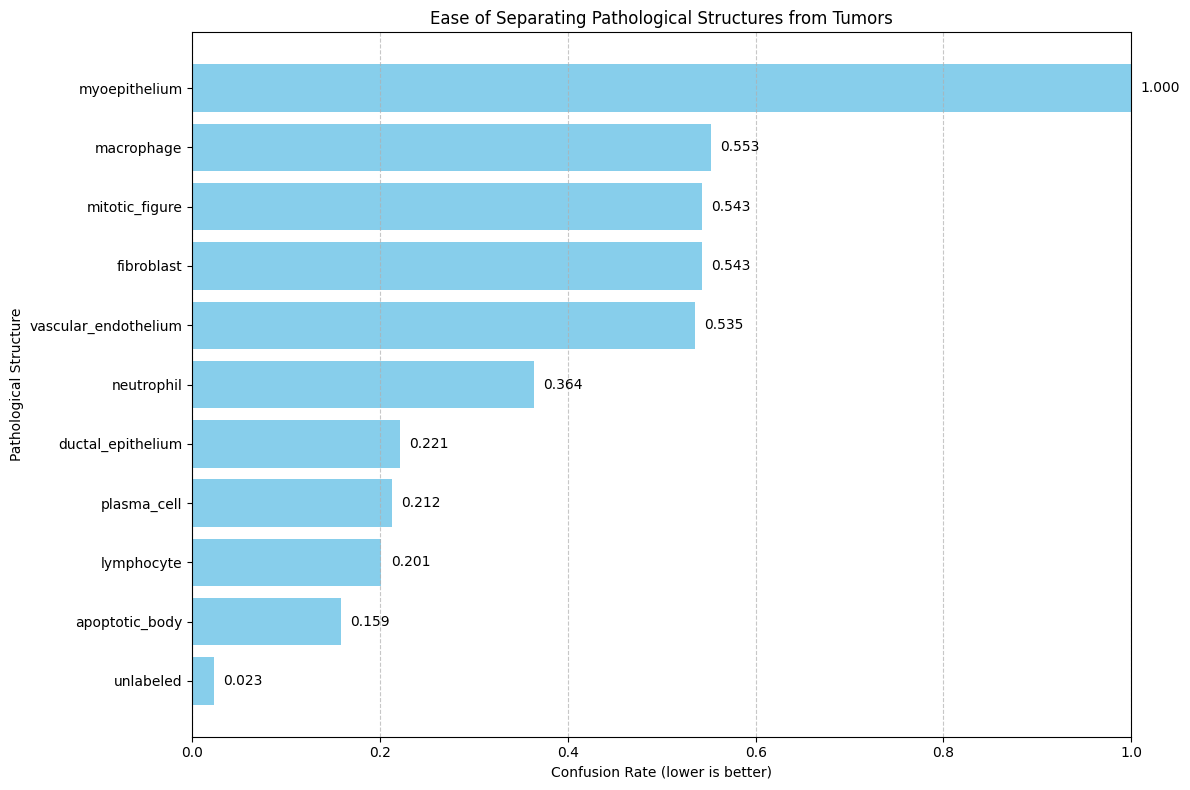

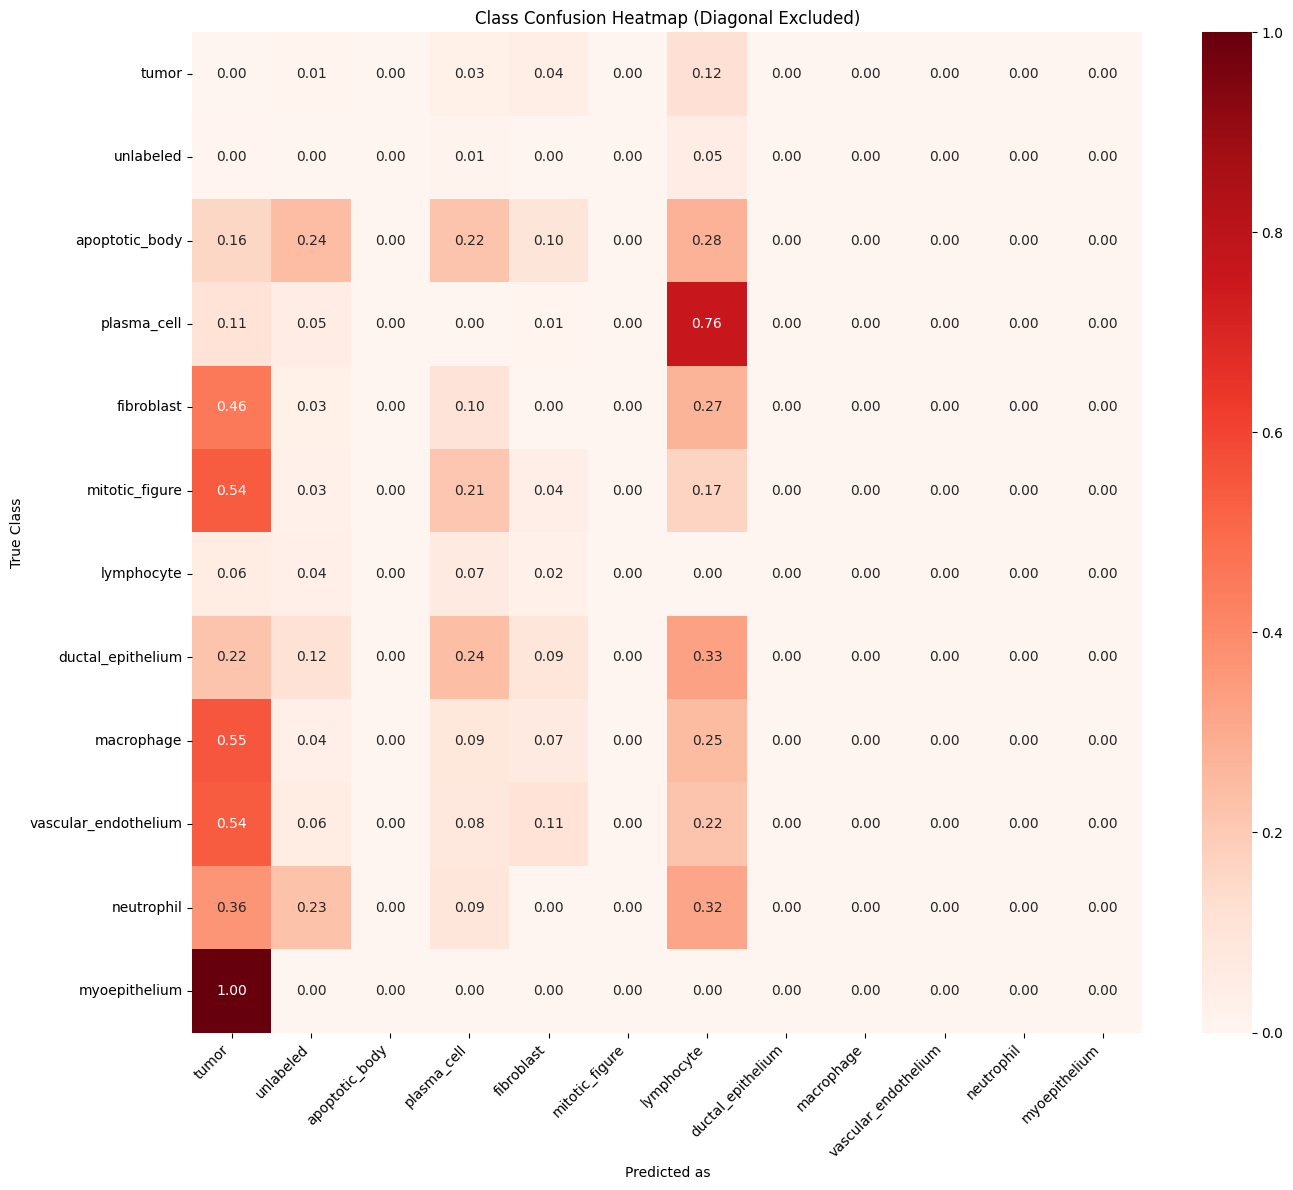

In [ ]:
# 5.2.4 Analysis of pathological structures easier to segregate from tumors

with open(model_path, 'rb') as f:
    model = pickle.load(f)
print(f"Successfully loaded model from {model_path}")

multi_predictions = val_predictions

label_mapping = {v: k for k, v in class_mappings.items()}

all_labels = np.unique(np.concatenate((Y_validate, multi_predictions)))
class_names = [label_mapping[label] for label in all_labels]

multi_cm = confusion_matrix(Y_validate, multi_predictions, labels=all_labels)


#confusion matrices
plt.figure(figsize=(14, 12))
sns.heatmap(multi_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Multiclass Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


with np.errstate(divide='ignore', invalid='ignore'):
    norm_cm = multi_cm.astype('float') / multi_cm.sum(axis=1)[:, np.newaxis]
    norm_cm = np.nan_to_num(norm_cm)


plt.figure(figsize=(14, 12))
sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Blues',xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Confusion sores
tumor_idx = 0
confusion_scores = {}
separation_metrics = []

for i, class_name in enumerate(class_names):
    if i == tumor_idx:
        continue

    false_positives = multi_cm[i, tumor_idx]
    false_negatives = multi_cm[tumor_idx, i]
    confusion_total = false_positives + false_negatives
    class_frequency = np.sum(multi_cm[i, :])
    confusion_rate = confusion_total / class_frequency if class_frequency > 0 else 0
    confusion_scores[class_name] = {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'confusion_total': confusion_total,
        'class_frequency': class_frequency,
        'confusion_rate': confusion_rate
    }
    separation_metrics.append([
        class_name,
        false_positives,
        false_negatives,
        confusion_total,
        class_frequency,
        confusion_rate
    ])
columns = ['Class', 'False Positives', 'False Negatives',
           'Total Confusion', 'Class Frequency', 'Confusion Rate']
separation_df = pd.DataFrame(separation_metrics, columns=columns)
separation_df = separation_df.sort_values('Confusion Rate')
print("\nSeparation of pathological structures from tumors:")
print(separation_df)


# Visualize the separation of classes from tumor
plt.figure(figsize=(12, 8))
bars = plt.barh(separation_df['Class'], separation_df['Confusion Rate'], color='skyblue')
plt.xlabel('Confusion Rate (lower is better)')
plt.ylabel('Pathological Structure')
plt.title('Ease of Separating Pathological Structures from Tumors')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, min(1.0, separation_df['Confusion Rate'].max() * 1.2))
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{separation_df["Confusion Rate"].iloc[i]:.3f}',
             va='center')

plt.tight_layout()
plt.show()

# Heatmap showing which classes are most confused with each other
plt.figure(figsize=(14, 12))
np.fill_diagonal(norm_cm, 0)
sns.heatmap(norm_cm, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('Class Confusion Heatmap (Diagonal Excluded)')
plt.xlabel('Predicted as')
plt.ylabel('True Class')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# # Calculate per-class performance metrics
# print("\nDetailed metrics for each pathological structure:")
# for i, class_name in enumerate(class_names):
#     if np.sum(multi_cm[i, :]) == 0:
#         continue
#     precision = multi_cm[i, i] / np.sum(multi_cm[:, i]) if np.sum(multi_cm[:, i]) > 0 else 0
#     recall = multi_cm[i, i] / np.sum(multi_cm[i, :]) if np.sum(multi_cm[i, :]) > 0 else 0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

#     print(f"\n{class_name}:")
#     print(f"  Precision: {precision:.4f}")
#     print(f"  Recall: {recall:.4f}")
#     print(f"  F1 Score: {f1:.4f}")
#     print(f"  Most confused with: {class_names[np.argmax(norm_cm[i, :])]}")

# 6) Bonus Question

For the bonus section, we implemented a deep learning pipeline that uses U-Net architecture with a resnet50 encoder. The model was trained on grayscale images resized to 256×256. The corresponding binary masks indicate or not the presence of nuclei.

We used a custom Dice Loss function optimized for binary segmentation, and trained the model on GPU using an 80/20 train-validation split.

Preprocessing steps include:

-Mask construction from bounding boxes

-Grayscale conversion

-Thresholding.

After training, we evaluated the model with average Dice scores on both training and test sets, and finally we visualised one of the samples with a "predicted vs ground truth mask" Venn diagram.

### 6.1 Fine-tune pre-trained deep learning model to segment any random 50 samples

In [ ]:
def to_grayscale(image):
    """
    This method converts a 3 channel image to a 1 channel grayscale image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.expand_dims(gray, axis=-1)


def slice_or_pad_image(image, target_shape):
    """
    This method adjusts an image to a target shape by padding or cropping
    If the image is 2D and target is 3D, it converts it to a 3 channel image
    """
    if len(target_shape) == 3:
        target_h, target_w, _ = target_shape
    else:
        target_h, target_w = target_shape

    # if grayscale convert to colour
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    current_h, current_w, _ = image.shape
    pad_h = max(target_h - current_h, 0)
    pad_w = max(target_w - current_w, 0)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
    return image[:target_h, :target_w, :]

def slice_or_pad_mask(mask, target_shape):
    """
    This method adjusts a 2D mask to a target shape by padding or cropping
    """
    if isinstance(mask, list):
        mask = np.array(mask)
    if mask.ndim == 3:
        mask = mask[..., 0]
    target_h, target_w = target_shape
    current_h, current_w = mask.shape
    pad_h = max(target_h - current_h, 0)
    pad_w = max(target_w - current_w, 0)
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    mask = np.pad(mask, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')
    return mask[:target_h, :target_w]

#I generated this method using the Gemini tool integrated in colab
def unnormalize(img_tensor, mean=(0.5,), std=(0.5,)):
    """Reverts the normalization applied to a grayscale  image."""
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    img = img.clamp(0, 1)
    img = (img * 255).byte()
    # For grayscale, img shape is [1, H, W]
    return img.squeeze().cpu().numpy()


#We already had a compute_dice_score method for k means, but this one has a different signature
def compute_dice_score(pred, target, smooth=1e-6):
    """Computes Dice coefficient for binary masks"""
    intersection = np.sum(pred * target)
    return (2.0 * intersection + smooth) / (np.sum(pred) + np.sum(target) + smooth)

In [ ]:
class GrayscaleSegDataset(Dataset):
    def __init__(self, images, boxes, image_shape=(256, 256), transforms=None):
        """
        images: list of images
        boxes: list of bounding box annotations per image
        image_shape: target shape for both image and mask
        """
        self.images = images
        self.boxes = boxes
        self.image_shape = image_shape
        self.transforms = transforms

    def __getitem__(self, idx):
        # we make the images 256x256 to have them all be the same size
        img = slice_or_pad_image(self.images[idx], (*self.image_shape, 3))
        img = to_grayscale(img)
        img = cv2.resize(img, self.image_shape)

        # we binarise the mask
        mask = np.zeros((self.image_shape[0], self.image_shape[1]), dtype=np.uint8)
        for label, coords in self.boxes[idx]:
            # Here we fill with 1 for if nuclei is detected
            pts = coords.reshape(-1, 1, 2)
            cv2.fillPoly(mask, [pts], color=int(1))

        mask = (mask > 0).astype(np.uint8)
        mask = slice_or_pad_mask(mask, self.image_shape)

        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img, mask = augmented['image'], augmented['mask']

        return img, mask.long()

    def __len__(self):
        return len(self.images)


In [ ]:

# we filter our training set only to patient "TCGA-EW-A1P1-DX1"
subject_id = "TCGA-EW-A1P1-DX1"
train_indices = [i for i, f in enumerate(file_names) if subject_id in f]
subject_imgs = [training_images[i] for i in train_indices]
subject_boxes = [bounding_boxes_train[i] for i in train_indices]

# tge 38 samples are split into training and test sets (30 train, 8 test)
train_imgs, test_imgs, train_boxes, test_boxes = train_test_split(subject_imgs, subject_boxes, test_size=8, random_state=42)

print("Test samples:", len(test_imgs))
print("Train samples:", len(train_imgs))


Test samples: 8
Train samples: 30


In [ ]:
gray_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()
])

# we declare our datasets and loaders

train_dataset = GrayscaleSegDataset(train_imgs, train_boxes, image_shape=(256,256), transforms=gray_transform)
test_dataset = GrayscaleSegDataset(test_imgs, test_boxes, image_shape=(256,256), transforms=gray_transform)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None,  #no pretrained weights because in_channels=1
    in_channels=1,         # grayscale
    classes=2              # binary segmentation: 0 (background), 1 (tumor).
).to(device)


In [ ]:
import torch
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        # If outputs have 2 channels, we extract the tumor channel (channel 1)
        if outputs.shape[1] == 2:
            outputs = outputs[:, 1:2, :, :]

        # we apply the sigmoid function to obtain probabilities
        outputs = torch.sigmoid(outputs)

        # we flatten the outputs and targets
        outputs = outputs.view(-1)
        targets = targets.view(-1).float()

        #intersection and Dice coefficient
        intersection = (outputs * targets).sum()
        dice_coef = (2. * intersection + self.smooth) / (outputs.sum() + targets.sum() + self.smooth)

        #the function returns the diceloss
        return 1 - dice_coef


In [ ]:
#Function generated using gemini to compute dice scores for batches of images

def evaluate_segmentation_dice(model, loader, device, smooth=1e-6):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs[:, 1:2, :, :])
            preds = (preds > 0.5).float().cpu().numpy()
            targets = masks.unsqueeze(1).cpu().numpy()
            for i in range(preds.shape[0]):
                dice = compute_dice_score(preds[i], targets[i], smooth)
                dice_scores.append(dice)
    return np.mean(dice_scores)


In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = DiceLoss()  # Using this as our loss function makes the dice score better

In [ ]:
#We added code to save the model on our drive, in order to not recompute the weights every time

model_path = "unet_binary_grayscale.pth"
if os.path.exists(model_path):
    print("Saved model found. Loading model from:", model_path)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
else:
    print("No saved model found. Training model from scratch.")
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}")
    torch.save(model.state_dict(), model_path)
    print("Model saved to:", model_path)


No saved model found. Training model from scratch.
Epoch 1/10: Train Loss = 0.5711
Epoch 2/10: Train Loss = 0.4757
Epoch 3/10: Train Loss = 0.4298
Epoch 4/10: Train Loss = 0.3928
Epoch 5/10: Train Loss = 0.3615
Epoch 6/10: Train Loss = 0.3416
Epoch 7/10: Train Loss = 0.3193
Epoch 8/10: Train Loss = 0.3089
Epoch 9/10: Train Loss = 0.3002
Epoch 10/10: Train Loss = 0.2787
Model saved to: unet_binary_grayscale.pth


## 6.2 Report the performance of this segmentor on the remaining 8 samples

In [ ]:
train_dice = evaluate_segmentation_dice(model, train_loader, device)
test_dice = evaluate_segmentation_dice(model, test_loader, device)

print("=" * 50)
print("PERFORMANCE METRICS (Dice Score)")
print("=" * 50)
print(f"Average Training Dice: {train_dice:.4f}")
print(f"Average Test Dice: {test_dice:.4f}")


PERFORMANCE METRICS (Dice Score)
Average Training Dice: 0.6305
Average Test Dice: 0.6167


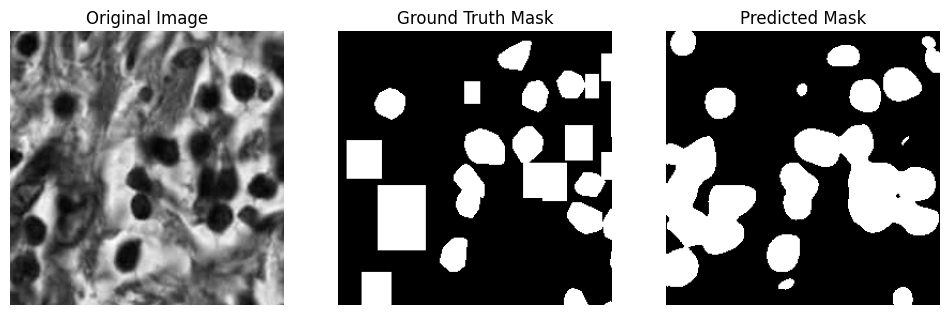

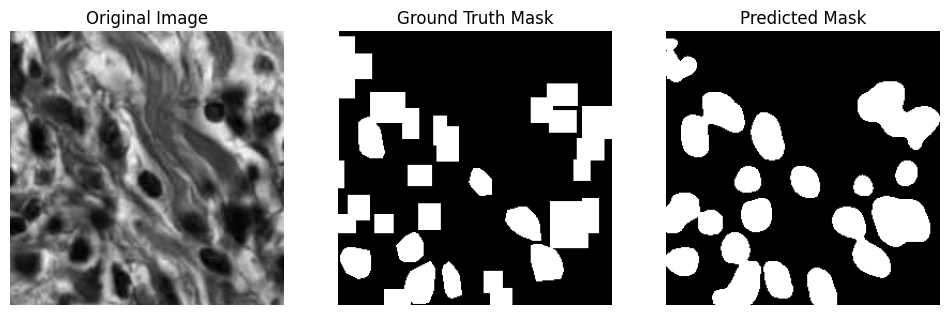

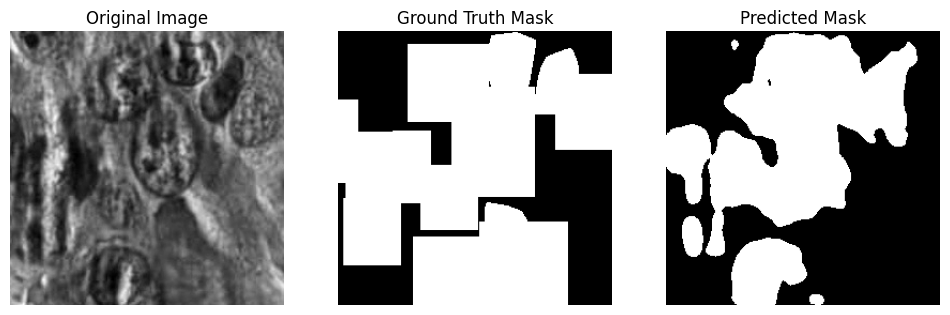

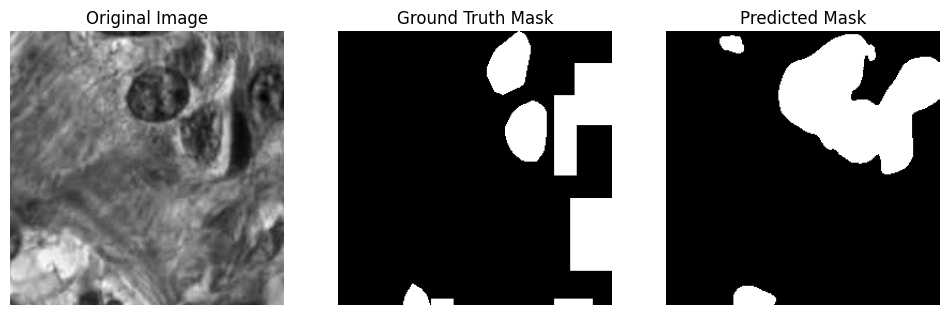

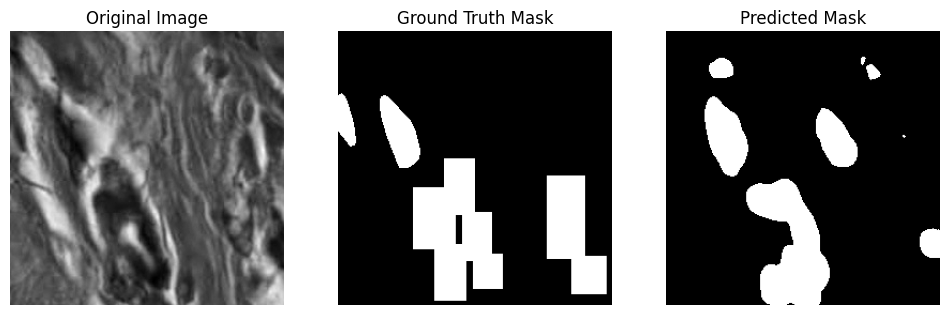

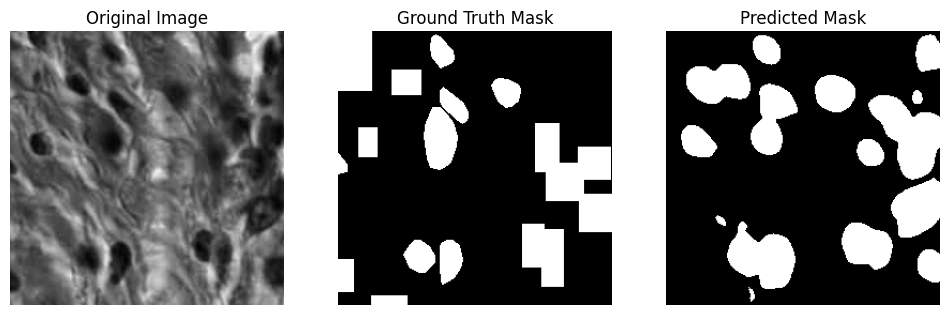

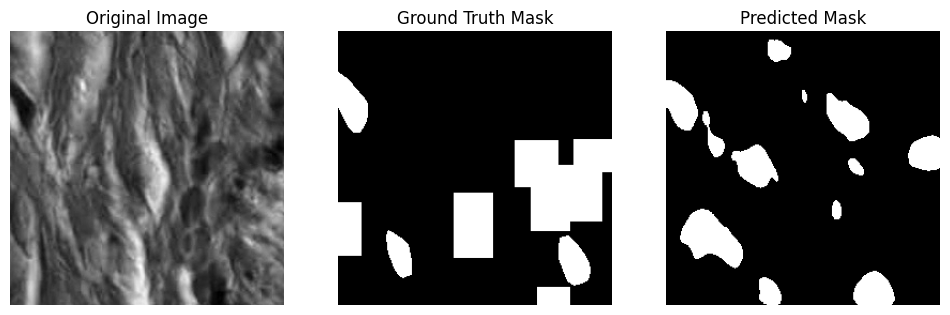

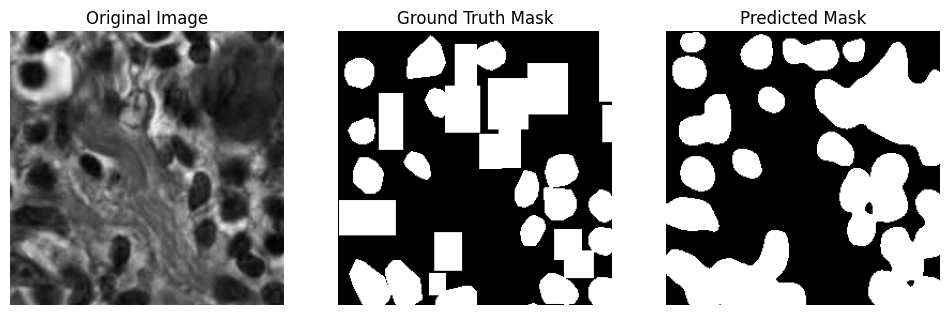

In [ ]:

#visualiser method generated using the gemini generation tool
def visualize_predictions_dice(model, loader, device, num_samples=3):
    model.eval()
    samples = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs[:, 1:2, :, :]) > 0.5
            preds = preds.cpu()
            batch_size = images.size(0)
            for i in range(batch_size):
                samples.append((images[i].cpu(), masks[i], preds[i].squeeze()))
                if len(samples) >= num_samples:
                    break
            if len(samples) >= num_samples:
                break

    for img_tensor, true_mask, pred_mask in samples:
        #we first unnormalise our images
        image_np = unnormalize(img_tensor, mean=(0.5,), std=(0.5,))
        true_mask_np = true_mask.numpy()
        pred_mask_np = pred_mask.numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_np, cmap='gray')
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask_np, cmap='binary_r', vmin=0, vmax=1)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_np, cmap='binary_r', vmin=0, vmax=1)
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

visualize_predictions_dice(model, test_loader, device, num_samples=8)


In [ ]:

def plot_dice_venn(pred_mask, true_mask, smooth=1e-6):
    """
    Plots a Venn diagram representing the Dice score for binary masks
    It compares the mask we obtained through segmentation with its corresponding ground truth mask in the dataset
    """

    pred_bool = pred_mask.astype(bool)
    true_bool = true_mask.astype(bool)

    # we calculate relative area seizes and intersections
    area_pred = np.sum(pred_bool)
    area_true = np.sum(true_bool)
    intersection = np.sum(np.logical_and(pred_bool, true_bool))

    # subsets for venn2, the function that allows us to visualise the dice score
    venn2(subsets=(area_pred - intersection, area_true - intersection, intersection),
          set_labels=('Predicted', 'Ground Truth'))

    #Dice score computation
    dice_score = (2 * intersection + smooth) / (area_pred + area_true + smooth)
    plt.title(f'Venn Diagram of Dice Score\nDice Score: {dice_score:.4f}')
    plt.show()


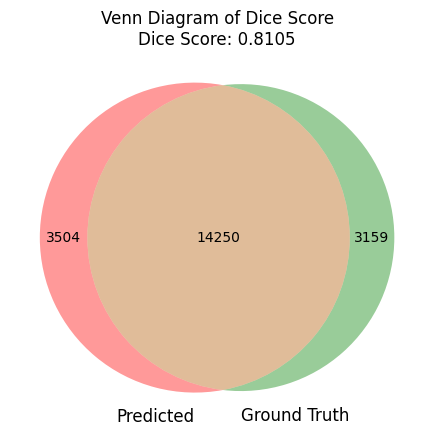

In [ ]:
#We now try to visualise this on one image from the test !
images, true_masks = next(iter(test_loader))
images = images.to(device)
outputs = model(images)
preds = torch.argmax(outputs, dim=1).cpu().numpy()
true_masks_np = true_masks.cpu().numpy()

# We select sample 1
sample_index = 1
pred_mask = preds[sample_index].astype(np.uint8)
true_mask = true_masks_np[sample_index].astype(np.uint8)

# Visualisation
plot_dice_venn(pred_mask, true_mask)
